In [274]:
#since noteboke doesn't work in jupiterlabs    %matplotlib notebook 
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
os.chdir('D:\\6OHDA\\')
#import mpld3
#mpld3.enable_notebook()
import numpy as np
import scipy as sci
from scipy import signal
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.colors as Mcolors
import matplotlib.cm as cmx
import sys
import h5py
from IO import *
from utils import *
from plotUtils import *
from ColorSchems import colorPallet as CP
import pptx
from pptx import Presentation 
from pptx.util import Inches
from io import BytesIO
import re
import warnings
import pandas as pd
import sqlalchemy as db
import gc
from tqdm import tqdm
import seaborn as sns
import pywt # wavelet package
import matplotlib.cm as cm

In [3]:
Files = ['FinalData_6OHDA.h5','FinalData_6OHDA_H.h5','FinalData_6OHDA_H_skip.h5','FinalData_6OHDA_skip.h5']
miceList = getMiceList(Files[0])

In [4]:
#path to folder where figures should be saved
figFolder = 'D:\\6OHDA\\extraAnalysis\\'

In [5]:
def periodCalc(day):
    if day== 0:
        return 'Healthy'
    elif day<13:
        return 'Acute'
    else:
        return 'Chronic'

<IPython.core.display.Javascript object>


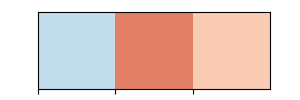

<IPython.core.display.Javascript object>


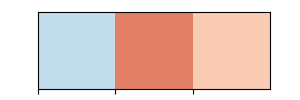

In [6]:
a3 = np.array(sns.color_palette("RdBu_r", n_colors=7))
# a3 = np.concatenate((a3[2,:],a3[4:,:]))
colorPallet3Post =(a3[[2,5,4],:])
sns.palplot(sns.color_palette(colorPallet3Post)) 

colorPallet3 =(a3[[2,5,4],:])
sns.palplot(sns.color_palette(colorPallet3))

In [10]:
# plot Get statistics for Gamma Power
df = pd.read_csv('J:\\lfp2ca_notNormalize\\sessions')
savePath = 'J:\\lfp2ca_notNormalize\\'
Pdf = pd.DataFrame(columns = ['Mouse','Period','Sess','CellType'])
cells = ['MSN']
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['0761_BaselineA']['Pre']['freq'][:]
f.close()
fr = {'high_Gamma':freq >= 60, 'low_Gamma':(freq >= 40) & (freq<60), 'high_Beta_15to20':(freq >= 15) & (freq<20),
         'Beta':(freq >= 10) & (freq<15),'theta':(freq >= 6) & (freq<8),'beta3':(freq >= 15) & (freq<18),
         'beta4':(freq >= 20) & (freq<25)}
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
t200 = (tPlot >0) & (tPlot<0.2)
for sess in df.sess.unique():
    m = sess[:4]
    period = periodCalc(df[df.sess==sess].day.values)
    cellType = df[df.sess==sess].cre.values[0]
    try: 
        #tDict = {'Mouse':m,'Period':period,'Sess':sess,'CellType':cellType,'drug':drug}
        A = pickle.load(open(savePath+'MSN\\'+sess,'rb'))
        A[A==9999] = np.nan
        A[A==-9999] = np.nan

        mu = np.nanmean(A[:int(A.shape[0]/2),:,:],axis=0)
        Std = np.nanstd(A[:int(A.shape[0]/2),:,:],axis=0)
        A =(A-mu)/Std
        data = []
        cols = []
        for f in ['high_Gamma','Beta']:
            highGamma = fr[f]
            A2 = A[t200,:,:][:,highGamma,:]
            b = np.arange(A2.shape[2])
            A2 = np.nanmean(np.nanmean(A2,axis = 0),axis=0)
            cols.append(f)
            data.append(A2)
        data.append(b)
        cols.append('cellNum')
        df2 = pd.DataFrame(np.array(data).T,columns = cols)
        df2['Mouse']=m
        df2['Period'] = period
        df2['Sess'] = sess
        df2['CellType'] = 'MSN'

        Pdf = pd.concat([Pdf,df2])
            
        del A,b


        #jumpBackhere
    except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess, " - MSN failed at line ",  exc_tb.tb_lineno)
            

Pdf.to_csv(figFolder+'powerElevation.csv')

<ipython-input-10-2a99bb9c7c6e>:25: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(A[:int(A.shape[0]/2),:,:],axis=0)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-10-2a99bb9c7c6e>:34: RuntimeWarning: Mean of empty slice
  A2 = np.nanmean(np.nanmean(A2,axis = 0),axis=0)


0761_day1  - MSN failed at line  21


In [67]:
# print(Pdf[Pdf.gamma>.75].groupby('Period').gamma.count()/Pdf.groupby('Period').gamma.count())
# print(Pdf[Pdf.gamma>.75].groupby(['Mouse','Period']).gamma.count()/Pdf.groupby(['Mouse','Period']).gamma.count())
Pdf = pd.read_csv(figFolder+'powerElevation.csv')
df = pd.read_csv('D:\\6OHDA\\submission2\\rotation_forR.csv')
df = df.groupby(['Session','Period']).mean()
df = df.reset_index()
df = df.rename(columns={"Session":'Sess'})
df['rot_ratio'] = df.apply(lambda x: x.percent_high_C/x.percent_high_AC if x.percent_high_AC else np.inf, axis=1)
df2 = pd.merge(Pdf,df[['Sess','Period','rot_ratio','percent_high_C','percent_high_AC']],on=['Sess','Period'])
df2

Unnamed: 0  Mouse   Period            Sess CellType  high_Gamma  \
0               0    761  Healthy  0761_BaselineA      MSN    0.609678   
1               1    761  Healthy  0761_BaselineA      MSN    0.588062   
2               2    761  Healthy  0761_BaselineA      MSN   -0.609845   
3               3    761  Healthy  0761_BaselineA      MSN    0.127735   
4               4    761  Healthy  0761_BaselineA      MSN   -0.131804   
...           ...    ...      ...             ...      ...         ...   
23879          91   8815    Acute       8815_day8      MSN    0.069834   
23880          92   8815    Acute       8815_day8      MSN   -0.356497   
23881          93   8815    Acute       8815_day8      MSN    0.495589   
23882          94   8815    Acute       8815_day8      MSN   -0.250004   
23883          95   8815    Acute       8815_day8      MSN    0.308857   

           Beta  cellNum  rot_ratio  percent_high_C  percent_high_AC  
0     -0.292439      0.0   2.754491        0.115976         0.042104  
1      1.032065      1.0   2.754491        0.115976         0.042104  
2      2.115928      2.0   2.754491        0.115976         0.042104  
3      0.453791      3.0   2.754491        0.115976         0.042104  
4      0.015456      4.0   2.754491        0.115976         0.042104  
...         ...      ...        ...             ...              ...  
23879 -0.376164     91.0   1.545977        0.067815         0.043866  
23880  2.129597     92.0   1.545977        0.067815         0.043866  
23881 -0.654838     93.0   1.545977        0.067815         0.043866  
23882  0.038064     94.0   1.545977        0.067815         0.043866  
23883 -0.870801     95.0   1.545977        0.067815         0.043866  

[23884 rows x 11 columns]

<IPython.core.display.Javascript object>


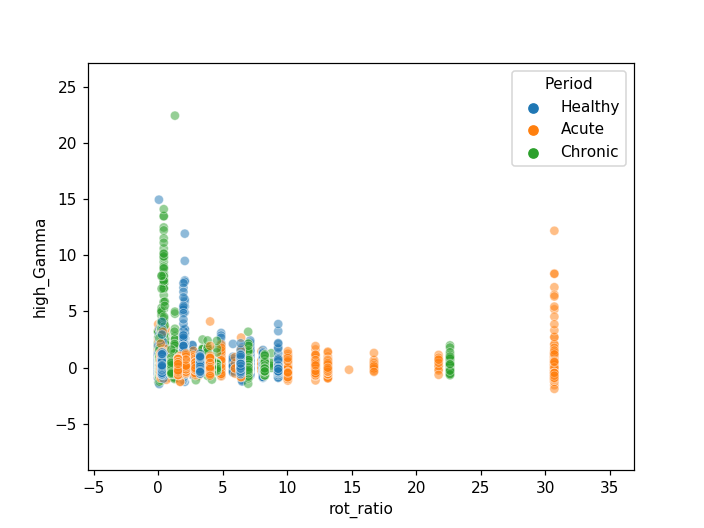

In [69]:
sns.scatterplot(data=df2,x='rot_ratio',y='high_Gamma',hue='Period',alpha=0.5)

<IPython.core.display.Javascript object>


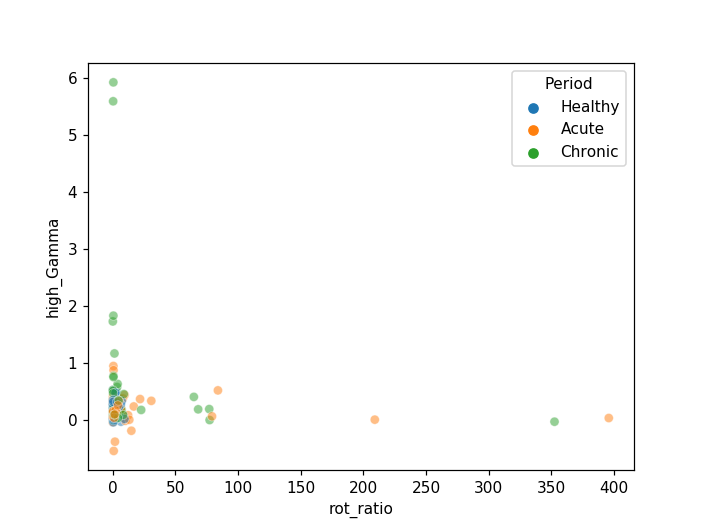

In [50]:
df3 = df2.groupby(['Sess','Period']).mean().reset_index()
sns.scatterplot(data=df3,x='rot_ratio',y='high_Gamma',hue='Period',alpha=0.5)

<IPython.core.display.Javascript object>


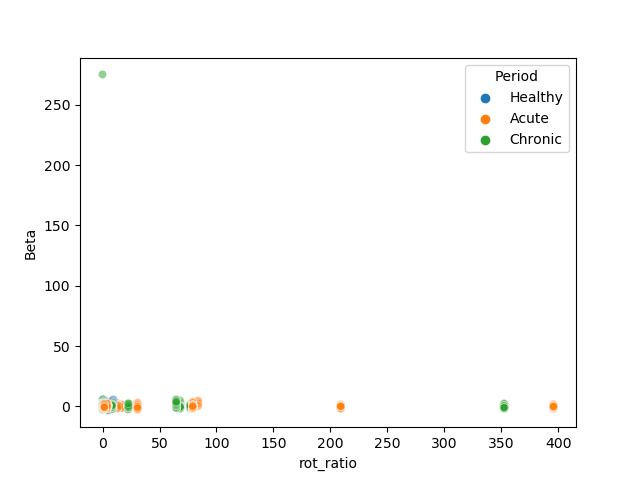

In [34]:
sns.scatterplot(data=df2,x='rot_ratio',y='Beta',hue='Period',alpha=0.5)

<IPython.core.display.Javascript object>


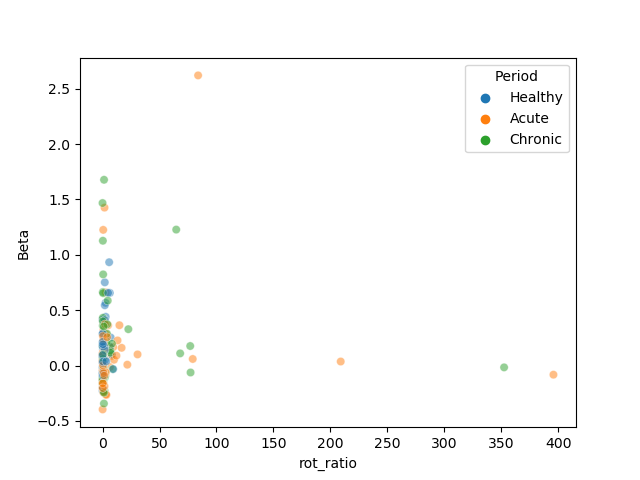

In [35]:
sns.scatterplot(data=df3,x='rot_ratio',y='Beta',hue='Period',alpha=0.5)

In [40]:
df = df[(df.cre=='PV')&(df.numred>0)]
df

Unnamed: 0  mouse            sess  day   period cre  numred  numMsn
44           44   1236  1236_BaselineA    0  Healthy  PV       2   153.0
45           45   1236  1236_BaselineL    0  Healthy  PV       1   121.0
46           46   1236  1236_BaselineS    0  Healthy  PV       2   178.0
47           47   1236       1236_day1    1    Acute  PV       2   130.0
48           48   1236      1236_day11   11    Acute  PV       1   101.0
..          ...    ...             ...  ...      ...  ..     ...     ...
191         191   8803       8803_day2    2    Acute  PV       1   103.0
193         193   8803     8803_day34L   34  Chronic  PV       1    91.0
194         194   8803       8803_day4    4    Acute  PV       1   110.0
196         196   8803       8803_day6    6    Acute  PV       1    69.0
197         197   8803       8803_day8    8    Acute  PV       2   131.0

[83 rows x 8 columns]

In [41]:
# plot Get statistics for Gamma Power
df = pd.read_csv('J:\\lfp2ca_notNormalize\\sessions')
savePath = 'J:\\lfp2ca_notNormalize\\'
Pdf = pd.DataFrame(columns = ['Mouse','Period','Sess','CellType'])
cells = ['CRE']
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['0761_BaselineA']['Pre']['freq'][:]
f.close()
fr = {'high_Gamma':freq >= 60, 'low_Gamma':(freq >= 40) & (freq<60), 'high_Beta_15to20':(freq >= 15) & (freq<20),
         'Beta':(freq >= 10) & (freq<15),'theta':(freq >= 6) & (freq<8),'beta3':(freq >= 15) & (freq<18),
         'beta4':(freq >= 20) & (freq<25)}
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
t200 = (tPlot >0) & (tPlot<0.2)
df = df[(df.cre=='PV')&(df.numred>0)]
for sess in df.sess.unique():
    m = sess[:4]
    period = periodCalc(df[df.sess==sess].day.values)
    cellType = df[df.sess==sess].cre.values[0]
    try: 
        #tDict = {'Mouse':m,'Period':period,'Sess':sess,'CellType':cellType,'drug':drug}
        A = pickle.load(open(savePath+'CRE\\'+sess,'rb'))
        A[A==9999] = np.nan
        A[A==-9999] = np.nan

        mu = np.nanmean(A[:int(A.shape[0]/2),:,:],axis=0)
        Std = np.nanstd(A[:int(A.shape[0]/2),:,:],axis=0)
        A =(A-mu)/Std
        data = []
        cols = []
        for f in ['high_Gamma','Beta']:
            highGamma = fr[f]
            A2 = A[t200,:,:][:,highGamma,:]
            b = np.arange(A2.shape[2])
            A2 = np.nanmean(np.nanmean(A2,axis = 0),axis=0)
            cols.append(f)
            data.append(A2)
        data.append(b)
        cols.append('cellNum')
        df2 = pd.DataFrame(np.array(data).T,columns = cols)
        df2['Mouse']=m
        df2['Period'] = period
        df2['Sess'] = sess
        df2['CellType'] = 'PV'

        Pdf = pd.concat([Pdf,df2])
            
        del A,b


        #jumpBackhere
    except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess, " - PV failed at line ",  exc_tb.tb_lineno)
            

Pdf.to_csv(figFolder+'powerElevation_PV.csv')

1236_BaselineL  - PV failed at line  22
1236_day1  - PV failed at line  22
1236_day3  - PV failed at line  22
1236_day7  - PV failed at line  22
4539_day15A  - PV failed at line  22
4539_day4  - PV failed at line  22
4539_day6  - PV failed at line  22
4539_day7  - PV failed at line  22
7584_BaselineA  - PV failed at line  22
7584_day10  - PV failed at line  22
7584_day4  - PV failed at line  22
7909_day0  - PV failed at line  22
7909_day10  - PV failed at line  22
7909_day11  - PV failed at line  22
7909_day12  - PV failed at line  22
7909_day14  - PV failed at line  22
7909_day15A  - PV failed at line  22
7909_day4  - PV failed at line  22
7909_day5  - PV failed at line  22
7909_day6  - PV failed at line  22
7909_day7  - PV failed at line  22


<ipython-input-41-621d8b58417a>:26: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(A[:int(A.shape[0]/2),:,:],axis=0)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-41-621d8b58417a>:35: RuntimeWarning: Mean of empty slice
  A2 = np.nanmean(np.nanmean(A2,axis = 0),axis=0)


8430_BaselineS  - PV failed at line  22
8430_day11  - PV failed at line  22
8803_BaselineS  - PV failed at line  22
8803_day14  - PV failed at line  22


In [42]:
# print(Pdf[Pdf.gamma>.75].groupby('Period').gamma.count()/Pdf.groupby('Period').gamma.count())
# print(Pdf[Pdf.gamma>.75].groupby(['Mouse','Period']).gamma.count()/Pdf.groupby(['Mouse','Period']).gamma.count())
df = pd.read_csv('D:\\6OHDA\\submission2\\rotation_forR.csv')
df = df.groupby(['Session','Period']).mean()
df = df.reset_index()
df = df.rename(columns={"Session":'Sess'})
df['rot_ratio'] = df.apply(lambda x: x.percent_high_C/x.percent_high_AC if x.percent_high_AC else np.inf, axis=1)
df2 = pd.merge(Pdf,df[['Sess','Period','rot_ratio','percent_high_C','percent_high_AC']],on=['Sess','Period'])
df2

Mouse   Period            Sess CellType  high_Gamma      Beta  cellNum  \
0   1236  Healthy  1236_BaselineA       PV    0.211399 -0.659497      0.0   
1   1236  Healthy  1236_BaselineA       PV   -0.597512  0.826124      1.0   
2   1236  Healthy  1236_BaselineS       PV   -0.185596 -1.669573      0.0   
3   1236  Healthy  1236_BaselineS       PV    0.400708 -0.368433      1.0   
4   1236    Acute      1236_day11       PV   -0.209928  0.420393      0.0   
..   ...      ...             ...      ...         ...       ...      ...   
95  8803  Chronic     8803_day34L       PV    0.609271 -0.760771      0.0   
96  8803    Acute       8803_day4       PV   -0.628675 -0.453105      0.0   
97  8803    Acute       8803_day6       PV   -0.176258 -0.712500      0.0   
98  8803    Acute       8803_day8       PV    0.615875 -0.489758      0.0   
99  8803    Acute       8803_day8       PV   -0.419786 -0.819961      1.0   

    rot_ratio  percent_high_C  percent_high_AC  
0    0.064204        0.008908         0.138751  
1    0.064204        0.008908         0.138751  
2    0.065789        0.010085         0.153290  
3    0.065789        0.010085         0.153290  
4    0.079275        0.005883         0.074208  
..        ...             ...              ...  
95        inf        0.007479         0.000000  
96   1.715517        0.016724         0.009749  
97   0.211009        0.001970         0.009337  
98   0.212121        0.003530         0.016640  
99   0.212121        0.003530         0.016640  

[100 rows x 10 columns]

<IPython.core.display.Javascript object>


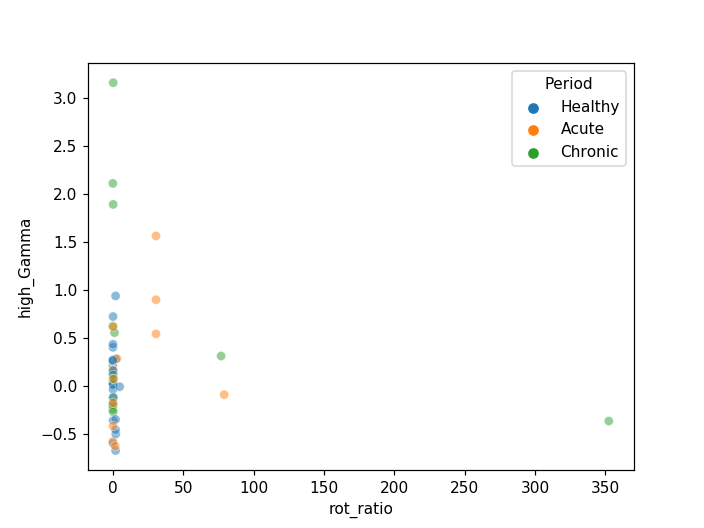

In [43]:
sns.scatterplot(data=df2,x='rot_ratio',y='high_Gamma',hue='Period',alpha=0.5)

<IPython.core.display.Javascript object>


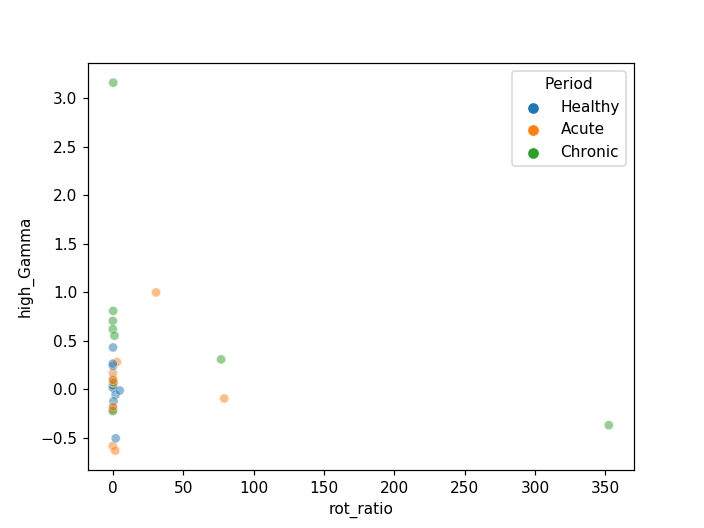

In [44]:
df3 = df2.groupby(['Sess','Period']).mean().reset_index()
sns.scatterplot(data=df3,x='rot_ratio',y='high_Gamma',hue='Period',alpha=0.5)

<IPython.core.display.Javascript object>


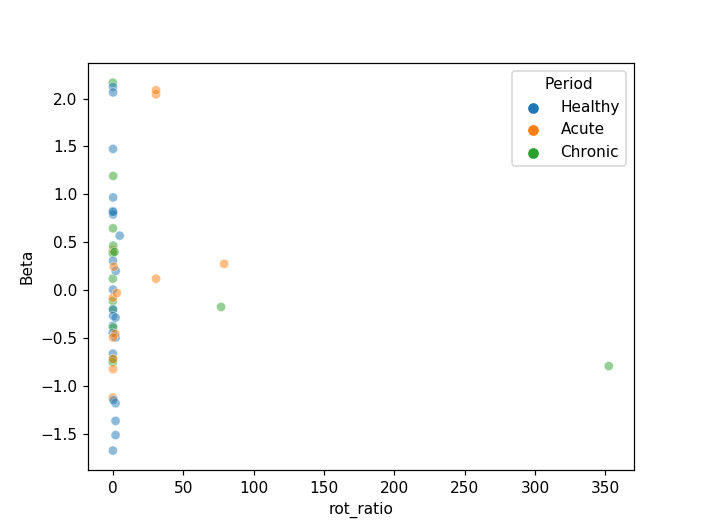

In [46]:
sns.scatterplot(data=df2,x='rot_ratio',y='Beta',hue='Period',alpha=0.5)

In [85]:
Pdf[Pdf.Period=='Healthy'].high_Gamma.quantile(.95)

0.4555698338418128

In [94]:
Pdf = pd.read_csv(figFolder+'powerElevation.csv')
th = Pdf[Pdf.Period=='Healthy'].high_Gamma.quantile(.95)
Pdf['gammaPercent'] = Pdf.high_Gamma.apply(lambda x: x>=th)
Pdf =Pdf.groupby(['Sess','Period']).mean()
Pdf = Pdf.reset_index()
Pdf['Mouse']=Pdf['Mouse'].astype(int)
Pdf.dtypes

Sess             object
Period           object
Unnamed: 0      float64
Mouse             int32
high_Gamma      float64
Beta            float64
cellNum         float64
gammaPercent    float64
dtype: object

In [89]:
df = pd.read_csv('D:\\6OHDA\\submission2\\rotation_forR.csv')
df = df.groupby(['Session','Period']).mean()
df = df.reset_index()
df = df.rename(columns={"Session":'Sess'})
df['rot_ratio'] = df.apply(lambda x: x.percent_high_C/x.percent_high_AC if x.percent_high_AC else np.inf, axis=1)
df2 = pd.merge(Pdf,df[['Sess','Period','rot_ratio','percent_high_C','percent_high_AC']],on=['Sess','Period'])
df2

Sess   Period  Unnamed: 0  Mouse  high_Gamma      Beta  \
0    0761_BaselineA  Healthy         5.0    761    0.427110  0.440103   
1    0761_BaselineL  Healthy         7.5    761    0.362527  0.932953   
2    0761_BaselineS  Healthy        13.0    761    0.491119  0.566564   
3        0761_day10    Acute         5.5    761    0.360169  0.007634   
4        0761_day12    Acute         2.0    761    0.121943  0.171254   
..              ...      ...         ...    ...         ...       ...   
206     8815_day30A  Chronic        39.0   8815    0.169259  0.328188   
207     8815_day34L  Chronic        33.5   8815    0.085633  0.351990   
208       8815_day4    Acute        18.0   8815    0.249947  0.256764   
209       8815_day6    Acute         4.5   8815    0.267367  0.404598   
210       8815_day8    Acute        47.5   8815    0.091639 -0.090808   

     cellNum  gammaPercent  rot_ratio  percent_high_C  percent_high_AC  
0        5.0      0.181818   2.754491        0.115976         0.042104  
1        7.5      0.062500   5.800546        0.178418         0.030759  
2       13.0      0.222222   2.660000        0.178839         0.067233  
3        5.5      0.083333  21.743590        0.142533         0.006555  
4        2.0      0.000000   5.959459        0.074118         0.012437  
..       ...           ...        ...             ...              ...  
206     39.0      0.063291  22.625000        0.045630         0.002017  
207     33.5      0.014706   1.027132        0.044538         0.043361  
208     18.0      0.081081   4.031949        0.106050         0.026303  
209      4.5      0.200000        inf        0.080138         0.000000  
210     47.5      0.000000   1.545977        0.067815         0.043866  

[211 rows x 11 columns]

In [50]:
%matplotlib inline

<IPython.core.display.Javascript object>


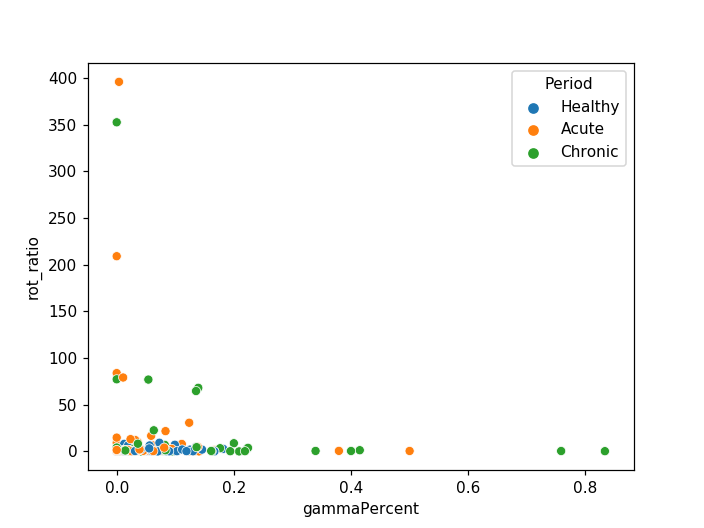

<IPython.core.display.Javascript object>


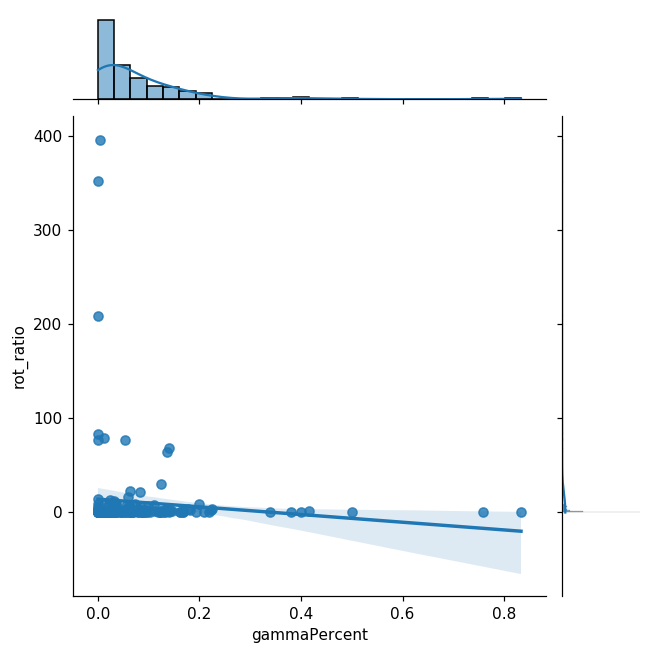

0.010591508085949688


In [92]:
sns.scatterplot(x='gammaPercent',y='rot_ratio',hue = 'Period',data = df2)
def r2(x, y):
    return sci.stats.pearsonr(x, y)[0] ** 2
# m = df2.loc[df2['rot_ratio'] != np.inf, 'rot_ratio'].max()
df2['rot_ratio'].replace(np.inf,np.nan,inplace=True)
df2 = df2.dropna()


sns.jointplot(x='gammaPercent',y='rot_ratio',data = df2, kind="reg")
print(r2(df2.gammaPercent,df2.rot_ratio))

<IPython.core.display.Javascript object>


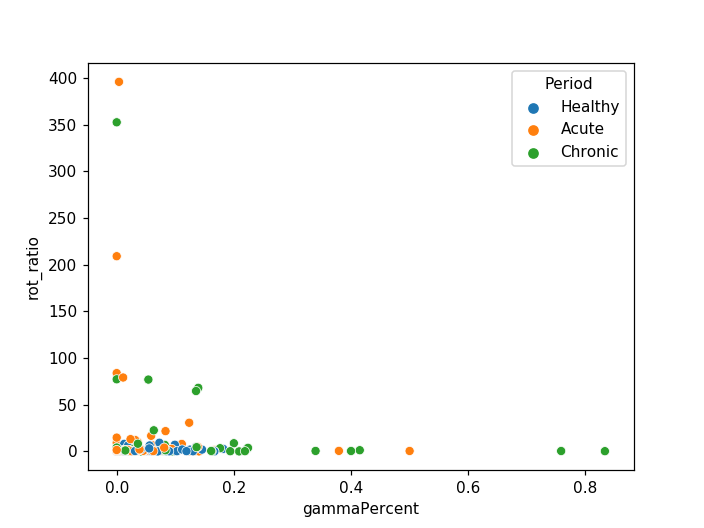

<IPython.core.display.Javascript object>


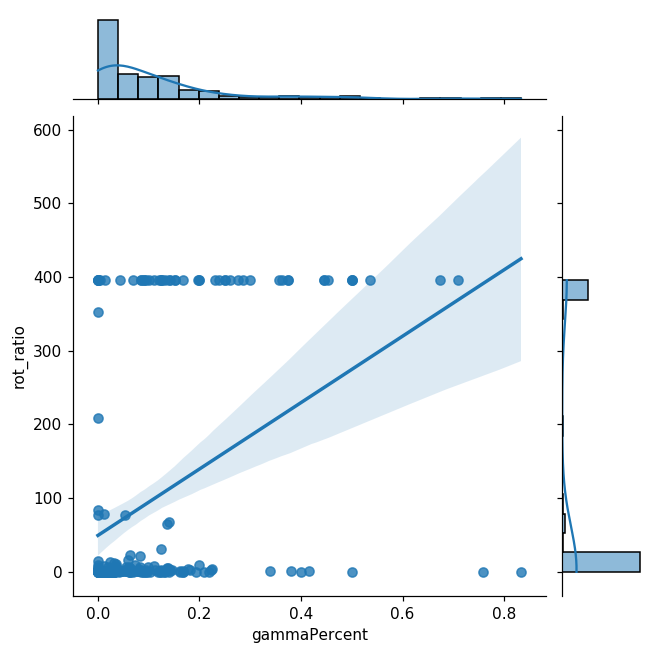

0.15588874243886766


In [88]:
sns.scatterplot(x='gammaPercent',y='rot_ratio',hue = 'Period',data = df2)
def r2(x, y):
    return sci.stats.pearsonr(x, y)[0] ** 2
m = df2.loc[df2['rot_ratio'] != np.inf, 'rot_ratio'].max()
df2['rot_ratio'].replace(np.inf,m,inplace=True)



sns.jointplot(x='gammaPercent',y='rot_ratio',data = df2, kind="reg")
print(r2(df2.gammaPercent,df2.rot_ratio))

In [95]:
Pdf = pd.read_csv(figFolder+'powerElevation_PV.csv')
th = Pdf[Pdf.Period=='Healthy'].high_Gamma.quantile(.95)
Pdf['gammaPercent'] = Pdf.high_Gamma.apply(lambda x: x>=th)
Pdf =Pdf.groupby(['Sess','Period']).mean()
Pdf = Pdf.reset_index()
Pdf['Mouse']=Pdf['Mouse'].astype(int)
Pdf.dtypes

df = pd.read_csv('D:\\6OHDA\\submission2\\rotation_forR.csv')
df = df.groupby(['Session','Period']).mean()
df = df.reset_index()
df = df.rename(columns={"Session":'Sess'})
df['rot_ratio'] = df.apply(lambda x: x.percent_high_C/x.percent_high_AC if x.percent_high_AC else np.inf, axis=1)
df2 = pd.merge(Pdf,df[['Sess','Period','rot_ratio','percent_high_C','percent_high_AC']],on=['Sess','Period'])
df2

Sess   Period  Unnamed: 0  Mouse  high_Gamma      Beta  \
0    1236_BaselineA  Healthy         0.5   1236   -0.193056  0.083314   
1    1236_BaselineS  Healthy         0.5   1236    0.107556 -1.019003   
2        1236_day11    Acute         0.0   1236   -0.209928  0.420393   
3        1236_day13  Chronic         1.0   1236    0.705415  0.611861   
4       1236_day15A  Chronic         0.0   1236    0.033116 -0.747533   
5       1236_day30A  Chronic         0.0   1236    0.621395  0.122048   
6       1236_day35L  Chronic         0.5   1236   -0.222632 -0.153495   
7         1236_day5    Acute         0.0   1236    0.169368 -0.076570   
8         1236_day9    Acute         0.0   1236   -0.581634 -1.116754   
9   4539_Baseline2A  Healthy         0.0   4539    0.016754  2.121566   
10   4539_BaselineA  Healthy         1.5   4539    0.042535  0.323657   
11        4539_day0  Healthy         0.0   4539   -0.502661  0.204176   
12        4539_day1    Acute         0.0   4539   -0.318170 -0.840942   
13       4539_day10    Acute         0.5   4539    3.445277 -0.026412   
14       4539_day12    Acute         0.5   4539    5.901775  0.938091   
15       4539_day13  Chronic         0.0   4539    8.395665  0.250498   
16       4539_day14  Chronic         0.0   4539   11.783475  0.337026   
17        4539_day2    Acute         0.0   4539    9.371866  0.136908   
18        4539_day3    Acute         0.0   4539    7.690543 -0.324594   
19      4539_day30A  Chronic         0.0   4539    3.156989  0.466532   
20        4539_day8    Acute         1.0   4539    7.380933  0.128959   
21        4539_day9    Acute         0.5   4539    5.092776  0.485274   
22   7584_Baseline0  Healthy         1.5   7584    0.241327  1.166182   
23        7584_day1    Acute         1.0   7584    0.893543  1.630240   
24       7584_day11    Acute         2.0   7584    0.951458  0.108011   
25       7584_day12    Acute         0.5   7584    0.367936  0.474114   
26       7584_day15  Chronic         1.0   7584   -0.065974 -0.238756   
27        7584_day2    Acute         0.0   7584    0.463068  0.387883   
28        7584_day3    Acute         0.0   7584   -0.643371  0.917365   
29      7584_day30A  Chronic         0.5   7584    0.808816  0.402653   
30        7584_day5    Acute         0.5   7584   -0.603706  1.202594   
31        7584_day6    Acute         0.5   7584   -0.446741 -0.582658   
32        7584_day7    Acute         0.5   7584    0.703538  0.126526   
33        7584_day8    Acute         1.0   7584    0.598562  0.566798   
34        7584_day9    Acute         1.5   7584    0.250437 -0.091704   
35  7909_Baseline2A  Healthy         2.0   7909   -0.053659 -0.963630   
36   7909_BaselineA  Healthy         0.0   7909   -0.010033  0.570542   
37        7909_day1    Acute         0.0   7909    6.763524  1.368749   
38       7909_day13  Chronic         0.0   7909    0.234422  0.152768   
39        7909_day2    Acute         0.0   7909   -0.358266 -0.350062   
40        7909_day3    Acute         0.5   7909   -0.198935 -0.120602   
41        7909_day8    Acute         0.0   7909         NaN       NaN   
42        7909_day9    Acute         0.0   7909    4.653187 -0.362432   
43   8430_BaselineL  Healthy         0.0   8430    0.432495  0.008625   
44      8430_day19L  Chronic         0.0   8430    0.553423  0.401091   
45        8430_day3    Acute         0.0   8430    0.282458 -0.026973   
46      8430_day30A  Chronic         0.0   8430   -0.367191 -0.788689   
47      8430_day35L  Chronic         0.0   8430    0.309993 -0.172281   
48        8430_day5    Acute         1.0   8430    0.999036  1.417283   
49        8430_day7    Acute         0.0   8430   -0.092755  0.277240   
50   8803_BaselineA  Healthy         0.0   8803   -0.121644 -1.145002   
51   8803_BaselineL  Healthy         0.0   8803    0.265612 -0.444266   
52      8803_day19L  Chronic         0.0   8803    0.072979  0.647090   
53        8803_day2    Acute         0.0   8803    0.071674  0.248048   


<IPython.core.display.Javascript object>


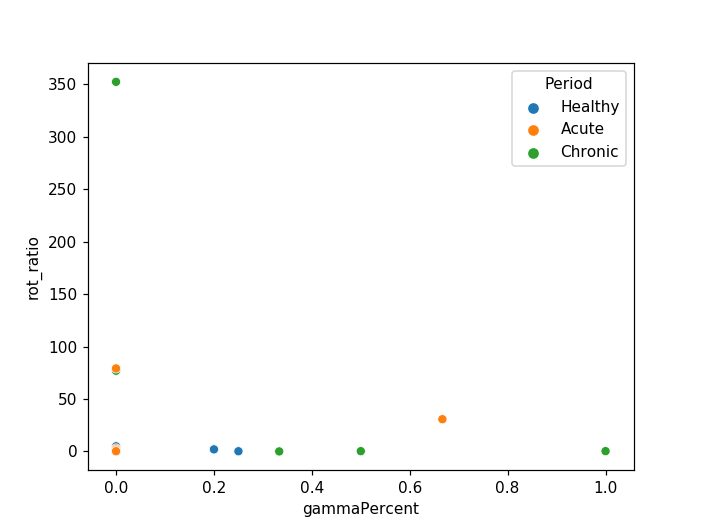

<IPython.core.display.Javascript object>


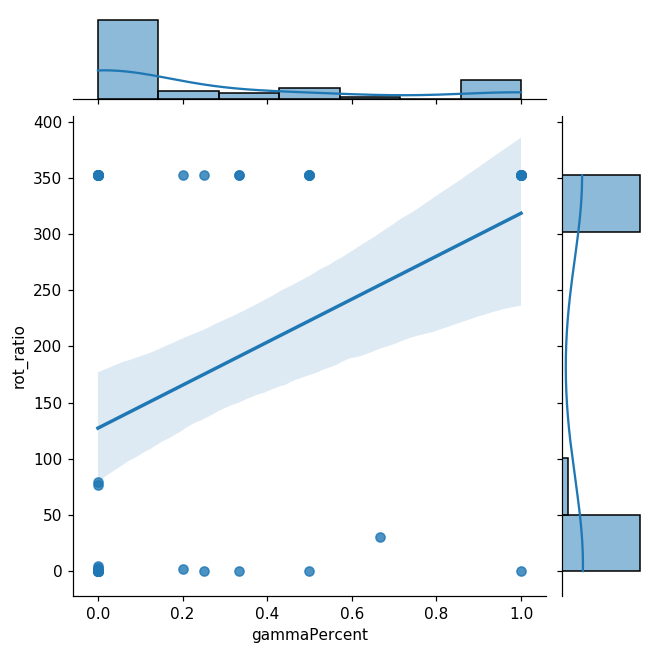

0.16434951259430725


In [96]:
sns.scatterplot(x='gammaPercent',y='rot_ratio',hue = 'Period',data = df2)
def r2(x, y):
    return sci.stats.pearsonr(x, y)[0] ** 2
m = df2.loc[df2['rot_ratio'] != np.inf, 'rot_ratio'].max()
df2['rot_ratio'].replace(np.inf,m,inplace=True)



sns.jointplot(x='gammaPercent',y='rot_ratio',data = df2, kind="reg")
print(r2(df2.gammaPercent,df2.rot_ratio))

In [117]:
# add speed data:
f = h5py.File('D:\\6OHDA\\Spectograms.hdf5','r') 
df = pd.DataFrame(columns = ['Mouse','Period','Sess'])
for m in tqdm(miceList):
    data =  getData(Files[0],['lfp'],period ='Pre', mice=m)
    for sess in data:
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        period = periodCalc(day)
        # get data
        freq = f[m][sess]['Pre']['freq'][:]
        coeff = np.abs(f[m][sess]['Pre']['coeff'][:])
        lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
        coeff = coeff[:,(lfpOutliers[:,0]==0)]
        Hs = np.nansum(coeff, axis=0)
        coeff = coeff/Hs
        coeff = np.sum(coeff,axis=1)
        frquencies = {'high_Gamma':freq > 60, 'low_Gamma':(freq >= 40) & (freq<60), 'high_Beta_15to20':(freq >= 15) & (freq<20),
         'Beta':(freq >= 10) & (freq<15),'theta':(freq >= 6) & (freq<8),'beta3':(freq >= 15) & (freq<18),
         'beta4':(freq >= 20) & (freq<25)}
        df2 = pd.DataFrame([{'Mouse':m,'Period':period,'Sess':sess}])
        for fr in frquencies.keys():
            df2[fr]  =np.sum(coeff[frquencies[fr]])
        
        df = pd.concat([df,df2])
            

df.to_csv(figFolder+'powerAll.csv')

        

                

                


  0%|                                                                                           | 0/16 [00:00<?, ?it/s]D:\6OHDA\IO.py:48: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  lfp = hf[m][s]['ePhys']['lfp'].value


cleaning up lfp data


  6%|█████▏                                                                            | 1/16 [02:07<31:46, 127.08s/it]

cleaning up lfp data
I deleted session: 1208_day12
found  17.0  outlier points


 12%|██████████▎                                                                       | 2/16 [04:06<29:05, 124.70s/it]

cleaning up lfp data


 19%|███████████████▍                                                                  | 3/16 [06:14<27:13, 125.68s/it]

cleaning up lfp data


 25%|████████████████████▊                                                              | 4/16 [06:42<19:15, 96.32s/it]

cleaning up lfp data
found  1.0  outlier points
found  888231.0  outlier points
found  481139.0  outlier points


 31%|█████████████████████████▋                                                        | 5/16 [08:48<19:19, 105.43s/it]

cleaning up lfp data


 38%|███████████████████████████████▏                                                   | 6/16 [09:16<13:41, 82.17s/it]

cleaning up lfp data


 44%|████████████████████████████████████▎                                              | 7/16 [11:24<14:23, 95.97s/it]

cleaning up lfp data
I deleted session: 2976_day4
found  1.0  outlier points
found  3.0  outlier points


 50%|█████████████████████████████████████████                                         | 8/16 [13:24<13:44, 103.08s/it]

cleaning up lfp data


 56%|██████████████████████████████████████████████▏                                   | 9/16 [15:32<12:54, 110.60s/it]

cleaning up lfp data
found  50.0  outlier points


 62%|██████████████████████████████████████████████████▋                              | 10/16 [17:37<11:30, 115.00s/it]

cleaning up lfp data
found  29.0  outlier points


 69%|███████████████████████████████████████████████████████▋                         | 11/16 [20:27<10:57, 131.45s/it]

cleaning up lfp data


 75%|████████████████████████████████████████████████████████████▊                    | 12/16 [23:00<09:11, 137.92s/it]

cleaning up lfp data


 81%|█████████████████████████████████████████████████████████████████▊               | 13/16 [25:52<07:24, 148.18s/it]

cleaning up lfp data


 88%|██████████████████████████████████████████████████████████████████████▉          | 14/16 [27:51<04:38, 139.36s/it]

cleaning up lfp data


 94%|███████████████████████████████████████████████████████████████████████████▉     | 15/16 [30:00<02:16, 136.25s/it]

cleaning up lfp data


100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [32:06<00:00, 120.38s/it]


In [288]:
Pdf = pd.read_csv(figFolder+'powerAll.csv')
df = pd.read_csv('D:\\6OHDA\\submission2\\rotation_forR.csv')
df = df.groupby(['Session','Period']).mean()
df = df.reset_index()
df = df.rename(columns={"Session":'Sess'})
df['rot_ratio'] = df.apply(lambda x: x.percent_high_C/x.percent_high_AC if x.percent_high_AC else np.inf, axis=1)
df2 = pd.merge(Pdf,df[['Sess','Period','rot_ratio','percent_high_C','percent_high_AC']],on=['Sess','Period'])
df2

Unnamed: 0  Mouse   Period            Sess     high_Gamma      low_Gamma  \
0             0    761  Healthy  0761_BaselineA  284211.408564  350826.324881   
1             0    761  Healthy  0761_BaselineL  280047.653249  361235.781734   
2             0    761  Healthy  0761_BaselineS  292845.282870  358398.741147   
3             0    761    Acute       0761_day1  294771.797589  369754.719773   
4             0    761    Acute      0761_day10  282477.290004  348546.441241   
..          ...    ...      ...             ...            ...            ...   
207           0   8815  Chronic     8815_day30A  281343.917717  294042.854253   
208           0   8815  Chronic     8815_day34L  298141.912865  319938.482435   
209           0   8815    Acute       8815_day4  234967.483177  281742.654944   
210           0   8815    Acute       8815_day6  234914.012194  261589.578383   
211           0   8815    Acute       8815_day8  288338.783670  310200.960158   

     high_Beta_15to20           Beta          theta          beta3  \
0       150738.511980  182491.449820  162932.543450   92849.054532   
1       150346.825250  180169.318377  154329.632958   92629.567512   
2       142778.122934  173342.728840  173594.244107   87486.225642   
3       144585.423761  172710.332961  154518.303915   88387.227225   
4       151442.112026  184109.550346  152222.263510   94598.614161   
..                ...            ...            ...            ...   
207     168414.018997  214475.851908  161768.992184  105250.901651   
208     159615.961967  201150.652218  145236.300669   99089.204018   
209     185227.813834  242151.594720  144068.753684  116964.613349   
210     148899.937002  198480.348022  152183.599294   94169.191240   
211     167652.156141  205634.132158  165360.914688  106167.722817   

             beta4  rot_ratio  percent_high_C  percent_high_AC  
0    135543.142359   2.754491        0.115976         0.042104  
1    136047.703435   5.800546        0.178418         0.030759  
2    132776.779306   2.660000        0.178839         0.067233  
3    132552.552067   8.133550        0.209850         0.025800  
4    136404.963207  21.743590        0.142533         0.006555  
..             ...        ...             ...              ...  
207  137509.627471  22.625000        0.045630         0.002017  
208  135143.457916   1.027132        0.044538         0.043361  
209  144999.211092   4.031949        0.106050         0.026303  
210  118001.796964        inf        0.080138         0.000000  
211  135865.603918   1.545977        0.067815         0.043866  

[212 rows x 14 columns]

<IPython.core.display.Javascript object>


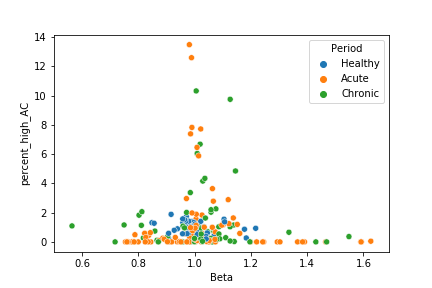

<IPython.core.display.Javascript object>


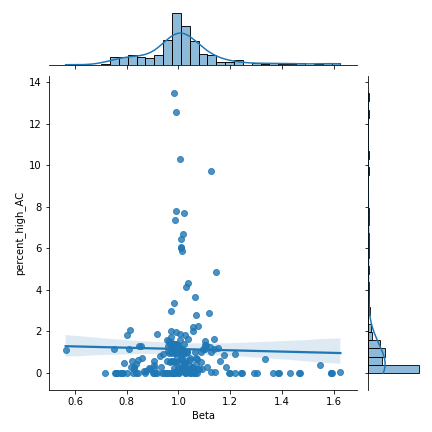

0.0005907911708443936


In [299]:
col = 'Beta'
col2  = 'percent_high_AC'

df2['rot_ratio'].replace(np.inf,np.nan,inplace=True)
df3 = df2
df3[col] = df3.apply(lambda x: x[col]/df3[(df3.Period=='Healthy')&(df3.Mouse==x.Mouse)][col].mean(),axis=1 )
df3[col2] = df3.apply(lambda x: x[col2]/df3[(df3.Period=='Healthy')&(df3.Mouse==x.Mouse)][col2].mean(),axis=1 )

sns.scatterplot(x=col,y=col2,hue = 'Period',data = df3)
sns.jointplot(x=col,y=col2,data = df3, kind="reg")
df4 = df3[[col,col2]].dropna()
print(r2(df4[col],df4[col2]))



<IPython.core.display.Javascript object>


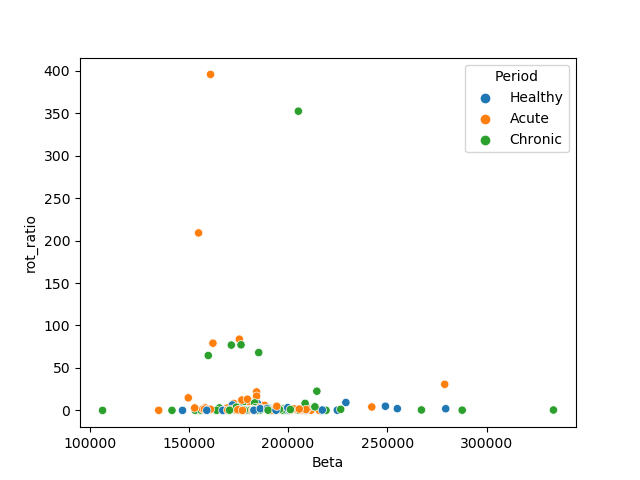

<IPython.core.display.Javascript object>


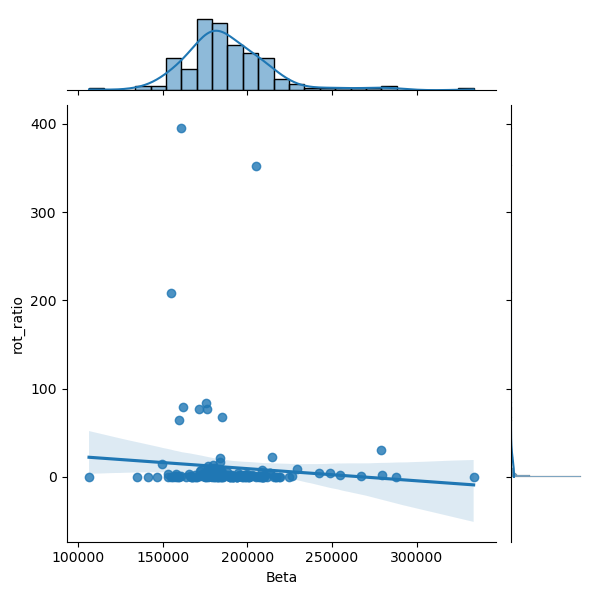

0.006901695421318086


In [130]:
sns.scatterplot(x='Beta',y='rot_ratio',hue = 'Period',data = df2)
sns.jointplot(x='Beta',y='rot_ratio',data = df2, kind="reg")
print(r2(df2.Beta,df2.rot_ratio))

In [132]:
df3 = df2[['Mouse','Period','Sess','high_Gamma','Beta']]
df3['high_Gamma'] = df3.apply(lambda x: x.high_Gamma/df3[(df3.Period=='Healthy')&(df3.Mouse==x.Mouse)].high_Gamma.mean(),axis=1 )
df3['Beta'] = df3.apply(lambda x: x.Beta/df3[(df3.Period=='Healthy')&(df3.Mouse==x.Mouse)].Beta.mean(),axis=1 )

<ipython-input-132-ee2334fce2ae>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['high_Gamma'] = df3.apply(lambda x: x.high_Gamma/df3[(df3.Period=='Healthy')&(df3.Mouse==x.Mouse)].high_Gamma.mean(),axis=1 )
<ipython-input-132-ee2334fce2ae>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Beta'] = df3.apply(lambda x: x.Beta/df3[(df3.Period=='Healthy')&(df3.Mouse==x.Mouse)].Beta.mean(),axis=1 )


In [134]:
df3 = pd.merge(df3,df[['Sess','Period','rot_ratio']],on=['Sess','Period'])
df3

Mouse   Period            Sess  high_Gamma      Beta  rot_ratio
0      761  Healthy  0761_BaselineA    0.994785  1.021401   2.754491
1      761  Healthy  0761_BaselineL    0.980211  1.008404   5.800546
2      761  Healthy  0761_BaselineS    1.025005  0.970196   2.660000
3      761    Acute       0761_day1    1.031748  0.966656   8.133550
4      761    Acute      0761_day10    0.988715  1.030457  21.743590
..     ...      ...             ...         ...       ...        ...
158   8815    Acute       8815_day2    0.827844  1.001578   1.015779
159   8815  Chronic     8815_day30A    0.922784  1.027746  22.625000
160   8815  Chronic     8815_day34L    0.977880  0.963893   1.027132
161   8815    Acute       8815_day4    0.770673  1.160365   4.031949
162   8815    Acute       8815_day8    0.945726  0.985377   1.545977

[163 rows x 6 columns]

<IPython.core.display.Javascript object>


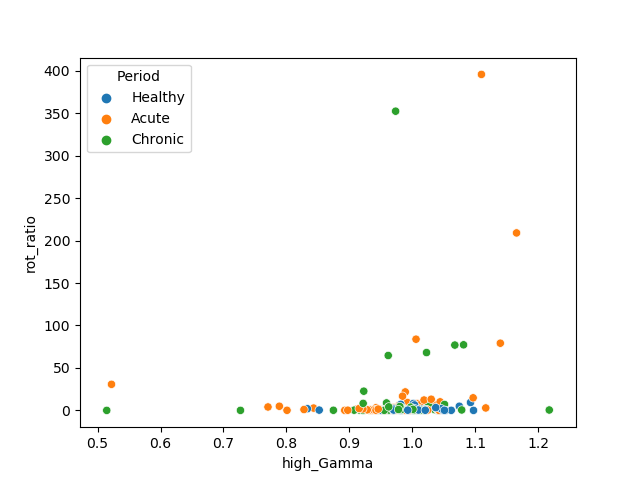

<IPython.core.display.Javascript object>


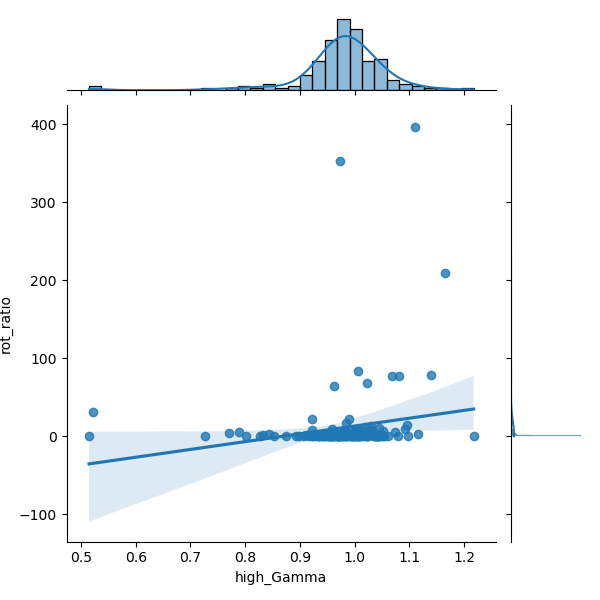

0.032660440743544523


In [135]:
sns.scatterplot(x='high_Gamma',y='rot_ratio',hue = 'Period',data = df3)
sns.jointplot(x='high_Gamma',y='rot_ratio',data = df3, kind="reg")
print(r2(df3.high_Gamma,df3.rot_ratio))

<IPython.core.display.Javascript object>


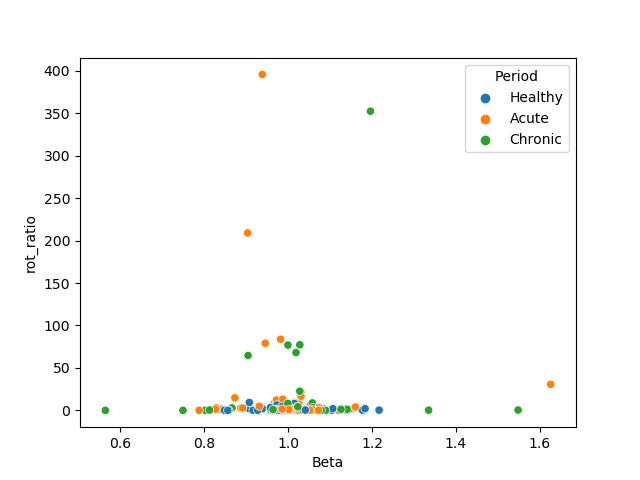

<IPython.core.display.Javascript object>


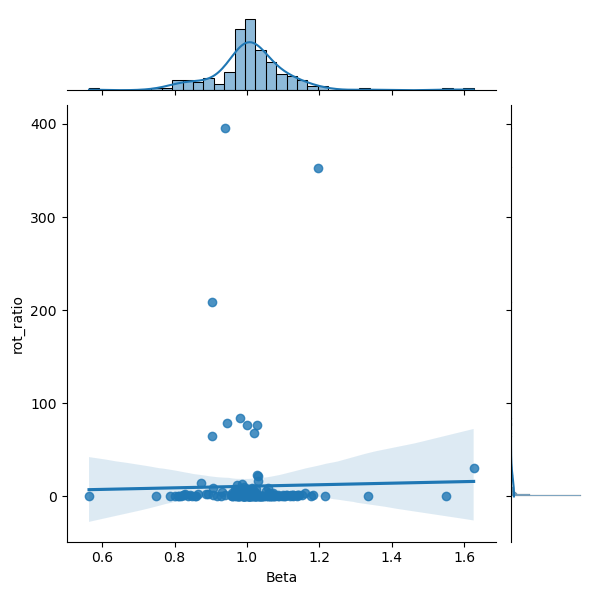

0.0004292536593612147


In [136]:
sns.scatterplot(x='Beta',y='rot_ratio',hue = 'Period',data = df3)
sns.jointplot(x='Beta',y='rot_ratio',data = df3, kind="reg")
print(r2(df3.Beta,df3.rot_ratio))

In [268]:
Pdf = pd.read_csv('D:\\6OHDA\\submission2\\bySessCompareCorr2Sig3.csv')
df = pd.read_csv('D:\\6OHDA\\submission2\\rotation_forR.csv')
df = df.groupby(['Session','Period']).mean()
df = df.reset_index()
df = df.rename(columns={"Session":'Sess'})
df['rot_ratio'] = df.apply(lambda x: x.percent_high_C/x.percent_high_AC if x.percent_high_AC else np.inf, axis=1)
df2 = pd.merge(Pdf,df[['Sess','Period','rot_ratio','percent_high_C','percent_high_AC']],on=['Sess','Period'])
df2

Unnamed: 0  Day  Mouse   Period            Sess  aSymCorr  \
0             0    0    761  Healthy  0761_BaselineA  0.013097   
1             0    0    761  Healthy  0761_BaselineA  0.014331   
2             0    0    761  Healthy  0761_BaselineL  0.037991   
3             0    0    761  Healthy  0761_BaselineL  0.031297   
4             0    0    761  Healthy  0761_BaselineS  0.022225   
..          ...  ...    ...      ...             ...       ...   
417           0    6   8815    Acute       8815_day6  0.048993   
418           0    6   8815    Acute       8815_day6  0.044444   
419           0    8   8815    Acute       8815_day8  0.010840   
420           0    8   8815    Acute       8815_day8  0.027759   
421           0    8   8815    Acute       8815_day8  0.012439   

     aSymCorrNotSig  aSymCorrSig  numred population  sASymCorr  sigPercent  \
0          0.005864     0.085427       1    MSN-CHI   0.004631    0.090909   
1          0.003154     0.079992       1    MSN-MSN   0.004195    0.145455   
2          0.005402     0.109687       1    MSN-CHI   0.002922    0.312500   
3          0.006481     0.112833       1    MSN-MSN   0.003881    0.233333   
4          0.012726     0.055472       1    MSN-CHI   0.003637    0.222222   
..              ...          ...     ...        ...        ...         ...   
417        0.000000     0.293958       4    MSN-CHI   0.001352    0.166667   
418        0.000000     0.666667       4    MSN-MSN   0.001413    0.066667   
419        0.000000     0.032520       3    CHI-CHI   0.001759    0.333333   
420        0.002958     0.198018       3    MSN-CHI   0.002699    0.127148   
421        0.002178     0.148732       3    MSN-MSN   0.002681    0.070017   

     rot_ratio  percent_high_C  percent_high_AC  
0     2.754491        0.115976         0.042104  
1     2.754491        0.115976         0.042104  
2     5.800546        0.178418         0.030759  
3     5.800546        0.178418         0.030759  
4     2.660000        0.178839         0.067233  
..         ...             ...              ...  
417        inf        0.080138         0.000000  
418        inf        0.080138         0.000000  
419   1.545977        0.067815         0.043866  
420   1.545977        0.067815         0.043866  
421   1.545977        0.067815         0.043866  

[422 rows x 15 columns]

<ipython-input-273-8ad67cf4f333>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3[col] = df3.apply(lambda x: x[col]/df3[(df3.Period=='Healthy')&(df3.Mouse==x.Mouse)][col].mean(),axis=1 )
<ipython-input-273-8ad67cf4f333>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3[col2] = df3.apply(lambda x: x[col2]/df3[(df3.Period=='Healthy')&(df3.Mouse==x.Mouse)][col2].mean(),axis=1 )


0.03861625663374939


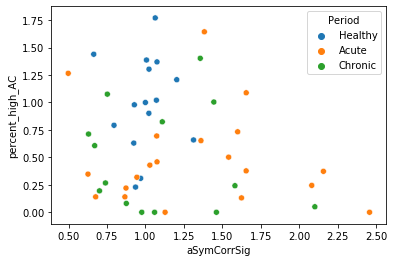

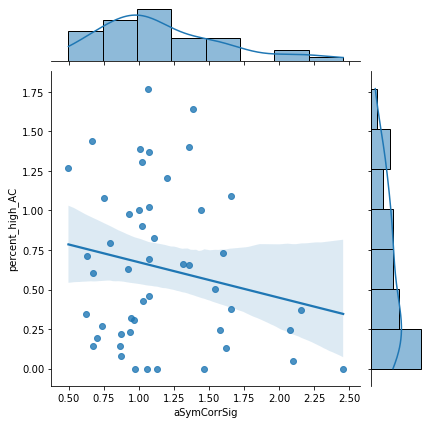

In [273]:
# df2['rot_ratio'].replace(np.inf,np.nan,inplace=True)
# df2 = df2.dropna()
col = 'aSymCorrSig'
col2  = 'percent_high_AC'
for p in ['MSN-CHI']:#df2.population.unique():
    df3 = df2[(df2.population==p)]
    df3[col] = df3.apply(lambda x: x[col]/df3[(df3.Period=='Healthy')&(df3.Mouse==x.Mouse)][col].mean(),axis=1 )
    df3[col2] = df3.apply(lambda x: x[col2]/df3[(df3.Period=='Healthy')&(df3.Mouse==x.Mouse)][col2].mean(),axis=1 )

    sns.scatterplot(x=col,y=col2,hue = 'Period',data = df3)
    sns.jointplot(x=col,y=col2,data = df3, kind="reg")
    df4 = df3[[col,col2]].dropna()
    print(r2(df4[col],df4[col2]))

<ipython-input-266-606f4ff23495>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3[col] = df3.apply(lambda x: x[col]/df3[(df3.Period=='Healthy')&(df3.Mouse==x.Mouse)][col].mean(),axis=1 )
<ipython-input-266-606f4ff23495>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['rot_ratio'] = df3.apply(lambda x: x.rot_ratio/df3[(df3.Period=='Healthy')&(df3.Mouse==x.Mouse)].rot_ratio.mean(),axis=1 )


0.019407851500555403


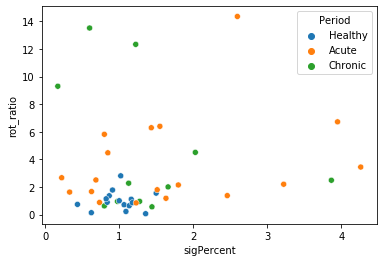

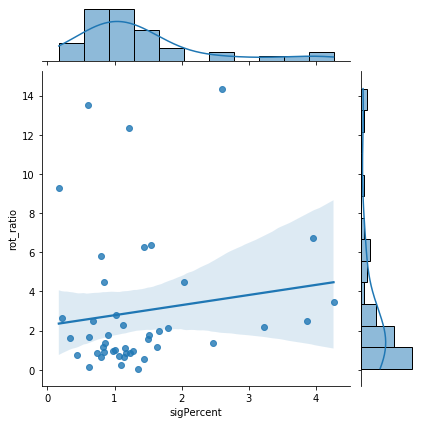

In [266]:
df2['rot_ratio'].replace(np.inf,np.nan,inplace=True)
df2 = df2.dropna()
col = 'sigPercent'
for p in ['MSN-CHI']:#df2.population.unique():
    df3 = df2[(df2.population==p)]
    df3[col] = df3.apply(lambda x: x[col]/df3[(df3.Period=='Healthy')&(df3.Mouse==x.Mouse)][col].mean(),axis=1 )
    df3['rot_ratio'] = df3.apply(lambda x: x.rot_ratio/df3[(df3.Period=='Healthy')&(df3.Mouse==x.Mouse)].rot_ratio.mean(),axis=1 )

    sns.scatterplot(x=col,y='rot_ratio',hue = 'Period',data = df3)
    sns.jointplot(x=col,y='rot_ratio',data = df3, kind="reg")
    print(r2(df3[col],df3.rot_ratio))

In [249]:
df3

Empty DataFrame
Columns: [Unnamed: 0, Day, Mouse, Period, Sess, aSymCorr, aSymCorrNotSig, aSymCorrSig, numred, population, sASymCorr, sigPercent, rot_ratio, percent_high_C, percent_high_AC]
Index: []

<ipython-input-144-7d10217a8ad7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['aSymCorrSig'] = df3.apply(lambda x: x.aSymCorrSig/df3[(df3.Period=='Healthy')&(df3.Mouse==x.Mouse)].aSymCorrSig.mean(),axis=1 )


<IPython.core.display.Javascript object>


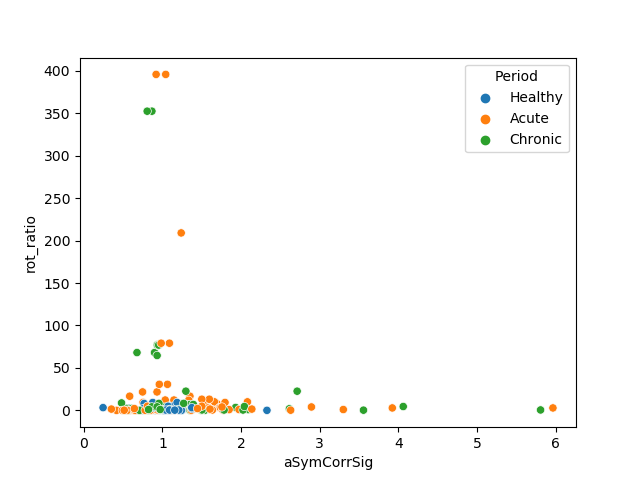

<IPython.core.display.Javascript object>


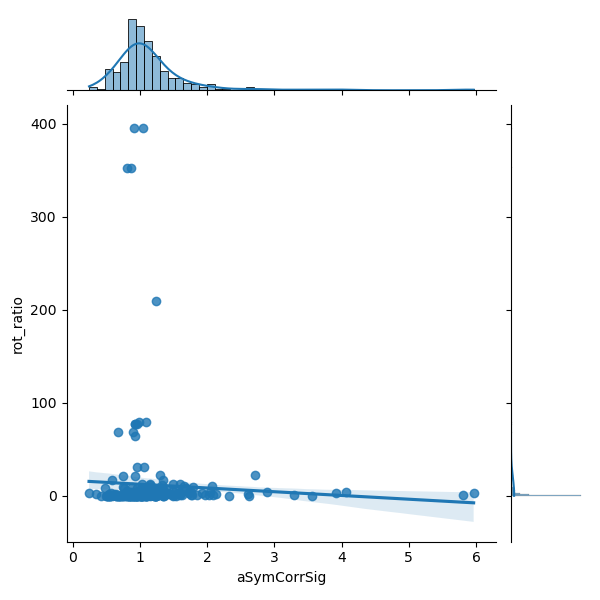

0.002904816156542622


In [144]:
df3 = df2[['Mouse','Period','Sess','aSymCorrSig','rot_ratio']]
df3['aSymCorrSig'] = df3.apply(lambda x: x.aSymCorrSig/df3[(df3.Period=='Healthy')&(df3.Mouse==x.Mouse)].aSymCorrSig.mean(),axis=1 )

sns.scatterplot(x='aSymCorrSig',y='rot_ratio',hue = 'Period',data = df3)
sns.jointplot(x='aSymCorrSig',y='rot_ratio',data = df3, kind="reg")
print(r2(df3.aSymCorrSig,df3.rot_ratio))

In [275]:
Pdf = pd.read_csv('D:\\6OHDA\\submission2\\mvmtCorrSig.csv')
Pdf = Pdf.drop(['personF','sPersonF'],axis=1)
df = pd.read_csv('D:\\6OHDA\\submission2\\rotation_forR.csv')
df = df.groupby(['Session','Period']).mean()
df = df.reset_index()
df = df.rename(columns={"Session":'Sess'})
df['rot_ratio'] = df.apply(lambda x: x.percent_high_C/x.percent_high_AC if x.percent_high_AC else np.inf, axis=1)
df2 = pd.merge(Pdf,df[['Sess','Period','rot_ratio','percent_high_C','percent_high_AC']],on=['Sess','Period'])

df2['rot_ratio'].replace(np.inf,np.nan,inplace=True)
df2 = df2.dropna()

df2

Unnamed: 0  Day  Mouse   Period            Sess  aSymCorr  \
1              0    0    761  Healthy  0761_BaselineA  0.017792   
3              0    0    761  Healthy  0761_BaselineA  0.006900   
6              0    0    761  Healthy  0761_BaselineA  0.016498   
7              0    0    761  Healthy  0761_BaselineA  0.017238   
8              0    0    761  Healthy  0761_BaselineA  0.010249   
...          ...  ...    ...      ...             ...       ...   
2155           0    8   8815    Acute       8815_day8  0.005200   
2157           0    8   8815    Acute       8815_day8  0.001790   
2158           0    8   8815    Acute       8815_day8  0.006513   
2160           0    8   8815    Acute       8815_day8  0.003948   
2161           0    8   8815    Acute       8815_day8  0.005401   

      aSymCorrNotSig  aSymCorrSig        mvmt  numred population  sASymCorr  \
1           0.006223     0.266518     hiSpeed       1    MSN-MSN   0.006684   
3           0.000980     0.308824  highContra       1    MSN-MSN   0.005809   
6           0.002930     0.152174      lowRot       1    MSN-CHI   0.002525   
7           0.000795     0.113836      lowRot       1    MSN-MSN   0.002742   
8           0.002524     0.087500    lowSpeed       1    MSN-CHI   0.003043   
...              ...          ...         ...     ...        ...        ...   
2155        0.000484     0.188264      lowRot       3    MSN-MSN   0.001124   
2157        0.000065     0.224224    lowSpeed       3    MSN-CHI   0.001529   
2158        0.000417     0.208153    lowSpeed       3    MSN-MSN   0.001143   
2160        0.001301     0.272624      totRot       3    MSN-CHI   0.002568   
2161        0.001409     0.307157      totRot       3    MSN-MSN   0.003243   

      sigPercent  rot_ratio  percent_high_C  percent_high_AC  
1       0.044444   2.754491        0.115976         0.042104  
3       0.019231   2.754491        0.115976         0.042104  
6       0.090909   2.754491        0.115976         0.042104  
7       0.145455   2.754491        0.115976         0.042104  
8       0.090909   2.754491        0.115976         0.042104  
...          ...        ...             ...              ...  
2155    0.025113   1.545977        0.067815         0.043866  
2157    0.007692   1.545977        0.067815         0.043866  
2158    0.029349   1.545977        0.067815         0.043866  
2160    0.009756   1.545977        0.067815         0.043866  
2161    0.013056   1.545977        0.067815         0.043866  

[1265 rows x 16 columns]

<ipython-input-287-2a2336441e6e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3[col] = df3.apply(lambda x: x[col]/df3[(df3.Period=='Healthy')&(df3.Mouse==x.Mouse)][col].mean(),axis=1 )
<ipython-input-287-2a2336441e6e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3[col2] = df3.apply(lambda x: x[col2]/df3[(df3.Period=='Healthy')&(df3.Mouse==x.Mouse)][col2].mean(),axis=1 )


<IPython.core.display.Javascript object>


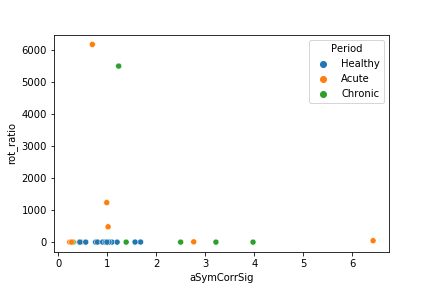

<IPython.core.display.Javascript object>


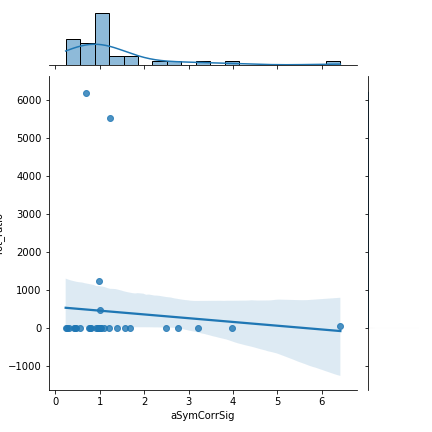

0.007394624435978725


In [287]:
col = 'aSymCorrSig'
col2  = 'rot_ratio'
mvmt = 'totRot'
df2['rot_ratio'].replace(np.inf,np.nan,inplace=True)
for p in ['MSN-PV']:#df2.population.unique():
    df3 = df2[(df2.population==p)&(df2.mvmt == mvmt)]
    df3[col] = df3.apply(lambda x: x[col]/df3[(df3.Period=='Healthy')&(df3.Mouse==x.Mouse)][col].mean(),axis=1 )
    df3[col2] = df3.apply(lambda x: x[col2]/df3[(df3.Period=='Healthy')&(df3.Mouse==x.Mouse)][col2].mean(),axis=1 )
    
    sns.scatterplot(x=col,y=col2,hue = 'Period',data = df3)
    sns.jointplot(x=col,y=col2,data = df3, kind="reg")
    df4 = df3[[col,col2]].dropna()
    print(r2(df4[col],df4[col2]))

------ EnD of rotation ratio stuf ------

In [206]:
# add speed data:
f = h5py.File('D:\\6OHDA\\Spectograms.hdf5','r') 
df = pd.DataFrame(columns = ['Mouse','Period','Sess'])
dtL = 0.00032768
for m in tqdm(miceList):
    data =  getData(Files[0],['lfp','trace'],period ='Pre', mice=m)
    for sess in data:
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        period = periodCalc(day)
        # get data
        freq = f[m][sess]['Pre']['freq'][:]
        coeff = np.abs(f[m][sess]['Pre']['coeff'][:])
        lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
        coeff = coeff[:,(lfpOutliers[:,0]==0)]
        Hs = np.nansum(coeff, axis=0)
        coeff = coeff/Hs
        frquencies = {'high_Gamma':freq > 60, 'low_Gamma':(freq >= 40) & (freq<60), 'high_Beta_15to20':(freq >= 15) & (freq<20),
         'Beta':(freq >= 10) & (freq<15),'theta':(freq >= 6) & (freq<8),'beta3':(freq >= 15) & (freq<18),
         'beta4':(freq >= 20) & (freq<25)}
        
        Ca = getOnsetOrPeriod(m,sess,'Pre','caOnset_Hf')
        numRed = int(data[sess]['trace']['numred'])
        Ca = Ca[np.sum(Ca,axis=1)>0,numRed:]
        Ca = np.mean(Ca,axis=0)
        
        caT = np.arange(max(Ca.shape))*0.05
        CaF = sci.interpolate.interp1d(caT, Ca,kind='linear')
        lfpT = np.arange(max(coeff.shape))*dtL
        
        if max(caT)< max(lfpT):
            endInd = np.argmin(np.abs(max(caT)-lfpT))
            print(endInd)
            while lfpT[endInd]>max(caT):
                endInd = endInd-1
        CaNew = CaF(lfpT[:endInd])
        
        df2 = pd.DataFrame([{'Mouse':m,'Period':period,'Sess':sess}])
        for fr in frquencies.keys():
            power =np.sum(coeff[frquencies[fr],:],axis=0)
            df2[fr] = np.corrcoef(x=CaNew,y=power[:endInd])[0,1]
        
        df = pd.concat([df,df2])
            

df.to_csv(figFolder+'powerCorrelation.csv')

f.close()        

                

                


  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data
1815491
1815491
1815491


C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


1815643
1815338
1815643
1815643
1815186
1815643
1815643
1815338
1815491
1815491
1815491


  6%|█████▏                                                                            | 1/16 [02:30<37:39, 150.61s/it]

cleaning up trace data
cleaning up lfp data
I deleted session: 1208_day12
1815643
1815338
1815491
1815338
1815491
1815491
found  17.0  outlier points
1815338
1815338
1815491
1815338
1815491
1815338
1815338


 12%|██████████▎                                                                       | 2/16 [04:58<34:56, 149.78s/it]

cleaning up trace data
cleaning up lfp data
1815643
1815491
1815491
1815643
1815643
1815491
1815643
1815643
1815643
1815643
1815643
1815643
1815643
1815643


 19%|███████████████▍                                                                  | 3/16 [07:34<32:52, 151.71s/it]

cleaning up trace data
cleaning up lfp data
1815338
1815186
1815338


 25%|████████████████████▌                                                             | 4/16 [08:09<23:18, 116.55s/it]

cleaning up trace data
cleaning up lfp data
found  1.0  outlier points
1815338
1815491
1815338
1815186
1815491
1815033
1815491
1815643
1815338
found  888231.0  outlier points
found  481139.0  outlier points
1815338
1815186
1815491


 31%|█████████████████████████▋                                                        | 5/16 [10:42<23:24, 127.72s/it]

cleaning up trace data
cleaning up lfp data
1815643
1815491
1815643


 38%|███████████████████████████████▏                                                   | 6/16 [11:17<16:38, 99.80s/it]

cleaning up trace data
cleaning up lfp data
1815643
1815033
1815491
1815491
1815491
1815491
1815338
1815643
1815491
1815643
1815643
1815491
1815491
1815186


 44%|███████████████████████████████████▉                                              | 7/16 [13:57<17:40, 117.85s/it]

cleaning up trace data
cleaning up lfp data
I deleted session: 2976_day4
found  1.0  outlier points
1815643
1815643
1815643
1815643
1815643
1815643
1815643
1815643
1815643
1815643
1815643
1815643
found  3.0  outlier points
1815643


 50%|█████████████████████████████████████████                                         | 8/16 [16:25<16:54, 126.78s/it]

cleaning up trace data
cleaning up lfp data
1815643
1815643
1815643
1815643
1815643
1815643
1815643
1815643
1815643
1815643
1815643
1815643
1815643
1815643


 56%|██████████████████████████████████████████████▏                                   | 9/16 [19:01<15:49, 135.60s/it]

cleaning up trace data
cleaning up lfp data
1815643
1815643
1815643
1815491
1815643
1815643
found  50.0  outlier points
1815643
1815643
1815643
1815643
1448822
1815643
1815643


 62%|██████████████████████████████████████████████████▋                              | 10/16 [21:37<14:09, 141.65s/it]

cleaning up trace data
cleaning up lfp data
1815491
1815033
1815338
1815338
found  29.0  outlier points
1814880
1815491
1815186
1815338
1815033
1815491
1815186
1815491
1815491
1815491
1815643
1815033
1815033
1815033
1815338


 69%|███████████████████████████████████████████████████████▋                         | 11/16 [25:06<13:29, 161.93s/it]

cleaning up trace data
cleaning up lfp data
1815033
1815491
1815643
1814728
1815491
1814728
1815033
1815033
1815491
1815491
1815338
1815491
1815338
1815186
1815338
1815186
1814880


 75%|████████████████████████████████████████████████████████████▊                    | 12/16 [28:17<11:23, 170.81s/it]

cleaning up trace data
cleaning up lfp data
1814880
1815491
1815033
1815186
1815033
1815033
1815186
1813965
1814575
1815491
1815491
1815186
1815643
1815186
1815338
1814575
1815186
1814270
1813049


 81%|█████████████████████████████████████████████████████████████████▊               | 13/16 [31:48<09:08, 182.79s/it]

cleaning up trace data
cleaning up lfp data
1815643
1815491
1815338
1815643
1815186
1815643
1815491
1815338
1815491
1815491
1815186
1815338
1815643


 88%|██████████████████████████████████████████████████████████████████████▉          | 14/16 [34:14<05:43, 171.57s/it]

cleaning up trace data
cleaning up lfp data
1815491
1815491
1815491
1815643
1815643
1815491
1815491
1815491
1815643
1815491
1815338
1815643
1781006
1815338


 94%|███████████████████████████████████████████████████████████████████████████▉     | 15/16 [36:50<02:47, 167.04s/it]

cleaning up trace data
cleaning up lfp data
1815033
1815643
1814880
1612396
1815491
1815033
1815338
1815338
1815643
1815338
1815491
1815186
1631012
1815186


100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [39:24<00:00, 147.78s/it]


<IPython.core.display.Javascript object>


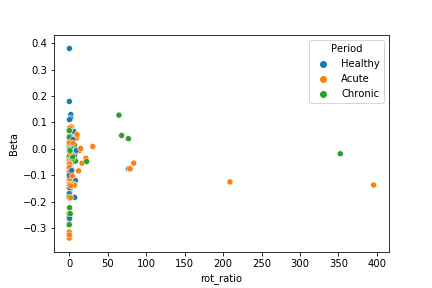

In [424]:
%matplotlib notebook
Pdf = pd.read_csv(figFolder+'powerCorrelation.csv')
df = pd.read_csv('D:\\6OHDA\\submission2\\rotation_forR.csv')
df = df.groupby(['Session','Period']).mean()
df = df.reset_index()
df = df.rename(columns={"Session":'Sess'})
df['rot_ratio'] = df.apply(lambda x: x.percent_high_C/x.percent_high_AC if x.percent_high_AC else np.inf, axis=1)
df2 = pd.merge(Pdf,df[['Sess','Period','rot_ratio','percent_high_C','percent_high_AC']],on=['Sess','Period'])

df2['rot_ratio'].replace(np.inf,np.nan,inplace=True)
# df2 = df2.dropna()

sns.scatterplot(x='rot_ratio',y='Beta',hue='Period',data=df2)

<IPython.core.display.Javascript object>


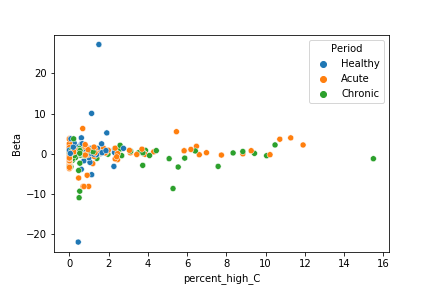

<IPython.core.display.Javascript object>


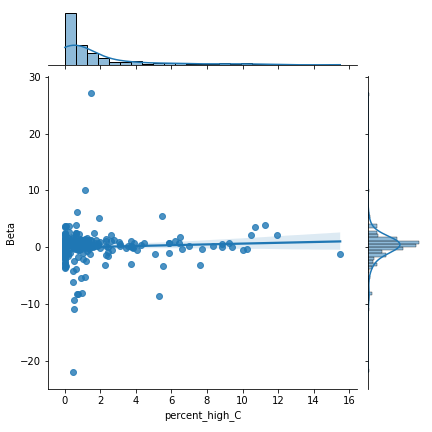

0.003145428658422484


In [430]:
col2 = 'Beta'
col = 'percent_high_C'
df3 = df2
df3[col] = df3.apply(lambda x: x[col]/df3[(df3.Period=='Healthy')&(df3.Mouse==x.Mouse)][col].mean(),axis=1 )
# df3[col2] = df3.apply(lambda x: x[col2]/df3[(df3.Period=='Healthy')&(df3.Mouse==x.Mouse)][col2].mean(),axis=1 )

sns.scatterplot(x=col,y=col2,hue = 'Period',data = df3)
sns.jointplot(x=col,y=col2,data = df3, kind="reg")
df4 = df3[[col,col2]].dropna()
print(r2(df4[col],df4[col2]))

In [243]:
# add speed data:
f = h5py.File('D:\\6OHDA\\Spectograms.hdf5','r') 
mvmtType = {'highIpsi':"getOnsetOrPeriod(m,sess,'Pre','hiACRotPeriods_vector')",
            'highContra':"getOnsetOrPeriod(m,sess,'Pre','hiCRotPeriods_vector')",
            'lowRot':"getOnsetOrPeriod(m,sess,'Pre','loRotPeriods_vector')",
            'lowSpeed':"getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_vector')",
            'hiSpeed':"getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_vector')",
           'totRot':"getOnsetOrPeriod(m,sess,'Pre','hiACRotPeriods_vector')+getOnsetOrPeriod(m,sess,'Pre','hiCRotPeriods_vector')"}

df = pd.DataFrame(columns = ['Mouse','Period','Sess'])
dtL = 0.00032768
for m in tqdm(miceList):
    data =  getData(Files[0],['lfp','trace'],period ='Pre', mice=m)
    for sess in tqdm(data):
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        period = periodCalc(day)
        # get data
        freq = f[m][sess]['Pre']['freq'][:]
        coeff = np.abs(f[m][sess]['Pre']['coeff'][:])
        lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
        coeff = coeff[:,(lfpOutliers[:,0]==0)]
        Hs = np.nansum(coeff, axis=0)
        coeff = coeff/Hs
        frquencies = {'high_Gamma':freq > 60, 'low_Gamma':(freq >= 40) & (freq<60), 'high_Beta_15to20':(freq >= 15) & (freq<20),
         'Beta':(freq >= 10) & (freq<15),'theta':(freq >= 6) & (freq<8),'beta3':(freq >= 15) & (freq<18),
         'beta4':(freq >= 20) & (freq<25)}
        
        Ca = getOnsetOrPeriod(m,sess,'Pre','caOnset_Hf')
        numRed = int(data[sess]['trace']['numred'])
        Ca = Ca[np.sum(Ca,axis=1)>0,numRed:]
        Ca = np.mean(Ca,axis=0)
        
        caT = np.arange(max(Ca.shape))*0.05
        CaF = sci.interpolate.interp1d(caT, Ca,kind='linear')
        lfpT = np.arange(max(coeff.shape))*dtL

        if max(caT)< max(lfpT):
            endInd = np.argmin(np.abs(max(caT)-lfpT))
            while lfpT[endInd]>max(caT):
                endInd = endInd-1


        for mv in mvmtType.keys(): 
            mVector = eval(mvmtType[mv])
            if np.sum(mVector)==0:
                continue
            try:
                mvF = sci.interpolate.interp1d(caT, mVector,kind='linear')
            except:
                caT = np.arange(max(mVector.shape))*0.05
                mvF = sci.interpolate.interp1d(caT, mVector,kind='linear')
                if max(caT)< max(lfpT):
                    endInd2 = np.argmin(np.abs(max(caT)-lfpT))
                    while lfpT[endInd2]>max(caT):
                        endInd2 = endInd2-1
                    endInd = np.min((endInd2,endInd))
            mvNew = mvF(lfpT[:endInd])>0
            CaNew = CaF(lfpT[:endInd])
            
            df2 = pd.DataFrame([{'Mouse':m,'Period':period,'Sess':sess,'mvmt':mv}])
            for fr in frquencies.keys():
                power =np.sum(coeff[frquencies[fr],:endInd],axis=0)
                df2[fr] = np.corrcoef(x=CaNew[mvNew],y=power[mvNew])[0,1]

            df = pd.concat([df,df2])
            

df.to_csv(figFolder+'powerCorrelation_mvmt.csv')

f.close()


                

                


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data



 36%|█████████████████████████████▋                                                     | 5/14 [01:21<02:26, 16.29s/it]C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]

  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data
I deleted session: 1208_day12



 46%|██████████████████████████████████████▎                                            | 6/13 [02:09<02:29, 21.38s/it]

found  17.0  outlier points



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data
found  1.0  outlier points



 64%|█████████████████████████████████████████████████████▎                             | 9/14 [03:07<01:41, 20.33s/it]

found  888231.0  outlier points



 71%|██████████████████████████████████████████████████████████▌                       | 10/14 [03:20<01:13, 18.26s/it]

found  481139.0  outlier points



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data



  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data
I deleted session: 2976_day4
found  1.0  outlier points



 92%|███████████████████████████████████████████████████████████████████████████▋      | 12/13 [04:11<00:20, 20.83s/it]

found  3.0  outlier points



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data



 43%|███████████████████████████████████▌                                               | 6/14 [02:12<02:55, 21.94s/it]

found  50.0  outlier points



  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data



 21%|█████████████████▍                                                                 | 4/19 [01:22<05:05, 20.38s/it]

found  29.0  outlier points



  0%|                                                                                           | 0/17 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data



  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data



  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data



100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [1:10:35<00:00, 264.70s/it]


In [301]:
df = pd.read_csv(figFolder+'powerCorrelation_mvmt.csv')
df

Unnamed: 0  Mouse   Period            Sess        mvmt  high_Gamma  \
0              0    761  Healthy  0761_BaselineA    highIpsi    0.142371   
1              0    761  Healthy  0761_BaselineA  highContra    0.115500   
2              0    761  Healthy  0761_BaselineA      lowRot    0.041953   
3              0    761  Healthy  0761_BaselineA    lowSpeed    0.052080   
4              0    761  Healthy  0761_BaselineA     hiSpeed    0.104007   
...          ...    ...      ...             ...         ...         ...   
1128           0   8815    Acute       8815_day8  highContra   -0.005929   
1129           0   8815    Acute       8815_day8      lowRot    0.157704   
1130           0   8815    Acute       8815_day8    lowSpeed    0.128274   
1131           0   8815    Acute       8815_day8     hiSpeed    0.059052   
1132           0   8815    Acute       8815_day8      totRot    0.094698   

      low_Gamma  high_Beta_15to20      Beta     theta     beta3     beta4  
0      0.060712         -0.079196 -0.062748  0.143740 -0.062168 -0.028192  
1      0.042990         -0.016668 -0.005389 -0.008554 -0.058344 -0.106247  
2     -0.001634         -0.037376  0.027816  0.074778 -0.018999 -0.058810  
3      0.001561         -0.022612  0.002131  0.111693 -0.000482 -0.069462  
4     -0.038755          0.038046  0.132059 -0.027910  0.046377 -0.075427  
...         ...               ...       ...       ...       ...       ...  
1128   0.121683         -0.084865  0.047980 -0.048672 -0.150737 -0.123109  
1129   0.050661         -0.056007 -0.133132 -0.061934 -0.078713 -0.026808  
1130   0.065281         -0.080420 -0.160647 -0.049278 -0.086272 -0.049003  
1131   0.019946         -0.062018  0.050954 -0.074324 -0.079553 -0.013883  
1132   0.167132         -0.130336  0.015424 -0.166634 -0.166767 -0.056290  

[1133 rows x 12 columns]

In [344]:
# add speed data:
f = h5py.File('D:\\6OHDA\\Spectograms.hdf5','r') 
df = pd.DataFrame(columns = ['Mouse','Period','Sess'])
dtL = 0.00032768
tPlot = np.linspace(-4,4,int(8/dtL-1))
for m in tqdm(miceList):
    data =  getData(Files[0],['lfp','trace'],period ='Pre', mice=m)
    for sess in data:
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        period = periodCalc(day)
        # get data
        freq = f[m][sess]['Pre']['freq'][:]
        coeff = np.abs(f[m][sess]['Pre']['coeff'][:])
        lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
        coeff = coeff[:,(lfpOutliers[:,0]==0)]
        Hs = np.nansum(coeff, axis=0)
        coeff = coeff/Hs
        frquencies = {'high_Gamma':freq > 60, 'low_Gamma':(freq >= 40) & (freq<60), 'high_Beta_15to20':(freq >= 15) & (freq<20),
         'Beta':(freq >= 10) & (freq<15),'theta':(freq >= 6) & (freq<8),'beta3':(freq >= 15) & (freq<18),
         'beta4':(freq >= 20) & (freq<25)}
        
        Ca = getOnsetOrPeriod(m,sess,'Pre','caOnset_Hf')
        numRed = int(data[sess]['trace']['numred'])
        Ca = Ca[np.sum(Ca,axis=1)>0,numRed:]
        Ca = np.mean(Ca,axis=0)
        
        caT = np.arange(max(Ca.shape))*0.05
        CaF = sci.interpolate.interp1d(caT, Ca,kind='linear')
        lfpT = np.arange(max(coeff.shape))*dtL
        
        if max(caT)< max(lfpT):
            endInd = np.argmin(np.abs(max(caT)-lfpT))
            print(endInd)
            while lfpT[endInd]>max(caT):
                endInd = endInd-1
        
        mVector = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_vector')
        if np.sum(mVector)==0:
            continue
        try:
            mvF = sci.interpolate.interp1d(caT, mVector,kind='linear')
        except:
            caT = np.arange(max(mVector.shape))*0.05
            mvF = sci.interpolate.interp1d(caT, mVector,kind='linear')
            if max(caT)< max(lfpT):
                endInd2 = np.argmin(np.abs(max(caT)-lfpT))
                while lfpT[endInd2]>max(caT):
                    endInd2 = endInd2-1
                endInd = np.min((endInd2,endInd))
        mvNew = mvF(lfpT[:endInd])>0
        CaNew = CaF(lfpT[:endInd])
            
        
        
        
        C = [np.mean(CaNew[i : i + tPlot.shape[0]]) for i in range(0, CaNew.shape[0],int(np.ceil(2/dtL)))] 
        M = [np.mean(mvNew[i : i + tPlot.shape[0]]) for i in range(0, mvNew.shape[0],int(np.ceil(2/dtL)))] 
        
        df2 = pd.DataFrame(np.array([C,M]).T, columns = ['Corr','highSpeed'])
        df2['Mouse'] = m
        df2['Period']=period
        df2['Sess']=sess

        
        for fr in frquencies.keys():
            power =np.sum(coeff[frquencies[fr],:endInd],axis=0)
            P = [np.mean(power[i : i + tPlot.shape[0]]) for i in range(0, power.shape[0],int(np.ceil(2/dtL)))]  
            df2[fr] = P
        
        df = pd.concat([df,df2])
            

df.to_csv(figFolder+'powerCorrelation_window.csv')

f.close()        

                

                


  0%|                                                                                           | 0/16 [00:00<?, ?it/s]D:\6OHDA\IO.py:48: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  lfp = hf[m][s]['ePhys']['lfp'].value
D:\6OHDA\IO.py:282: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  dff = hf[m][s]['traces']['dff'].value


cleaning up trace data
cleaning up lfp data


D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value


1815491
1815491
1815491


C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


1815643
1815338
1815643
1815643
1815186
1815643
1815643
1815338
1815491
1815491
1815491


  6%|█████▏                                                                            | 1/16 [02:32<38:14, 152.96s/it]

cleaning up trace data
cleaning up lfp data
I deleted session: 1208_day12
1815643
1815338
1815491
1815338
1815491
1815491
found  17.0  outlier points
1815338
1815338
1815491
1815338
1815491
1815338
1815338


 12%|██████████▎                                                                       | 2/16 [05:01<35:24, 151.76s/it]

cleaning up trace data
cleaning up lfp data
1815643
1815491
1815491
1815643
1815643
1815491
1815643
1815643
1815643
1815643
1815643
1815643
1815643
1815643


 19%|███████████████▍                                                                  | 3/16 [07:38<33:13, 153.34s/it]

cleaning up trace data
cleaning up lfp data
1815338
1815186
1815338


 25%|████████████████████▌                                                             | 4/16 [08:13<23:32, 117.71s/it]

cleaning up trace data
cleaning up lfp data
found  1.0  outlier points
1815338
1815491
1815338
1815186
1815491
1815033
1815491
1815643
1815338
found  888231.0  outlier points
found  481139.0  outlier points
1815338
1815186
1815491


 31%|█████████████████████████▋                                                        | 5/16 [10:48<23:37, 128.87s/it]

cleaning up trace data
cleaning up lfp data
1815643
1815491
1815643


 38%|██████████████████████████████▊                                                   | 6/16 [11:23<16:47, 100.71s/it]

cleaning up trace data
cleaning up lfp data
1815643
1815033
1815491
1815491
1815491
1815491
1815338
1815643
1815491
1815643
1815643
1815491
1815491
1815186


 44%|███████████████████████████████████▉                                              | 7/16 [14:02<17:44, 118.33s/it]

cleaning up trace data
cleaning up lfp data
I deleted session: 2976_day4
found  1.0  outlier points
1815643
1815643
1815643
1815643
1815643
1815643
1815643
1815643
1815643
1815643
1815643
1815643
found  3.0  outlier points
1815643


 50%|█████████████████████████████████████████                                         | 8/16 [16:30<16:57, 127.17s/it]

cleaning up trace data
cleaning up lfp data
1815643
1815643
1815643
1815643
1815643
1815643
1815643
1815643
1815643
1815643
1815643
1815643
1815643
1815643


 56%|██████████████████████████████████████████████▏                                   | 9/16 [19:06<15:51, 135.88s/it]

cleaning up trace data
cleaning up lfp data
1815643
1815643
1815643
1815491
1815643
1815643
found  50.0  outlier points
1815643
1815643
1815643
1815643
1448822
1815643
1815643


 62%|██████████████████████████████████████████████████▋                              | 10/16 [21:42<14:11, 141.93s/it]

cleaning up trace data
cleaning up lfp data
1815491
1815033
1815338
1815338
found  29.0  outlier points
1814880
1815491
1815186
1815338
1815033
1815491
1815186
1815491
1815491
1815491
1815643
1815033
1815033
1815033
1815338


 69%|███████████████████████████████████████████████████████▋                         | 11/16 [25:12<13:30, 162.17s/it]

cleaning up trace data
cleaning up lfp data
1815033
1815491
1815643
1814728
1815491
1814728
1815033
1815033
1815491
1815491
1815338
1815491
1815338
1815186
1815338
1815186
1814880


 75%|████████████████████████████████████████████████████████████▊                    | 12/16 [28:25<11:25, 171.36s/it]

cleaning up trace data
cleaning up lfp data
1814880
1815491
1815033
1815186
1815033
1815033
1815186
1813965
1814575
1815491
1815491
1815186
1815643
1815186
1815338
1814575
1815186
1814270
1813049


 81%|█████████████████████████████████████████████████████████████████▊               | 13/16 [31:53<09:06, 182.32s/it]

cleaning up trace data
cleaning up lfp data
1815643
1815491
1815338
1815643
1815186
1815643
1815491
1815338
1815491
1815491
1815186
1815338
1815643


 88%|██████████████████████████████████████████████████████████████████████▉          | 14/16 [34:18<05:42, 171.29s/it]

cleaning up trace data
cleaning up lfp data
1815491
1815491
1815491
1815643
1815643
1815491
1815491
1815491
1815643
1815491
1815338
1815643
1781006
1815338


 94%|███████████████████████████████████████████████████████████████████████████▉     | 15/16 [36:55<02:47, 167.01s/it]

cleaning up trace data
cleaning up lfp data
1815033
1815643
1814880
1612396
1815491
1815033
1815338
1815338
1815643
1815338
1815491
1815186
1631012
1815186


100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [39:29<00:00, 148.09s/it]


In [360]:
df = pd.read_csv(figFolder+'powerCorrelation_mvmt.csv')
df.mvmt.unique()


array(['highIpsi', 'highContra', 'lowRot', 'lowSpeed', 'hiSpeed',
       'totRot'], dtype=object)

<IPython.core.display.Javascript object>


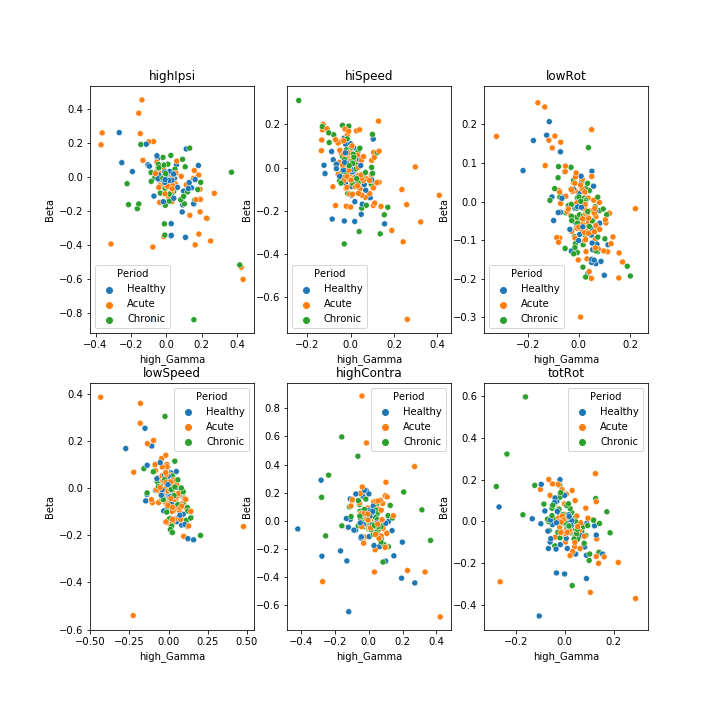

In [365]:
fig, ax = plt.subplots(2,3,figsize=(10,10))
for ind,mv in enumerate(df.mvmt.unique()):
    sns.scatterplot(data = df[df.mvmt==mv],y='Beta',hue='Period',x='high_Gamma',ax=ax[ind%2,ind%3])
    ax[ind%2,ind%3].set_title(mv)

In [367]:
df = pd.read_csv(figFolder+'powerCorrelation_window.csv')
df

Unnamed: 0  Mouse   Period            Sess      Corr  highSpeed  \
0               0    761  Healthy  0761_BaselineA  0.002604   0.000000   
1               1    761  Healthy  0761_BaselineA  0.003646   0.000000   
2               2    761  Healthy  0761_BaselineA  0.003904   0.000000   
3               3    761  Healthy  0761_BaselineA  0.005729   0.000000   
4               4    761  Healthy  0761_BaselineA  0.005729   0.000000   
...           ...    ...      ...             ...       ...        ...   
61936         293   8815    Acute       8815_day8  0.010786   0.537501   
61937         294   8815    Acute       8815_day8  0.007129   0.577515   
61938         295   8815    Acute       8815_day8  0.003682   0.663426   
61939         296   8815    Acute       8815_day8  0.000829   0.617546   
61940         297   8815    Acute       8815_day8  0.000000   0.801045   

       high_Gamma  low_Gamma  high_Beta_15to20      Beta     theta     beta3  \
0        0.143072   0.179768          0.090550  0.120292  0.075651  0.058375   
1        0.145283   0.181787          0.093465  0.118107  0.075839  0.058008   
2        0.149005   0.184678          0.081296  0.115815  0.076184  0.049561   
3        0.145701   0.194475          0.080712  0.110901  0.079457  0.050832   
4        0.152409   0.189094          0.078899  0.105182  0.075133  0.047626   
...           ...        ...               ...       ...       ...       ...   
61936    0.171523   0.170838          0.072419  0.101879  0.102736  0.046594   
61937    0.170531   0.169275          0.071188  0.106638  0.097070  0.043733   
61938    0.170523   0.173679          0.077087  0.103666  0.092477  0.048665   
61939    0.176590   0.180988          0.084783  0.089705  0.100929  0.055003   
61940    0.178623   0.205930          0.081587  0.079854  0.102620  0.042933   

          beta4  
0      0.075159  
1      0.070575  
2      0.065935  
3      0.070129  
4      0.069957  
...         ...  
61936  0.063383  
61937  0.066230  
61938  0.077714  
61939  0.075417  
61940  0.067715  

[61941 rows x 13 columns]

<IPython.core.display.Javascript object>


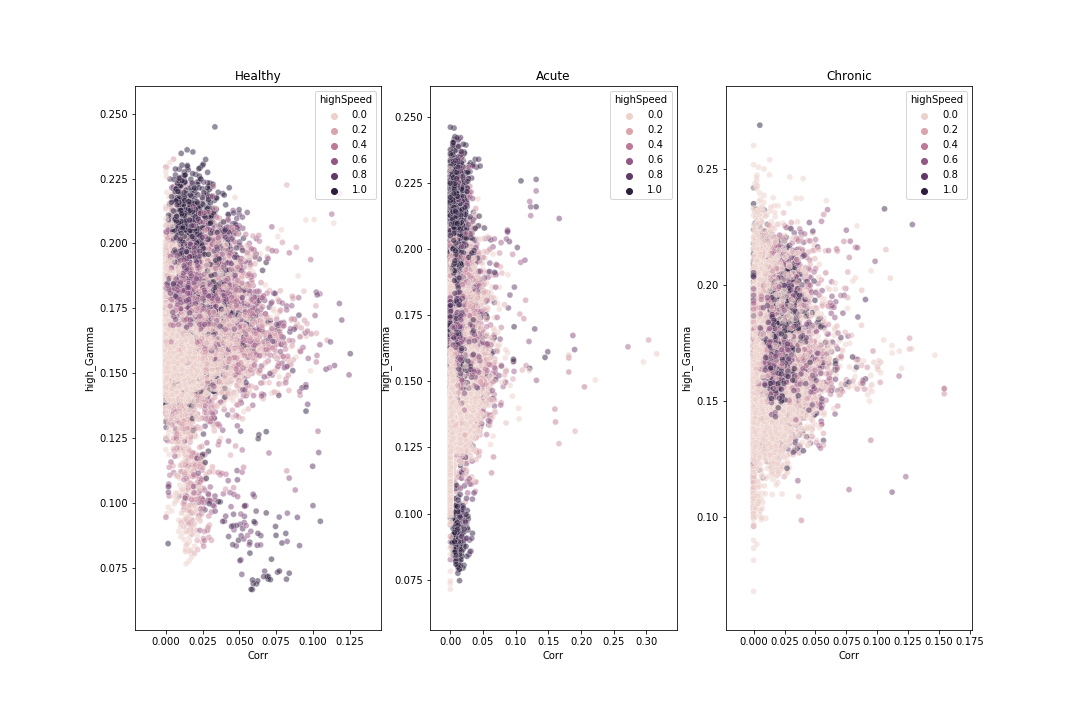

In [381]:
fig, ax = plt.subplots(1,3,figsize=(15,10))
for ind,p in enumerate(df.Period.unique()):
    sns.scatterplot(data = df[df.Period==p],y='high_Gamma',hue='highSpeed',x='Corr',ax=ax[ind%3],alpha=0.5)
    ax[ind%3].set_title(p)

<IPython.core.display.Javascript object>


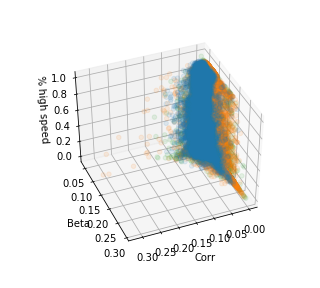

Text(0.5, 0, '% high speed')

In [379]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=plt.figaspect(.9))
ax = fig.add_subplot(1, 1, 1, projection='3d')
for ind,p in enumerate(df.Period.unique()):
    #ax = fig.add_subplot(1, 3, ind+1, projection='3d')
    ax.scatter3D(df[df.Period==p].Corr,df[df.Period==p].Beta,df[df.Period==p].highSpeed,label=p,alpha=0.1)
#     sns.scatterplot(data = df[df.Period==p],y='Beta',hue='highSpeed',x='Corr',ax=,alpha=0.5)
ax.set_xlabel('Corr')
ax.set_ylabel('Beta')
ax.set_zlabel('% high speed')

<ipython-input-408-8c6e6cb72e2d>:8: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  model = sm.GLM(y, df2[['Intercept','Corr','highSpeed','period']], family=Gamma(link=sm.families.links.log))


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                61643
Model:                            GLM   Df Residuals:                    61639
Model Family:                   Gamma   Df Model:                            3
Link Function:                    log   Scale:                        0.053101
Method:                          IRLS   Log-Likelihood:             1.4624e+05
Date:                Wed, 14 Jul 2021   Deviance:                       2682.6
Time:                        13:33:12   Pearson chi2:                 3.27e+03
No. Iterations:                    12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.1788      0.002  -1087.299      0.0

<IPython.core.display.Javascript object>


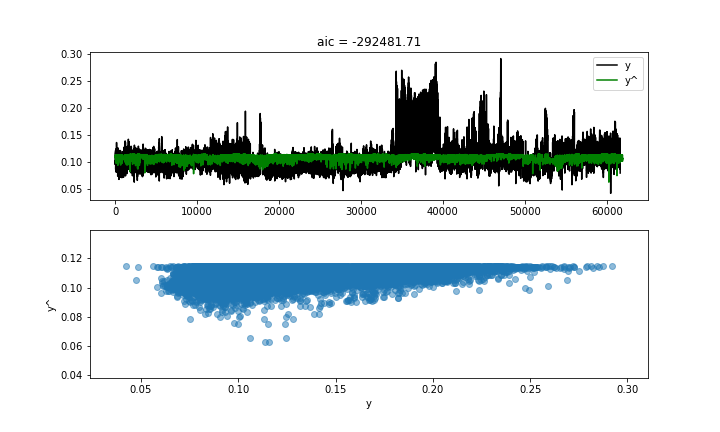

In [408]:
# import statsmodels.api as sm
# from statsmodels.genmod.families import Poisson, Gamma, Gaussian
df["Intercept"] = 1
period = {'Healthy':0,'Acute':1,'Chronic':2}
df['period'] = df.apply(lambda x: period[x.Period],axis=1)
df2 = df.dropna()
y=np.asarray(df2.Beta)
model = sm.GLM(y, df2[['Intercept','Corr','highSpeed','period']], family=Gamma(link=sm.families.links.log))
model_results = model.fit()
b = model_results.params
print(model_results.summary())
aic = model_results.aic
y_hut = np.exp(np.sum(b*df2[['Intercept','period','Corr','highSpeed']],axis=1)) 
# plot if required
#if plot: 
fig, (ax,ax2) = plt.subplots(2,1,figsize=(10,6))
ax.plot(y,label='y',color='k')
ax.plot(y_hut,label='y^',color='g')
ax2.scatter(y,y_hut,alpha=0.5)
ax2.set_xlabel('y')
ax2.set_ylabel('y^')
ax.set_title("aic = {0:8.2f}".format(aic))
ax.legend()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                61643
Model:                            GLM   Df Residuals:                    61639
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                      0.00064640
Method:                          IRLS   Log-Likelihood:             1.3889e+05
Date:                Wed, 14 Jul 2021   Deviance:                       39.844
Time:                        13:34:50   Pearson chi2:                     39.8
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1133      0.000    512.248      0.0

<IPython.core.display.Javascript object>


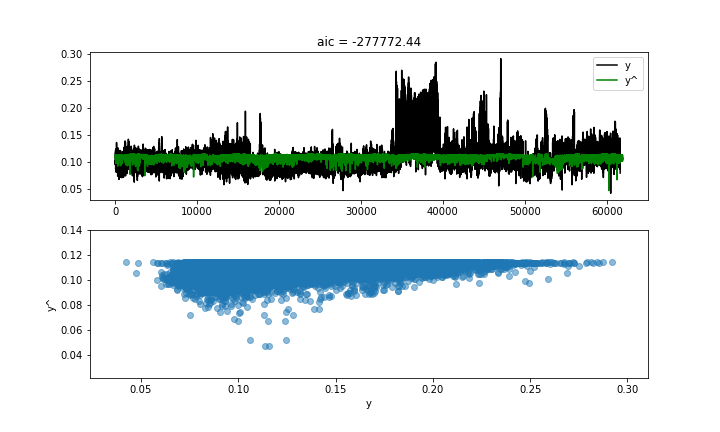

In [412]:
# import statsmodels.api as sm
# from statsmodels.genmod.families import Poisson, Gamma, Gaussian
df["Intercept"] = 1
period = {'Healthy':0,'Acute':1,'Chronic':2}
df['period'] = df.apply(lambda x: period[x.Period],axis=1)
df2 = df.dropna()
y=np.asarray(df2.Beta)
model = sm.GLM(y, df2[['Intercept','Corr','highSpeed','period']], family=Gaussian())
model_results = model.fit()
b = model_results.params
print(model_results.summary())
aic = model_results.aic
y_hut = np.sum(b*df2[['Intercept','Corr','highSpeed','period']],axis=1) 
# plot if required
#if plot: 
fig, (ax,ax2) = plt.subplots(2,1,figsize=(10,6))
ax.plot(y,label='y',color='k')
ax.plot(y_hut,label='y^',color='g')
ax2.scatter(y,y_hut,alpha=0.5)
ax2.set_xlabel('y')
ax2.set_ylabel('y^')
ax.set_title("aic = {0:8.2f}".format(aic))
ax.legend()

In [403]:
# import statsmodels.api as sm
# from statsmodels.genmod.families import Poisson, Gamma, Gaussian
import statsmodels.formula.api as smf
df["Intercept"] = 1
period = {'Healthy':0,'Acute':1,'Chronic':2}
df['period'] = df.apply(lambda x: period[x.Period],axis=1)
df2 = df.dropna()
y=np.asarray(df2.Beta)
model = smf.mixedlm("Beta ~ Corr + highSpeed", df2, groups=df2["Period"])
model_results = model.fit()
b = model_results.params
print(model_results.summary())
# aic = model_results.aic
# y_hut = np.exp(np.sum(b*df2[['period','Corr','highSpeed','Intercept']],axis=1)) 
# # plot if required
# #if plot: 
# fig, (ax,ax2) = plt.subplots(2,1,figsize=(10,6))
# ax.plot(y,label='y',color='k')
# ax.plot(y_hut,label='y^',color='g')
# ax2.scatter(y,y_hut,alpha=0.5)
# ax2.set_xlabel('y')
# ax2.set_ylabel('y^')
# ax.set_title("aic = {0:8.2f}".format(aic))
# ax.legend()

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Beta       
No. Observations: 61643   Method:             REML       
No. Groups:       3       Scale:              0.0006     
Min. group size:  14304   Log-Likelihood:     139055.5244
Max. group size:  29373   Converged:          Yes        
Mean group size:  20547.7                                
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      0.113    0.002  75.288 0.000  0.110  0.116
Corr          -0.184    0.007 -25.295 0.000 -0.198 -0.170
highSpeed     -0.009    0.000 -31.021 0.000 -0.010 -0.009
Group Var      0.000    0.000                            



C:\Users\dzemel\Miniconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\dzemel\Miniconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\dzemel\Miniconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2168: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [446]:
f = h5py.File('membership.hdf5','r')
miceList = getMiceList(Files[1])
col_names = ['Sess','Mouse','Period','Day','CellType']
df = pd.DataFrame(columns=col_names)
for m in miceList:
    grp = f[m]
    sessions = list(grp.keys())
    for sess in sessions:
        try:
            meanR_mvmtOnset = grp[sess]['mvmtOnset']['result'].value
        except:
            print(sess,'mvmt')
            meanR_mvmtOnset = np.nan
            
        try:
            meanR_rotOnset = grp[sess]['rotOnset']['result'].value
        except:
            print(sess,'rot')
            meanR_rotOnset = np.nan
        
        if sess[5] == 'B':
                day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        cre = getCreType(Files[1],m)
        nRed = getNumRed(Files[1],m,sess[5:])
        try:
            df2 = pd.DataFrame({'Sess':sess,'Mouse':m,'Period':periodCalc(day),
                                'Day':day,'CellType':'MSN',
                                'meanR_mvmtOnset':meanR_mvmtOnset,
                                'meanR_rotOnset':meanR_rotOnset})
        except:
            df2 = pd.DataFrame({'Sess':sess,'Mouse':m,'Period':periodCalc(day),
                                'Day':day,'CellType':'MSN',
                                'meanR_mvmtOnset':meanR_mvmtOnset,
                                'meanR_rotOnset':meanR_rotOnset},index = [0])
        df2.loc[:nRed-1,'CellType'] = cre
        df = pd.concat([df,df2],sort=True)

<ipython-input-446-ef5d9821e9c0>:10: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  meanR_mvmtOnset = grp[sess]['mvmtOnset']['result'].value
<ipython-input-446-ef5d9821e9c0>:16: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  meanR_rotOnset = grp[sess]['rotOnset']['result'].value


0761_day35L mvmt
1222_day5 mvmt
2976_day8 rot
4539_day1 rot
4539_day10 rot
4539_day11 rot
4539_day12 rot
4539_day13 rot
4539_day14 rot
4539_day2 rot
4539_day3 rot
4539_day4 rot
4539_day5 rot
4539_day6 rot
4539_day7 rot
4539_day8 rot
4539_day9 rot
7584_day1 rot
7584_day10 rot
7584_day11 rot
7584_day12 rot
7584_day15 rot
7584_day2 rot
7584_day3 rot
7584_day4 rot
7584_day5 rot
7584_day6 rot
7584_day7 rot
7584_day8 rot
7584_day9 rot
7909_day1 rot
7909_day10 rot
7909_day11 mvmt
7909_day11 rot
7909_day12 rot
7909_day13 rot
7909_day14 rot
7909_day2 rot
7909_day3 rot
7909_day4 rot
7909_day5 rot
7909_day6 rot
7909_day7 mvmt
7909_day7 rot
7909_day8 rot
7909_day9 rot
8430_BaselineA mvmt
8430_day11 rot
8430_day30A mvmt
8430_day30A rot
8430_day7 rot
8803_day12 mvmt


In [447]:
df.Period = df.Period.astype("category")
df.Period = df.Period.cat.reorder_categories(['Healthy', 'Acute', 'Chronic'])
df['care'] = df.meanR_mvmtOnset.astype('float')
df['care_rot'] = df.meanR_rotOnset.astype('float')


In [434]:
#  for all mice - by period
PV0 = getData(Files[1],['speed','rot','trace'],period ='Pre', cre='PV',red = True,day = lambda x: x==0)
PV1 = getData(Files[1],['speed','rot','trace'],period ='Pre', cre='PV',red = True,day = lambda x: (x>0)& (x<13) )
PV2 = getData(Files[1],['speed','rot','trace'],period ='Pre', cre='PV',red = True,day = lambda x: x>=13 )

CHI0 = getData(Files[1],['speed','rot','trace'],period ='Pre', cre='CHI',red = True,day = lambda x: x==0)
CHI1 = getData(Files[1],['speed','rot','trace'],period ='Pre', cre='CHI',red = True,day = lambda x: (x>0)& (x<13) )
CHI2 = getData(Files[1],['speed','rot','trace'],period ='Pre', cre='CHI',red = True,day = lambda x: x>=13 )

MSN0 = getData(Files[1],['speed','rot','trace'],period ='Pre', red = False,day = lambda x: x==0)
MSN1 = getData(Files[1],['speed','rot','trace'],period ='Pre', red = False,day = lambda x: (x>0)& (x<13) )
MSN2 = getData(Files[1],['speed','rot','trace'],period ='Pre', red = False,day = lambda x: x>=13 )

D:\6OHDA\IO.py:152: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  speed = hf[m][s]['mvmt']['speed'].value
D:\6OHDA\IO.py:245: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  rot = hf[m][s]['mvmt']['rotation'].value
D:\6OHDA\IO.py:282: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  dff = hf[m][s]['traces']['dff'].value


cleaning up trace data
I deleted session: 7584_day0
I deleted session: 8430_BaselineA
cleaning up trace data
cleaning up speed data
cleaning up rot data
cleaning up trace data
I deleted session: 4539_day11
I deleted session: 4539_day5
I deleted session: 8430_day1
I deleted session: 8430_day9
I deleted session: 8803_day10
I deleted session: 8803_day12
I deleted session: 8803_day5
cleaning up trace data
cleaning up speed data
cleaning up rot data
cleaning up trace data
I deleted session: 1236_day19L
I deleted session: 7909_day30A
I deleted session: 8430_day15A
I deleted session: 8803_day30A
cleaning up trace data
cleaning up speed data
cleaning up rot data
cleaning up trace data
I deleted session: 1208_BaselineA
I deleted session: 1222_BaselineA
I deleted session: 1253_BaselineA
I deleted session: 1253_BaselineS
I deleted session: 1793_BaselineA
I deleted session: 8815_BaselineL
cleaning up trace data
cleaning up speed data
cleaning up rot data
cleaning up trace data
I deleted session: 0

<IPython.core.display.Javascript object>


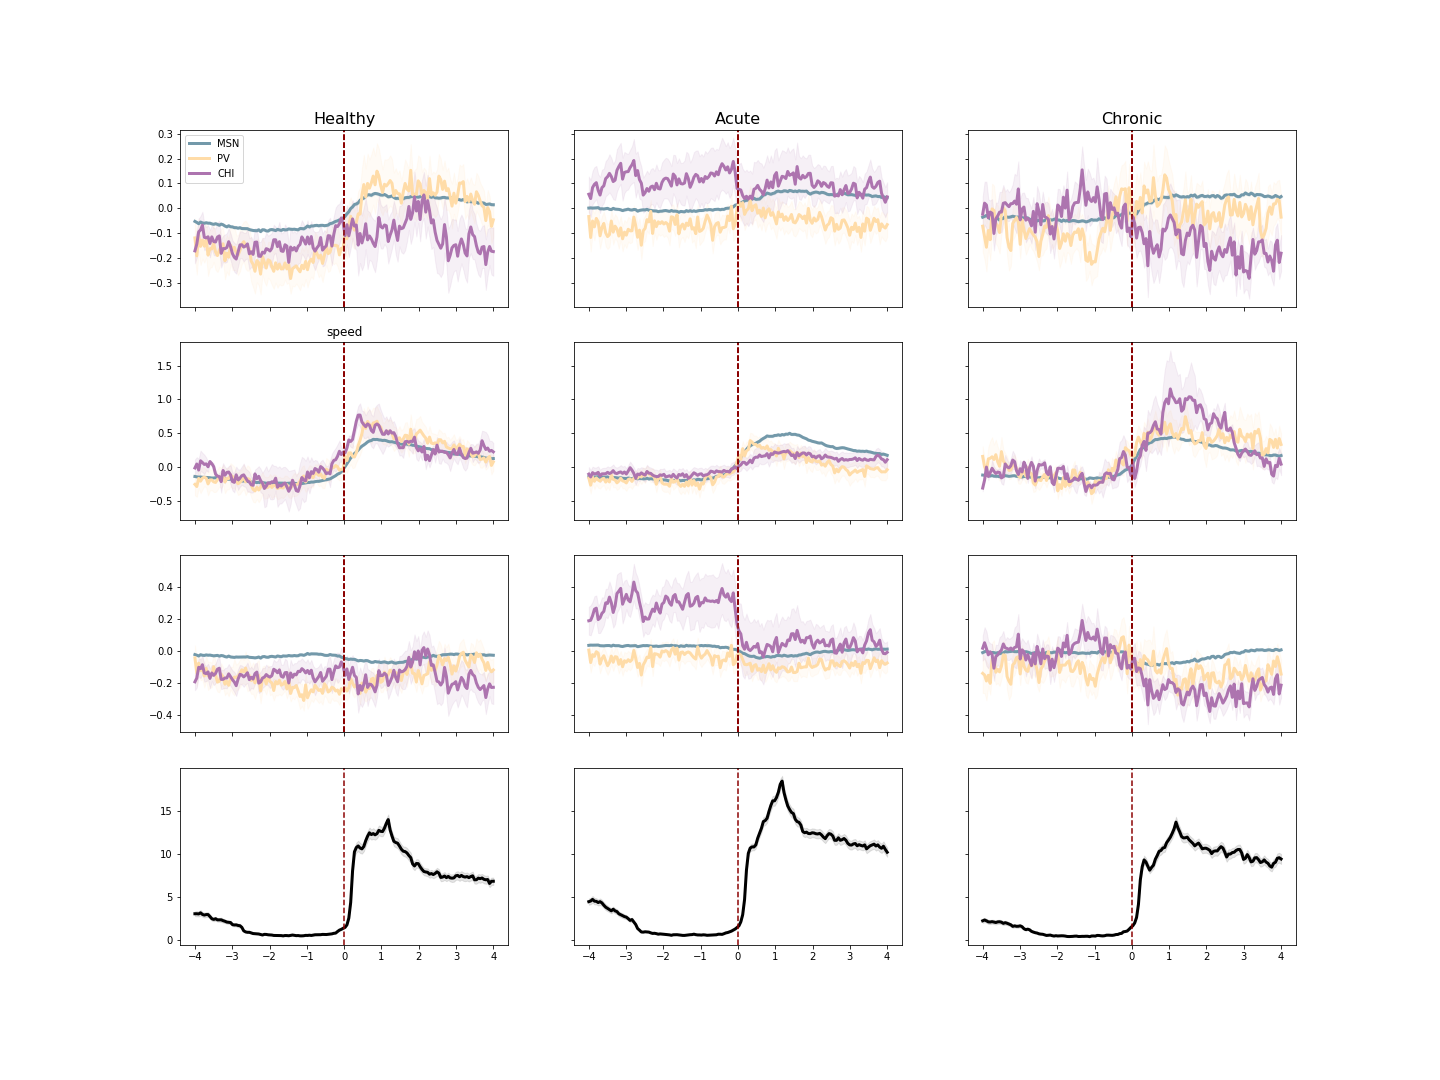

D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype

In [436]:
fig, ax = plt.subplots(4,3,figsize=(20, 15),sharex='col',sharey='row')
Colors = CP('creType')

#cond = ['PVdataH','PVdataP','MSNdataH','MSNdataP','CHIdataH','CHIdataP']
cond = ['MSN','PV','CHI']
Period = {'Healthy':0,'Acute':1,'Chronic':2}

# set the time range to plot: (Assuming all data is in 20Hz, if dataset changes, change this!)
preS = 80 #2s
PostS = 80 # 2s
dt = 0.05

tPlot = np.linspace(-preS*dt,PostS*dt,preS+PostS)
quant = []

for p in Period.keys():
    axInd = 0;
    for c in cond:
        data = eval(c+str(Period[p]))
        for s in data.keys():
            m = s[:4]
            speed = data[s]['speed']['speed'].T
            dff = data[s]['trace']['dff']
            # Vectors are saved as column vectors so.. transposed to raw vector
            if dff.shape[1] == 1:
                dff = dff.T
            # Z-score dff
            mu = np.mean(dff,axis=1)
            std = np.std(dff,axis=1)
            Zdff = (dff.T-mu.T)/std.T
            Zdff = Zdff.T  

            sOnset = getOnsetOrPeriod(m,s,'Pre','mvmtOnset2')    
            if np.sum(sOnset) == 0:
                continue
            
            care = df[(df.Sess == s)&(df.CellType == c)].care
            care = care.astype(bool)
            
            sA = alignToOnset(Zdff.T, sOnset, winPost=PostS,winPre=preS)  
            if dff.shape[0] ==1 and np.sum(sOnset)>0:

                try:
                    sA = np.reshape(sA,(sA.shape[0],1,sA.shape[1]))
                except:
                    sA = np.reshape(sA,(sA.shape[0],1,1))

            if len(sA.shape) > 2:
                sA = np.mean(sA,2)
                if 'sAligned' not in locals():
    #               print(s+' :',sA.shape)
                    sAligned = sA
                else:
    #                print(s+' :',sA.shape,sAligned.shape)
                    sAligned = np.concatenate((sAligned,sA),axis=1)

            if c == 'MSN':
                    sS = alignToOnset(speed, sOnset, winPost=PostS,winPre=preS)
                    if sS.ndim > 1:
                        if 'sAlignedS' not in locals():
            #           print(s+' :',sA.shape)
                            sAlignedS = sS
                        else:
        #                print(s+' :',cAs.shape,caAlignedS.shape)
                            sAlignedS = np.concatenate((sAlignedS,sS),axis=1) 
            try:
                Zdff_care = Zdff[care,:]
                Zdff_ncare = Zdff[~care,:]
            except Exception as e:
                exc_type, exc_obj, exc_tb = sys.exc_info()
                print(s,exc_tb.tb_lineno,care.shape,Zdff.shape)
                continue
            
            sA_care = alignToOnset(Zdff_care.T, sOnset, winPost=PostS,winPre=preS)  
            if Zdff_care.shape[0] ==1 and np.sum(sOnset)>0:

                try:
                    sA_care = np.reshape(sA_care,(sA_care.shape[0],1,sA_care.shape[1]))
                except:
                    sA_care = np.reshape(sA_care,(sA_care.shape[0],1,1))

            if len(sA_care.shape) > 2:
                sA_care = np.mean(sA_care,2)
                if 'sAligned_care' not in locals():
    #               print(s+' :',sA.shape)
                    sAligned_care = sA_care
                else:
    #                print(s+' :',sA.shape,sAligned.shape)
                    sAligned_care = np.concatenate((sAligned_care,sA_care),axis=1)
            
            sA_ncare = alignToOnset(Zdff_ncare.T, sOnset, winPost=PostS,winPre=preS)  
            if Zdff_ncare.shape[0] ==1 and np.sum(sOnset)>0:

                try:
                    sA_ncare = np.reshape(sA_ncare,(sA_ncare.shape[0],1,sA_ncare.shape[1]))
                except:
                    sA_ncare = np.reshape(sA_ncare,(sA_ncare.shape[0],1,1))

            if len(sA_ncare.shape) > 2:
                sA_ncare = np.mean(sA_ncare,2)
                if 'sAligned_ncare' not in locals():
    #               print(s+' :',sA.shape)
                    sAligned_ncare = sA_ncare
                else:
    #                print(s+' :',sA.shape,sAligned.shape)
                    sAligned_ncare = np.concatenate((sAligned_ncare,sA_ncare),axis=1)
      
        PlotRelativeToOnset(ax[0,Period[p]],sAligned,tPlot,Color=Colors[c],Label=c,mesErr=True) 
        PlotRelativeToOnset(ax[1,Period[p]],sAligned_care,tPlot,Color=Colors[c],Label=c,mesErr=True) 
        PlotRelativeToOnset(ax[2,Period[p]],sAligned_ncare,tPlot,Color=Colors[c],Label=c,mesErr=True) 
        if c== 'MSN':
            PlotRelativeToOnset(ax[3,Period[p]],sAlignedS,tPlot,Color='black',Label='speed',mesErr=True)
            del sAlignedS
        del sAligned
        del sAligned_care
        del sAligned_ncare
    ax[0,Period[p]].set_title(p,fontsize=16)
#    ax[0,Period[p]].legend(fontsize=10)
ax[0,0].legend(fontsize=10)
# ax[0,0].set_ylim(-0.5,0.5)
# ax[1,0].set_ylim(-0.5,1)
# ax[2,0].set_ylim(-0.5,0.75)
ax[1,0].set_title('speed')

fig.savefig(figFolder+'figure 4a.svg',transparent=True)

<IPython.core.display.Javascript object>


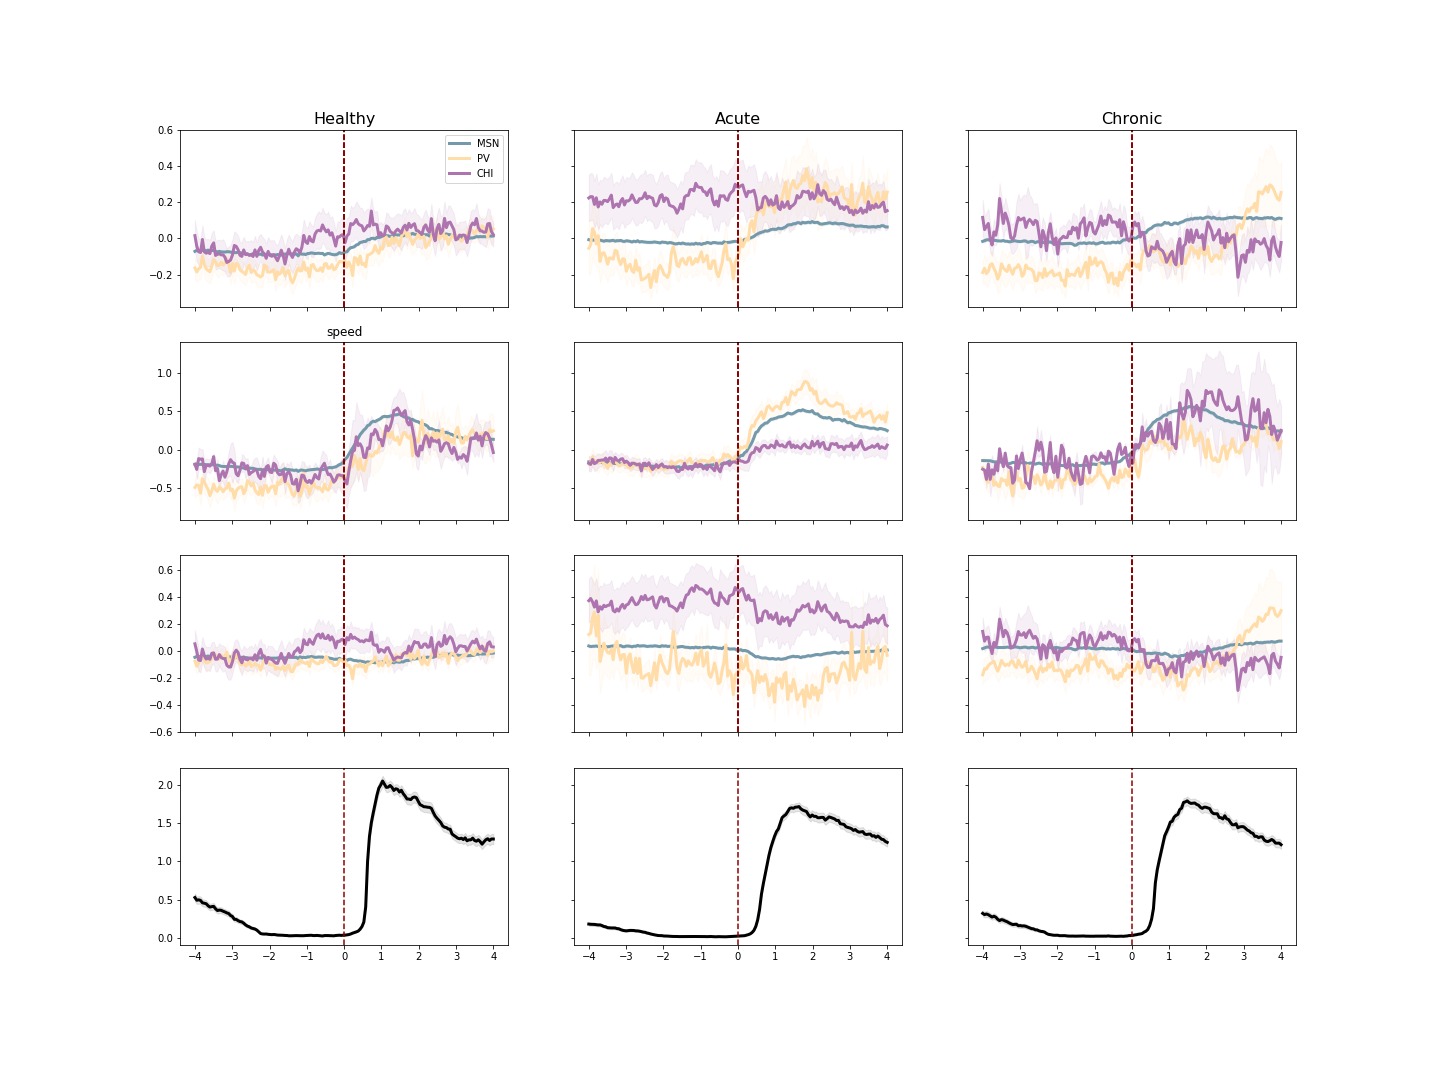

D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype

In [448]:
fig, ax = plt.subplots(4,3,figsize=(20, 15),sharex='col',sharey='row')
Colors = CP('creType')

#cond = ['PVdataH','PVdataP','MSNdataH','MSNdataP','CHIdataH','CHIdataP']
cond = ['MSN','PV','CHI']
Period = {'Healthy':0,'Acute':1,'Chronic':2}

# set the time range to plot: (Assuming all data is in 20Hz, if dataset changes, change this!)
preS = 80 #2s
PostS = 80 # 2s
dt = 0.05

tPlot = np.linspace(-preS*dt,PostS*dt,preS+PostS)
quant = []

for p in Period.keys():
    axInd = 0;
    for c in cond:
        data = eval(c+str(Period[p]))
        for s in data.keys():
            m = s[:4]
            speed = data[s]['rot']['rot'].T
            dff = data[s]['trace']['dff']
            # Vectors are saved as column vectors so.. transposed to raw vector
            if dff.shape[1] == 1:
                dff = dff.T
            # Z-score dff
            mu = np.mean(dff,axis=1)
            std = np.std(dff,axis=1)
            Zdff = (dff.T-mu.T)/std.T
            Zdff = Zdff.T  

            cOnset =  getOnsetOrPeriod(m,s,'Pre','clockWiseOnset') 
            acOnset = getOnsetOrPeriod(m,s,'Pre','antiClockWiseOnset')  
            sOnset = cOnset+acOnset    
            if np.sum(sOnset) == 0:
                continue
            
            care = df[(df.Sess == s)&(df.CellType == c)].care_rot
            care = care.astype(bool)
            
            sA = alignToOnset(Zdff.T, sOnset, winPost=PostS,winPre=preS)  
            if dff.shape[0] ==1 and np.sum(sOnset)>0:

                try:
                    sA = np.reshape(sA,(sA.shape[0],1,sA.shape[1]))
                except:
                    sA = np.reshape(sA,(sA.shape[0],1,1))

            if len(sA.shape) > 2:
                sA = np.mean(sA,2)
                if 'sAligned' not in locals():
    #               print(s+' :',sA.shape)
                    sAligned = sA
                else:
    #                print(s+' :',sA.shape,sAligned.shape)
                    sAligned = np.concatenate((sAligned,sA),axis=1)

            if c == 'MSN':
                    sS = alignToOnset(np.abs(speed), sOnset, winPost=PostS,winPre=preS)
                    if sS.ndim > 1:
                        if 'sAlignedS' not in locals():
            #           print(s+' :',sA.shape)
                            sAlignedS = sS
                        else:
        #                print(s+' :',cAs.shape,caAlignedS.shape)
                            sAlignedS = np.concatenate((sAlignedS,sS),axis=1) 
            try:
                Zdff_care = Zdff[care,:]
                Zdff_ncare = Zdff[~care,:]
            except Exception as e:
                exc_type, exc_obj, exc_tb = sys.exc_info()
                print(s,exc_tb.tb_lineno,care.shape,Zdff.shape)
                continue
            
            sA_care = alignToOnset(Zdff_care.T, sOnset, winPost=PostS,winPre=preS)  
            if Zdff_care.shape[0] ==1 and np.sum(sOnset)>0:

                try:
                    sA_care = np.reshape(sA_care,(sA_care.shape[0],1,sA_care.shape[1]))
                except:
                    sA_care = np.reshape(sA_care,(sA_care.shape[0],1,1))

            if len(sA_care.shape) > 2:
                sA_care = np.mean(sA_care,2)
                if 'sAligned_care' not in locals():
    #               print(s+' :',sA.shape)
                    sAligned_care = sA_care
                else:
    #                print(s+' :',sA.shape,sAligned.shape)
                    sAligned_care = np.concatenate((sAligned_care,sA_care),axis=1)
            
            sA_ncare = alignToOnset(Zdff_ncare.T, sOnset, winPost=PostS,winPre=preS)  
            if Zdff_ncare.shape[0] ==1 and np.sum(sOnset)>0:

                try:
                    sA_ncare = np.reshape(sA_ncare,(sA_ncare.shape[0],1,sA_ncare.shape[1]))
                except:
                    sA_ncare = np.reshape(sA_ncare,(sA_ncare.shape[0],1,1))

            if len(sA_ncare.shape) > 2:
                sA_ncare = np.mean(sA_ncare,2)
                if 'sAligned_ncare' not in locals():
    #               print(s+' :',sA.shape)
                    sAligned_ncare = sA_ncare
                else:
    #                print(s+' :',sA.shape,sAligned.shape)
                    sAligned_ncare = np.concatenate((sAligned_ncare,sA_ncare),axis=1)
      
        PlotRelativeToOnset(ax[0,Period[p]],sAligned,tPlot,Color=Colors[c],Label=c,mesErr=True) 
        PlotRelativeToOnset(ax[1,Period[p]],sAligned_care,tPlot,Color=Colors[c],Label=c,mesErr=True) 
        PlotRelativeToOnset(ax[2,Period[p]],sAligned_ncare,tPlot,Color=Colors[c],Label=c,mesErr=True) 
        if c== 'MSN':
            PlotRelativeToOnset(ax[3,Period[p]],sAlignedS,tPlot,Color='black',Label='speed',mesErr=True)
            del sAlignedS
        del sAligned
        del sAligned_care
        del sAligned_ncare
    ax[0,Period[p]].set_title(p,fontsize=16)
#    ax[0,Period[p]].legend(fontsize=10)
ax[0,0].legend(fontsize=10)
# ax[0,0].set_ylim(-0.5,0.5)
# ax[1,0].set_ylim(-0.5,1)
# ax[2,0].set_ylim(-0.5,0.75)
ax[1,0].set_title('speed')

fig.savefig(figFolder+'figure 4a_rot.svg',transparent=True)

In [439]:
f = h5py.File('membership.hdf5','r')
miceList = getMiceList(Files[1])
col_names = ['Sess','Mouse','Period','Day','CellType']
df = pd.DataFrame(columns=col_names)
for m in miceList:
    grp = f[m]
    sessions = list(grp.keys())
    for sess in sessions:
        try:
            care_ipsi = grp[sess]['ipsiOnset']['result'].value
        except:
            print(sess,'mvmt')
            care_ipsi = np.nan
            
        try:
            care_contra = grp[sess]['contraOnset']['result'].value
        except:
            print(sess,'rot')
            care_contra = np.nan
        
        if sess[5] == 'B':
                day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        cre = getCreType(Files[1],m)
        nRed = getNumRed(Files[1],m,sess[5:])
        try:
            df2 = pd.DataFrame({'Sess':sess,'Mouse':m,'Period':periodCalc(day),
                                'Day':day,'CellType':'MSN',
                                'care_ipsi':care_ipsi,
                                'care_contra':care_contra})
        except:
            df2 = pd.DataFrame({'Sess':sess,'Mouse':m,'Period':periodCalc(day),
                                'Day':day,'CellType':'MSN',
                                'care_ipsi':care_ipsi,
                                'care_contra':care_contra},index = [0])
        df2.loc[:nRed-1,'CellType'] = cre
        df = pd.concat([df,df2],sort=True)
df.Period = df.Period.astype("category")
df.Period = df.Period.cat.reorder_categories(['Healthy', 'Acute', 'Chronic'])
df['care_ipsi'] = df.care_ipsi.astype('float')
df['care_contra'] = df.care_contra.astype('float')


<ipython-input-439-60848c236108>:10: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  care_ipsi = grp[sess]['ipsiOnset']['result'].value
<ipython-input-439-60848c236108>:16: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  care_contra = grp[sess]['contraOnset']['result'].value


0761_day10 mvmt
0761_day12 mvmt
0761_day19L mvmt
0761_day2 mvmt
0761_day31A mvmt
0761_day35L mvmt
0761_day6 mvmt
0761_day8 mvmt
1208_day15A mvmt
1208_day19L mvmt
1208_day2 mvmt
1208_day34L mvmt
1222_day11 rot
1222_day20L rot
1222_day36L mvmt
1222_day5 rot
1231_BaselineL rot
1231_BaselineS rot
1236_day13 mvmt
1793_BaselineA mvmt
1793_day12 mvmt
1793_day14 mvmt
2976_BaselineA rot
2976_day14 mvmt
2976_day35L mvmt
2976_day8 mvmt
2976_day8 rot
2980_day14 mvmt
2980_day15A rot
2980_day19L mvmt
2980_day8 mvmt
2981_day10 rot
2981_day12 rot
2981_day15A mvmt
2981_day2 rot
2981_day6 rot
2981_day8 rot
4539_BaselineA rot
4539_day1 mvmt
4539_day1 rot
4539_day10 mvmt
4539_day10 rot
4539_day11 mvmt
4539_day11 rot
4539_day12 mvmt
4539_day12 rot
4539_day13 mvmt
4539_day13 rot
4539_day14 mvmt
4539_day14 rot
4539_day2 mvmt
4539_day2 rot
4539_day3 mvmt
4539_day3 rot
4539_day30A rot
4539_day4 mvmt
4539_day4 rot
4539_day5 mvmt
4539_day5 rot
4539_day6 mvmt
4539_day6 rot
4539_day7 mvmt
4539_day7 rot
4539_day8 m

<IPython.core.display.Javascript object>


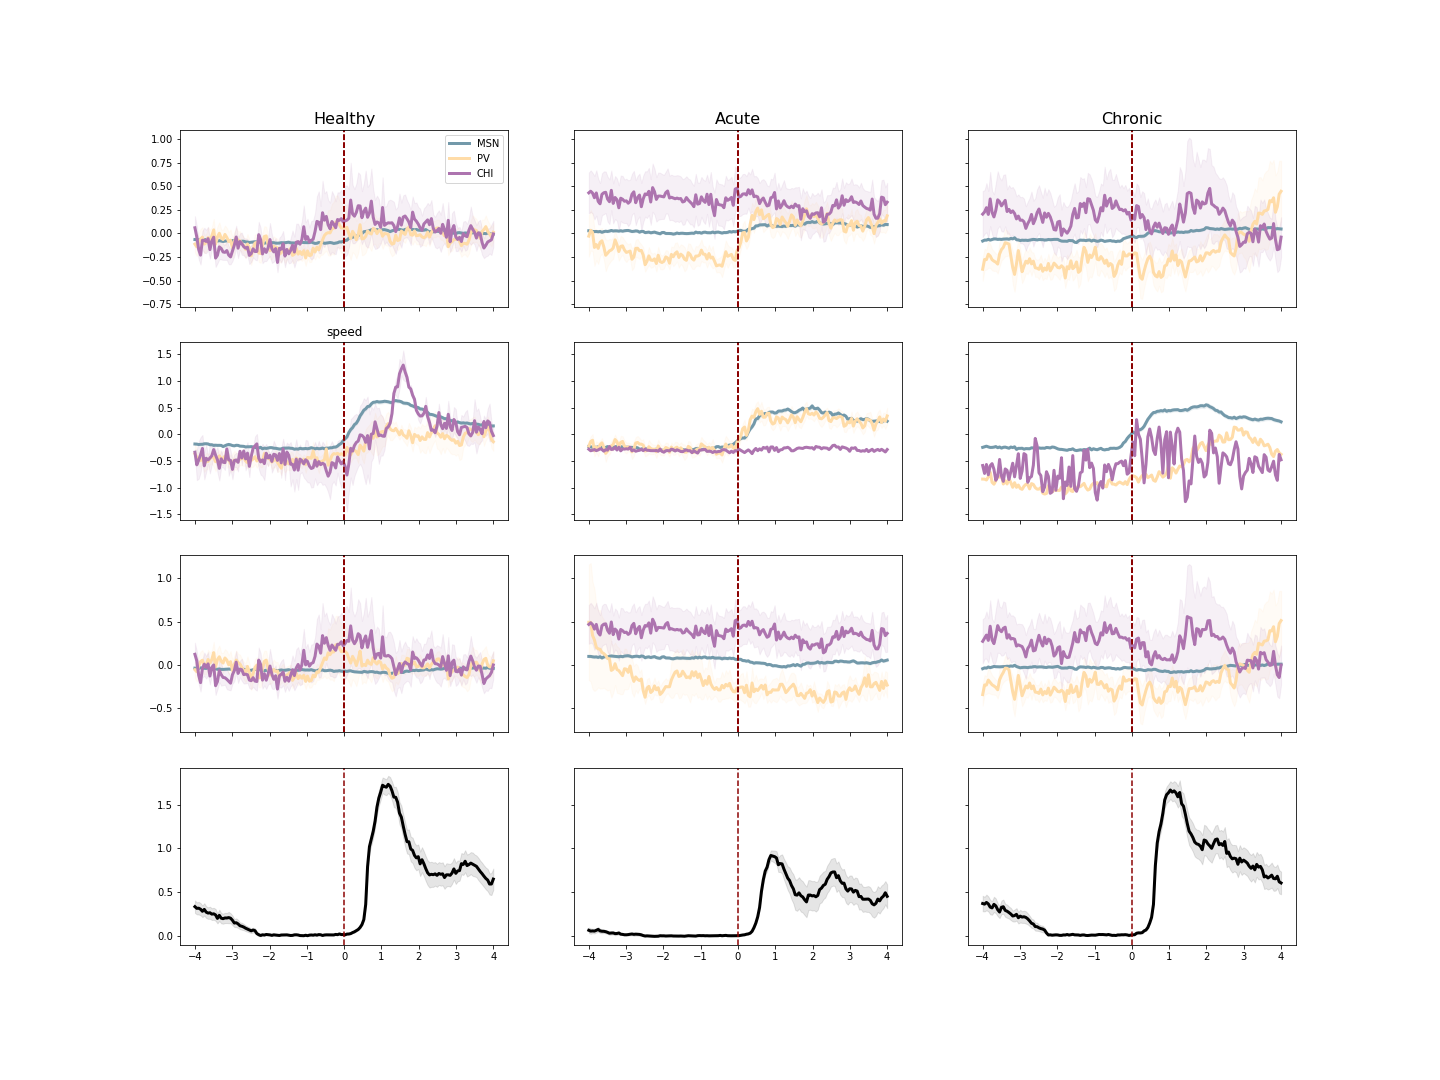

D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype

In [445]:
fig, ax = plt.subplots(4,3,figsize=(20, 15),sharex='col',sharey='row')
Colors = CP('creType')

#cond = ['PVdataH','PVdataP','MSNdataH','MSNdataP','CHIdataH','CHIdataP']
cond = ['MSN','PV','CHI']
Period = {'Healthy':0,'Acute':1,'Chronic':2}

# set the time range to plot: (Assuming all data is in 20Hz, if dataset changes, change this!)
preS = 80 #2s
PostS = 80 # 2s
dt = 0.05

tPlot = np.linspace(-preS*dt,PostS*dt,preS+PostS)
quant = []

for p in Period.keys():
    axInd = 0;
    for c in cond:
        data = eval(c+str(Period[p]))
        for s in data.keys():
            m = s[:4]
            speed = data[s]['rot']['rot'].T
            dff = data[s]['trace']['dff']
            # Vectors are saved as column vectors so.. transposed to raw vector
            if dff.shape[1] == 1:
                dff = dff.T
            # Z-score dff
            mu = np.mean(dff,axis=1)
            std = np.std(dff,axis=1)
            Zdff = (dff.T-mu.T)/std.T
            Zdff = Zdff.T  

            
            sOnset = getOnsetOrPeriod(m,s,'Pre','antiClockWiseOnset')  
                
            if np.sum(sOnset) == 0:
                continue
            
            care = df[(df.Sess == s)&(df.CellType == c)].care_ipsi
            care = care.astype(bool)
            
            sA = alignToOnset(Zdff.T, sOnset, winPost=PostS,winPre=preS)  
            if dff.shape[0] ==1 and np.sum(sOnset)>0:

                try:
                    sA = np.reshape(sA,(sA.shape[0],1,sA.shape[1]))
                except:
                    sA = np.reshape(sA,(sA.shape[0],1,1))

            if len(sA.shape) > 2:
                sA = np.mean(sA,2)
                if 'sAligned' not in locals():
    #               print(s+' :',sA.shape)
                    sAligned = sA
                else:
    #                print(s+' :',sA.shape,sAligned.shape)
                    sAligned = np.concatenate((sAligned,sA),axis=1)

            if c == 'MSN':
                    sS = alignToOnset(speed, sOnset, winPost=PostS,winPre=preS)
                    if sS.ndim > 1:
                        if 'sAlignedS' not in locals():
            #           print(s+' :',sA.shape)
                            sAlignedS = sS
                        else:
        #                print(s+' :',cAs.shape,caAlignedS.shape)
                            sAlignedS = np.concatenate((sAlignedS,sS),axis=1) 
            try:
                Zdff_care = Zdff[care,:]
                Zdff_ncare = Zdff[~care,:]
            except Exception as e:
                exc_type, exc_obj, exc_tb = sys.exc_info()
                print(s,exc_tb.tb_lineno,care.shape,Zdff.shape)
                continue
            
            sA_care = alignToOnset(Zdff_care.T, sOnset, winPost=PostS,winPre=preS)  
            if Zdff_care.shape[0] ==1 and np.sum(sOnset)>0:

                try:
                    sA_care = np.reshape(sA_care,(sA_care.shape[0],1,sA_care.shape[1]))
                except:
                    sA_care = np.reshape(sA_care,(sA_care.shape[0],1,1))

            if len(sA_care.shape) > 2:
                sA_care = np.mean(sA_care,2)
                if 'sAligned_care' not in locals():
    #               print(s+' :',sA.shape)
                    sAligned_care = sA_care
                else:
    #                print(s+' :',sA.shape,sAligned.shape)
                    sAligned_care = np.concatenate((sAligned_care,sA_care),axis=1)
            
            sA_ncare = alignToOnset(Zdff_ncare.T, sOnset, winPost=PostS,winPre=preS)  
            if Zdff_ncare.shape[0] ==1 and np.sum(sOnset)>0:

                try:
                    sA_ncare = np.reshape(sA_ncare,(sA_ncare.shape[0],1,sA_ncare.shape[1]))
                except:
                    sA_ncare = np.reshape(sA_ncare,(sA_ncare.shape[0],1,1))

            if len(sA_ncare.shape) > 2:
                sA_ncare = np.mean(sA_ncare,2)
                if 'sAligned_ncare' not in locals():
    #               print(s+' :',sA.shape)
                    sAligned_ncare = sA_ncare
                else:
    #                print(s+' :',sA.shape,sAligned.shape)
                    sAligned_ncare = np.concatenate((sAligned_ncare,sA_ncare),axis=1)
      
        PlotRelativeToOnset(ax[0,Period[p]],sAligned,tPlot,Color=Colors[c],Label=c,mesErr=True) 
        PlotRelativeToOnset(ax[1,Period[p]],sAligned_care,tPlot,Color=Colors[c],Label=c,mesErr=True) 
        PlotRelativeToOnset(ax[2,Period[p]],sAligned_ncare,tPlot,Color=Colors[c],Label=c,mesErr=True) 
        if c== 'MSN':
            PlotRelativeToOnset(ax[3,Period[p]],sAlignedS,tPlot,Color='black',Label='speed',mesErr=True)
            del sAlignedS
        del sAligned
        del sAligned_care
        del sAligned_ncare
    ax[0,Period[p]].set_title(p,fontsize=16)
#    ax[0,Period[p]].legend(fontsize=10)
ax[0,0].legend(fontsize=10)
# ax[0,0].set_ylim(-0.5,0.5)
# ax[1,0].set_ylim(-0.5,1)
# ax[2,0].set_ylim(-0.5,0.75)
ax[1,0].set_title('speed')

fig.savefig(figFolder+'figure 4a_contra.svg',transparent=True)

<IPython.core.display.Javascript object>


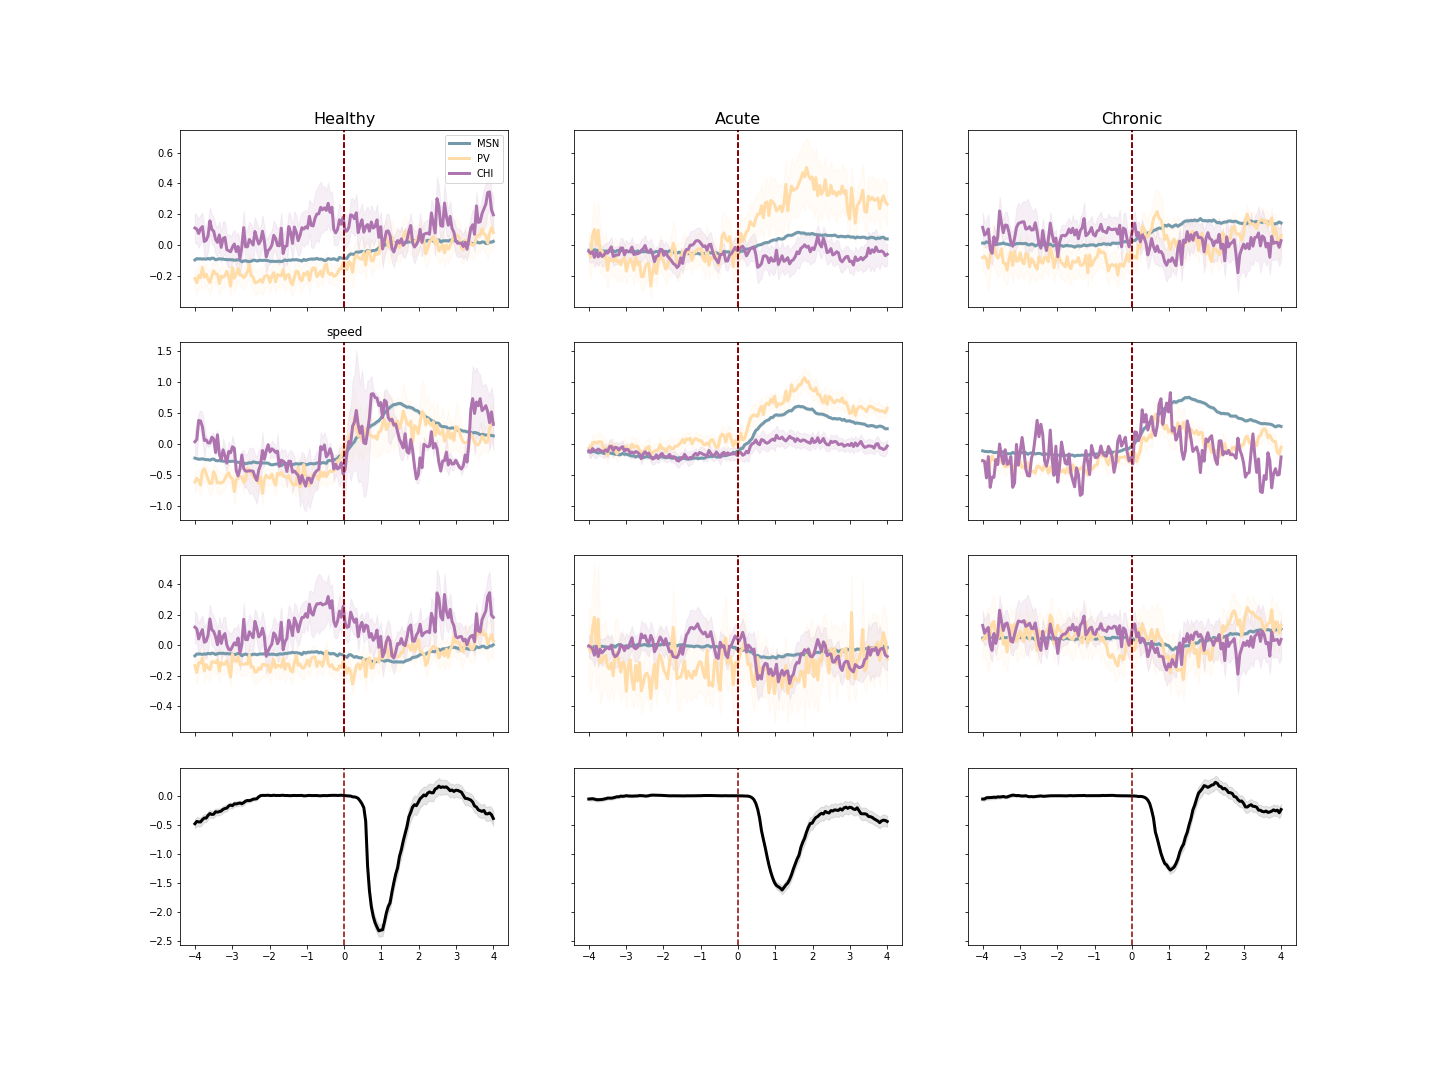

D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype

In [444]:
fig, ax = plt.subplots(4,3,figsize=(20, 15),sharex='col',sharey='row')
Colors = CP('creType')

#cond = ['PVdataH','PVdataP','MSNdataH','MSNdataP','CHIdataH','CHIdataP']
cond = ['MSN','PV','CHI']
Period = {'Healthy':0,'Acute':1,'Chronic':2}

# set the time range to plot: (Assuming all data is in 20Hz, if dataset changes, change this!)
preS = 80 #2s
PostS = 80 # 2s
dt = 0.05

tPlot = np.linspace(-preS*dt,PostS*dt,preS+PostS)
quant = []

for p in Period.keys():
    axInd = 0;
    for c in cond:
        data = eval(c+str(Period[p]))
        for s in data.keys():
            m = s[:4]
            speed = data[s]['rot']['rot'].T
            dff = data[s]['trace']['dff']
            # Vectors are saved as column vectors so.. transposed to raw vector
            if dff.shape[1] == 1:
                dff = dff.T
            # Z-score dff
            mu = np.mean(dff,axis=1)
            std = np.std(dff,axis=1)
            Zdff = (dff.T-mu.T)/std.T
            Zdff = Zdff.T  

            sOnset =  getOnsetOrPeriod(m,s,'Pre','clockWiseOnset')  
            if np.sum(sOnset) == 0:
                continue
            
            care = df[(df.Sess == s)&(df.CellType == c)].care_contra
            care = care.astype(bool)
            
            sA = alignToOnset(Zdff.T, sOnset, winPost=PostS,winPre=preS)  
            if dff.shape[0] ==1 and np.sum(sOnset)>0:

                try:
                    sA = np.reshape(sA,(sA.shape[0],1,sA.shape[1]))
                except:
                    sA = np.reshape(sA,(sA.shape[0],1,1))

            if len(sA.shape) > 2:
                sA = np.mean(sA,2)
                if 'sAligned' not in locals():
    #               print(s+' :',sA.shape)
                    sAligned = sA
                else:
    #                print(s+' :',sA.shape,sAligned.shape)
                    sAligned = np.concatenate((sAligned,sA),axis=1)

            if c == 'MSN':
                    sS = alignToOnset(speed, sOnset, winPost=PostS,winPre=preS)
                    if sS.ndim > 1:
                        if 'sAlignedS' not in locals():
            #           print(s+' :',sA.shape)
                            sAlignedS = sS
                        else:
        #                print(s+' :',cAs.shape,caAlignedS.shape)
                            sAlignedS = np.concatenate((sAlignedS,sS),axis=1) 
            try:
                Zdff_care = Zdff[care,:]
                Zdff_ncare = Zdff[~care,:]
            except Exception as e:
                exc_type, exc_obj, exc_tb = sys.exc_info()
                print(s,exc_tb.tb_lineno,care.shape,Zdff.shape)
                continue
            
            sA_care = alignToOnset(Zdff_care.T, sOnset, winPost=PostS,winPre=preS)  
            if Zdff_care.shape[0] ==1 and np.sum(sOnset)>0:

                try:
                    sA_care = np.reshape(sA_care,(sA_care.shape[0],1,sA_care.shape[1]))
                except:
                    sA_care = np.reshape(sA_care,(sA_care.shape[0],1,1))

            if len(sA_care.shape) > 2:
                sA_care = np.mean(sA_care,2)
                if 'sAligned_care' not in locals():
    #               print(s+' :',sA.shape)
                    sAligned_care = sA_care
                else:
    #                print(s+' :',sA.shape,sAligned.shape)
                    sAligned_care = np.concatenate((sAligned_care,sA_care),axis=1)
            
            sA_ncare = alignToOnset(Zdff_ncare.T, sOnset, winPost=PostS,winPre=preS)  
            if Zdff_ncare.shape[0] ==1 and np.sum(sOnset)>0:

                try:
                    sA_ncare = np.reshape(sA_ncare,(sA_ncare.shape[0],1,sA_ncare.shape[1]))
                except:
                    sA_ncare = np.reshape(sA_ncare,(sA_ncare.shape[0],1,1))

            if len(sA_ncare.shape) > 2:
                sA_ncare = np.mean(sA_ncare,2)
                if 'sAligned_ncare' not in locals():
    #               print(s+' :',sA.shape)
                    sAligned_ncare = sA_ncare
                else:
    #                print(s+' :',sA.shape,sAligned.shape)
                    sAligned_ncare = np.concatenate((sAligned_ncare,sA_ncare),axis=1)
      
        PlotRelativeToOnset(ax[0,Period[p]],sAligned,tPlot,Color=Colors[c],Label=c,mesErr=True) 
        PlotRelativeToOnset(ax[1,Period[p]],sAligned_care,tPlot,Color=Colors[c],Label=c,mesErr=True) 
        PlotRelativeToOnset(ax[2,Period[p]],sAligned_ncare,tPlot,Color=Colors[c],Label=c,mesErr=True) 
        if c== 'MSN':
            PlotRelativeToOnset(ax[3,Period[p]],sAlignedS,tPlot,Color='black',Label='speed',mesErr=True)
            del sAlignedS
        del sAligned
        del sAligned_care
        del sAligned_ncare
    ax[0,Period[p]].set_title(p,fontsize=16)
#    ax[0,Period[p]].legend(fontsize=10)
ax[0,0].legend(fontsize=10)
# ax[0,0].set_ylim(-0.5,0.5)
# ax[1,0].set_ylim(-0.5,1)
# ax[2,0].set_ylim(-0.5,0.75)
ax[1,0].set_title('speed')

fig.savefig(figFolder+'figure 4a_ipsi.svg',transparent=True)

Howard stuff starts here:

In [101]:
# f = h5py.File('D:\\6OHDA\\Spectograms.hdf5','r') 
# m = '1208'
# sess = m+'_BaselineA'
# freq = f[m][sess]['Pre']['freq'][:]
# coeff = np.abs(f[m][sess]['Pre']['coeff'][:])
# data =  getData(Files[0],['lfp'],period ='Pre', mice=m)
# lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
# coeff = coeff[:,(lfpOutliers[:,0]==0)]
# Hs = np.nansum(coeff, axis=1)
# coeff = coeff.T/Hs.T
# coeff = coeff.T
print(np.sum(coeff,axis=1).shape)

(87,)


0.0005483021713982424


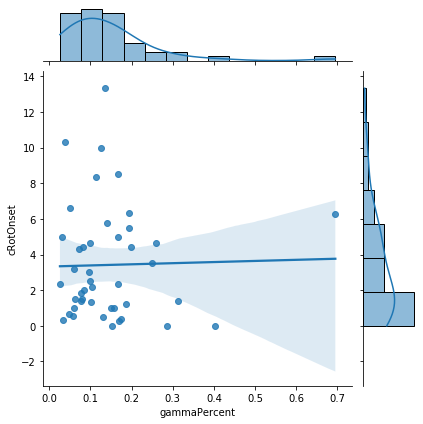

In [161]:
# sns.scatterplot(x='gammaPercent',y='cRotOnset',hue = 'Period',data = df2)
sns.jointplot(x='gammaPercent',y='cRotOnset',data = df2, kind="reg")
print(r2(df2.gammaPercent,df2.cRotOnset))

0.07290474357383947


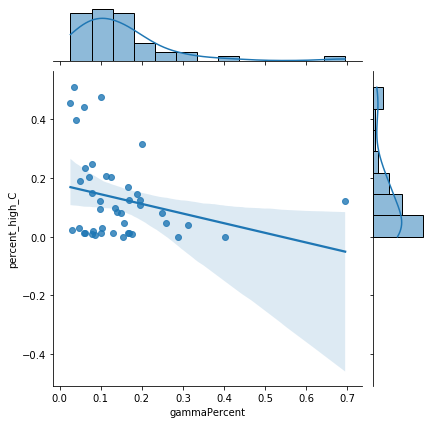

In [162]:
# sns.scatterplot(x='gammaPercent',y='percent_high_C',hue = 'Period',data = df2)
sns.jointplot(x='gammaPercent',y='percent_high_C',data = df2, kind="reg")
print(r2(df2.gammaPercent,df2.percent_high_C))

0.02368362482796734


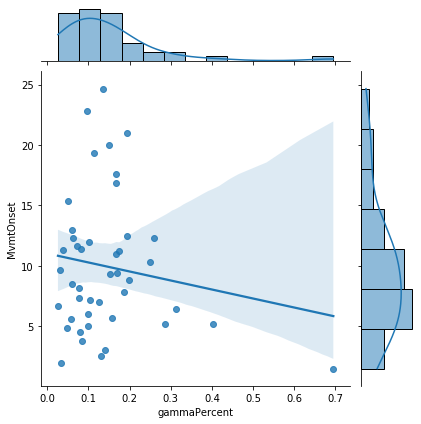

In [163]:
# sns.scatterplot(x='gammaPercent',y='MvmtOnset',hue = 'Period',data = df2)
sns.jointplot(x='gammaPercent',y='MvmtOnset',data = df2, kind="reg")
print(r2(df2.gammaPercent,df2.MvmtOnset))

In [84]:
Pdf = pd.read_csv(figFolder+'gammaSort.csv')
Pdf['gammaPercent'] = Pdf.gamma.apply(lambda x: x>=0.75)
Pdf =Pdf.groupby(['Sess','Period']).mean()
Pdf = Pdf.reset_index()
# Pdf['Mouse']=Pdf['Mouse'].astype(int)
# Pdf.dtypes

In [85]:
df = pd.read_csv(figFolder+'speedData.csv')
df = df.groupby(['Session','Period']).mean()
df = df.reset_index()
df = df.rename(columns={"Session":'Sess'})
# print(df)
# print(df.dtypes)
df2 = pd.merge(Pdf,df[['Sess','Period','MvmtOnset']],on=['Sess','Period'])
df = pd.read_csv(figFolder+'rotation_forR.csv')
df = df.groupby(['Session','Period']).mean()
df = df.reset_index()
df = df.rename(columns={"Session":'Sess'})
df2 = pd.merge(df2,df[['Sess','Period','cRotOnset','rotOnset','percent_high_C','percent_high_AC']],on=['Sess','Period'])
df2

Sess     Period  Unnamed: 0   Mouse     gamma  cellNum  \
0    0761_BaselineA    Healthy         5.0   761.0  0.427110      5.0   
1    0761_BaselineL    Healthy         7.5   761.0  0.362527      7.5   
2    0761_BaselineS    Healthy        13.0   761.0  0.491119     13.0   
3        0761_day10   Day 1-13         5.5   761.0  0.360169      5.5   
4        0761_day12   Day 1-13         2.0   761.0  0.121943      2.0   
..              ...        ...         ...     ...       ...      ...   
204       8815_day2   Day 1-13         4.5  8815.0  0.029757      4.5   
205     8815_day30A  Day 14-35        39.0  8815.0  0.169259     39.0   
206     8815_day34L  Day 14-35        33.5  8815.0  0.085633     33.5   
207       8815_day4   Day 1-13        18.0  8815.0  0.249947     18.0   
208       8815_day8   Day 1-13        47.5  8815.0  0.091639     47.5   

     gammaPercent  MvmtOnset  cRotOnset  rotOnset  percent_high_C  \
0        0.181818         14          3        13        0.042104   
1        0.187500         15          3        17        0.030759   
2        0.407407          8          8         9        0.067233   
3        0.166667          8          0         4        0.006555   
4        0.200000          6          0         3        0.012437   
..            ...        ...        ...       ...             ...   
204      0.000000         16          1        11        0.042605   
205      0.151899          7          0         4        0.002017   
206      0.044118         16         11        15        0.043361   
207      0.189189          4          1         4        0.026303   
208      0.072917          7          2         4        0.043866   

     percent_high_AC  
0           0.115976  
1           0.178418  
2           0.178839  
3           0.142533  
4           0.074118  
..               ...  
204         0.043277  
205         0.045630  
206         0.044538  
207         0.106050  
208         0.067815  

[209 rows x 12 columns]

In [50]:
%matplotlib inline

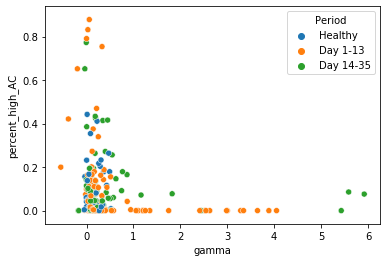

In [72]:
sns.scatterplot(x='gamma',y='percent_high_AC',hue = 'Period',data = df2)

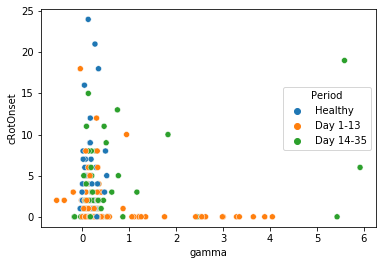

In [73]:
sns.scatterplot(x='gamma',y='cRotOnset',hue = 'Period',data = df2)

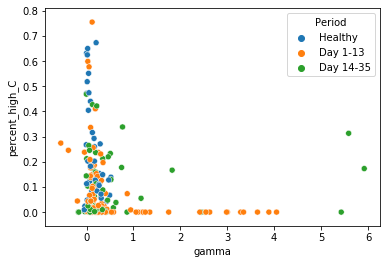

In [74]:
sns.scatterplot(x='gamma',y='percent_high_C',hue = 'Period',data = df2)

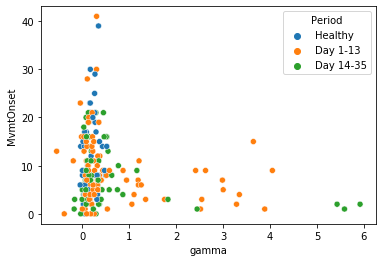

In [75]:
sns.scatterplot(x='gamma',y='MvmtOnset',hue = 'Period',data = df2)

In [97]:
# spectrom in high/low mvmt
f = h5py.File('Spectograms.hdf5','r')

miceList = getMiceList(Files[0])
specs = {}
for m in tqdm(miceList):  
    data =  getData(Files[0],['lfp','speed'],period ='Post', mice=m, drug = b'L-Dopa')
    
    for sess in data:
        try:
            if sess[5] == 'B':
                day = 0
            else:
                day = int(re.findall(r'\d+',sess[5:])[0])

            # get data
            dtS = 1/data[sess]['speed']['Fs']
            dtL = 1/data[sess]['lfp']['FS']
            ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
            tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL


            highAC = getOnsetOrPeriod(m,sess,'Post','hiACRotPeriods_vector')
            highC = getOnsetOrPeriod(m,sess,'Post','hiCRotPeriods_vector')
            lowRot = getOnsetOrPeriod(m,sess,'Post','loRotPeriods_vector')
            lowSpeed = getOnsetOrPeriod(m,sess,'Post','LowMvmtPeriods_vector')
            hiSpeed = getOnsetOrPeriod(m,sess,'Post','HighMvmtPeriods_vector')
            tempDict = {'mouse':m,'day':day,'period':periodCalc(day)}

            freq = f[m]['freq'].value
            coeff = np.abs(f[m][sess]['Post']['coeff'].value)
            lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
            coeff[:,(lfpOutliers[:,0]==1)] = np.nan
            coeff = coeff.T
            
            Hs = np.nansum(coeff, axis=1)
            Hs2 = coeff.T/Hs.T
            Hs2 = Hs2.T
            tempDict['all'] = np.nanmean(Hs2,axis=0, keepdims=True)


            for mv in ['highAC','highC','lowRot','lowSpeed','hiSpeed']:
                Himvmt = np.full_like(tl,False)
                mVector = eval(mv)
                if np.sum(mVector) == 0:
                    continue
                V = np.append(mVector[1:]*1-mVector[:-1]*1,0)
                HpStart = ts[V==1]
                HpEnd = ts[V==-1]
                if mVector[0] == 1:
                    HpStart = np.insert(HpStart,0,0)
                for segI, seg in enumerate(HpStart):
                    si = np.argmin(np.abs(tl-seg))
                    se = np.argmin(np.abs(tl-HpEnd[segI])
                                  )
                    Himvmt[si:se] = True

                #coeff = np.delete(coeff,(56), axis=1)
                sessH = (Hs2[(Himvmt ==1),:])
#                 Hs = np.nansum(sessH, axis=0)
#                 Hs2 = sessH/Hs
                tempDict[mv] = np.nanmean(sessH,axis=0, keepdims=True)
            specs[sess] = tempDict
        except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess,exc_tb.tb_lineno)

df_normlizeByCol_meanPost = pd.DataFrame(specs)
df_normlizeByCol_meanPost = df_normlizeByCol_meanPost.T
# df.to_csv('specs_normlizeByRow_sum.csv')

  0%|          | 0/16 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  6%|▋         | 1/16 [01:13<18:20, 73.40s/it]

cleaning up lfp data
cleaning up speed data
found  3.0  outlier points
found  2.0  outlier points


 12%|█▎        | 2/16 [03:35<21:57, 94.12s/it]

cleaning up lfp data
cleaning up speed data


 19%|█▉        | 3/16 [05:50<23:02, 106.34s/it]

cleaning up lfp data
cleaning up speed data


 25%|██▌       | 4/16 [06:43<18:03, 90.31s/it] 

cleaning up lfp data
cleaning up speed data
found  447664.0  outlier points


 31%|███▏      | 5/16 [08:58<18:59, 103.56s/it]

cleaning up lfp data
cleaning up speed data


 38%|███▊      | 6/16 [09:45<14:27, 86.76s/it] 

cleaning up lfp data
cleaning up speed data


 44%|████▍     | 7/16 [11:34<14:01, 93.50s/it]

cleaning up lfp data
cleaning up speed data


 50%|█████     | 8/16 [14:20<15:22, 115.25s/it]

cleaning up lfp data
cleaning up speed data


 56%|█████▋    | 9/16 [16:06<13:06, 112.39s/it]

cleaning up lfp data
cleaning up speed data


 62%|██████▎   | 10/16 [18:13<11:41, 116.85s/it]

cleaning up lfp data
cleaning up speed data
cleaning up lfp data
cleaning up speed data
cleaning up lfp data
cleaning up speed data
cleaning up lfp data
cleaning up speed data


 88%|████████▊ | 14/16 [20:05<03:00, 90.14s/it] 

cleaning up lfp data
cleaning up speed data


 94%|█████████▍| 15/16 [21:54<01:35, 95.87s/it]

cleaning up lfp data
cleaning up speed data


100%|██████████| 16/16 [23:51<00:00, 89.49s/it] 


In [173]:
# spectrom in high/low mvmt
f = h5py.File('Spectograms.hdf5','r')

miceList = getMiceList(Files[0])
specs = {}
for m in tqdm(miceList):  
    data =  getData(Files[0],['lfp','speed'],period ='Pre', mice=m, drug = b'L-Dopa')
    
    for sess in data:
        try:
            if sess[5] == 'B':
                day = 0
            else:
                day = int(re.findall(r'\d+',sess[5:])[0])

            # get data
            dtS = 1/data[sess]['speed']['Fs']
            dtL = 1/data[sess]['lfp']['FS']
            ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
            tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL


            highAC = getOnsetOrPeriod(m,sess,'Pre','hiACRotPeriods_vector')
            highC = getOnsetOrPeriod(m,sess,'Pre','hiCRotPeriods_vector')
            lowRot = getOnsetOrPeriod(m,sess,'Pre','loRotPeriods_vector')
            lowSpeed = getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_vector')
            hiSpeed = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_vector')
            tempDict = {'mouse':m,'day':day,'period':periodCalc(day)}

            freq = f[m]['freq'].value
            coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
            lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
            coeff[:,(lfpOutliers[:,0]==1)] = np.nan
            coeff = coeff.T
            
            Hs = np.nansum(coeff, axis=1)
            Hs2 = coeff.T/Hs.T
            Hs2 = Hs2.T
            tempDict['all'] = np.nanmean(Hs2,axis=0, keepdims=True)


            for mv in ['highAC','highC','lowRot','lowSpeed','hiSpeed']:
                Himvmt = np.full_like(tl,False)
                mVector = eval(mv)
                if np.sum(mVector) == 0:
                    continue
                V = np.append(mVector[1:]*1-mVector[:-1]*1,0)
                HpStart = ts[V==1]
                HpEnd = ts[V==-1]
                if mVector[0] == 1:
                    HpStart = np.insert(HpStart,0,0)
                for segI, seg in enumerate(HpStart):
                    si = np.argmin(np.abs(tl-seg))
                    se = np.argmin(np.abs(tl-HpEnd[segI])
                                  )
                    Himvmt[si:se] = True

                #coeff = np.delete(coeff,(56), axis=1)
                sessH = (Hs2[(Himvmt ==1),:])
#                 Hs = np.nansum(sessH, axis=0)
#                 Hs2 = sessH/Hs
                tempDict[mv] = np.nanmean(sessH,axis=0, keepdims=True)
            specs[sess] = tempDict
        except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess,exc_tb.tb_lineno)

df_normlizeByCol_meanPre = pd.DataFrame(specs)
df_normlizeByCol_meanPre = df_normlizeByCol_meanPre.T
# df.to_csv('specs_normlizeByRow_sum.csv')

  0%|          | 0/16 [00:00<?, ?it/s]/home/dana_z/ssd_2TB/6OHDA/IO.py:152: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  speed = hf[m][s]['mvmt']['speed'].value
/home/dana_z/ssd_2TB/6OHDA/IO.py:48: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  lfp = hf[m][s]['ePhys']['lfp'].value


cleaning up lfp data
cleaning up speed data


/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  6%|▋         | 1/16 [00:26<06:30, 26.01s/it]

cleaning up lfp data
cleaning up speed data
found  17.0  outlier points


 12%|█▎        | 2/16 [00:58<06:30, 27.88s/it]

cleaning up lfp data
cleaning up speed data


 19%|█▉        | 3/16 [01:34<06:35, 30.40s/it]

cleaning up lfp data
cleaning up speed data


 25%|██▌       | 4/16 [01:45<04:55, 24.66s/it]

cleaning up lfp data
cleaning up speed data
found  481139.0  outlier points


 31%|███▏      | 5/16 [02:20<05:04, 27.68s/it]

cleaning up lfp data
cleaning up speed data


 38%|███▊      | 6/16 [02:32<03:50, 23.02s/it]

cleaning up lfp data
cleaning up speed data


 44%|████▍     | 7/16 [03:07<04:00, 26.70s/it]

cleaning up lfp data
cleaning up speed data


 50%|█████     | 8/16 [03:43<03:54, 29.30s/it]

cleaning up lfp data
cleaning up speed data


 56%|█████▋    | 9/16 [04:15<03:31, 30.17s/it]

cleaning up lfp data
cleaning up speed data


 62%|██████▎   | 10/16 [04:51<03:11, 31.90s/it]

cleaning up lfp data
cleaning up speed data
cleaning up lfp data
cleaning up speed data
cleaning up lfp data
cleaning up speed data
cleaning up lfp data
cleaning up speed data


 88%|████████▊ | 14/16 [05:23<00:49, 24.72s/it]

cleaning up lfp data
cleaning up speed data


 94%|█████████▍| 15/16 [05:56<00:27, 27.31s/it]

cleaning up lfp data
cleaning up speed data


100%|██████████| 16/16 [06:29<00:00, 24.35s/it]


In [174]:
# df = df_normlizeByCol_meanPost
df = df_normlizeByCol_meanPre
# df.groupby(['mouse','period'])
periods = {'Healthy':{'axis':0},'Day 1-13':{'axis':1},'Day 14-35':{'axis':2}}
conds = ['highAC','highC','lowRot','lowSpeed','hiSpeed','all']

for p in periods.keys():
    for c in conds:
        periods[p][c] = np.zeros((87,1))
    for m in df[df.period == p].mouse.unique():
        for c in conds:
            try:
                te = np.array(df[(df.period == p)&(df.mouse == m)][c].tolist())
#                 print(te.shape)
                periods[p][c] = np.concatenate((periods[p][c],np.nanmean(te,axis=0).T),axis=1)                         
            except:
                print(m,c,p,te.shape)
                continue
for p in periods.keys():
    for c in conds:
        periods[p][c] = periods[p][c][:,1:]



8803 highAC Healthy (1,)
0761 highC Day 14-35 (2,)
0761 hiSpeed Day 14-35 (2,)
1208 highC Day 14-35 (2,)
1236 highAC Day 14-35 (2,)
2980 highC Day 14-35 (2,)
8803 highC Day 14-35 (2,)


/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


In [175]:
df.reset_index(inplace=True)
df = df.rename(columns = {'index':'Sess'})
df

Sess mouse day     period  \
0   0761_BaselineL  0761   0    Healthy   
1      0761_day19L  0761  19  Day 14-35   
2      0761_day35L  0761  35  Day 14-35   
3   1208_BaselineL  1208   0    Healthy   
4      1208_day19L  1208  19  Day 14-35   
5      1208_day34L  1208  34  Day 14-35   
6   1222_BaselineL  1222   0    Healthy   
7      1222_day20L  1222  20  Day 14-35   
8      1222_day36L  1222  36  Day 14-35   
9   1231_BaselineL  1231   0    Healthy   
10  1236_BaselineL  1236   0    Healthy   
11     1236_day19L  1236  19  Day 14-35   
12     1236_day35L  1236  35  Day 14-35   
13  1253_BaselineL  1253   0    Healthy   
14  1793_BaselineL  1793   0    Healthy   
15     1793_day19L  1793  19  Day 14-35   
16     1793_day34L  1793  34  Day 14-35   
17  2976_BaselineL  2976   0    Healthy   
18     2976_day19L  2976  19  Day 14-35   
19     2976_day35L  2976  35  Day 14-35   
20  2980_BaselineL  2980   0    Healthy   
21     2980_day19L  2980  19  Day 14-35   
22     2980_day35L  2980  35  Day 14-35   
23  2981_BaselineL  2981   0    Healthy   
24     2981_day19L  2981  19  Day 14-35   
25     2981_day35L  2981  35  Day 14-35   
26  8430_BaselineL  8430   0    Healthy   
27     8430_day19L  8430  19  Day 14-35   
28     8430_day35L  8430  35  Day 14-35   
29  8803_BaselineL  8803   0    Healthy   
30     8803_day19L  8803  19  Day 14-35   
31     8803_day34L  8803  34  Day 14-35   
32  8815_BaselineL  8815   0    Healthy   
33     8815_day19L  8815  19  Day 14-35   
34     8815_day34L  8815  34  Day 14-35   

                                                  all  \
0   [[0.028317944575055945, 0.042404741343348366, ...   
1   [[0.03168336526919768, 0.043191998149998564, 0...   
2   [[0.030672500552085365, 0.04261165482594794, 0...   
3   [[0.028891570716313483, 0.029738692185699016, ...   
4   [[0.02559035844243499, 0.029335286172665693, 0...   
5   [[0.02401843820065357, 0.026840486909024616, 0...   
6   [[0.028710788261100618, 0.04914563364202728, 0...   
7   [[0.015436689282462323, 0.026441897967264965, ...   
8   [[0.027879057071516715, 0.03885397705699966, 0...   
9   [[0.02484747084315177, 0.037753576857825655, 0...   
10  [[0.03778160346560413, 0.03480433259160961, 0....   
11  [[0.03726458002144021, 0.0390833823175994, 0.0...   
12  [[0.040701387550339516, 0.03928920573104144, 0...   
13  [[0.018678168379041297, 0.026569166533302446, ...   
14  [[0.04744494025464746, 0.0464873519427405, 0.0...   
15  [[0.02466518770291047, 0.028882753263033537, 0...   
16  [[0.026206609564037673, 0.030623307276279668, ...   
17  [[0.02636189652950382, 0.03217915660127552, 0....   
18  [[0.0304746992467908, 0.03250001550050413, 0.0...   
19  [[0.02755912870466364, 0.03241554572624181, 0....   
20  [[0.024586205093528223, 0.02664391663087946, 0...   
21  [[0.026981301466958475, 0.02784999889662525, 0...   
22  [[0.02699337517709768, 0.03137968759435419, 0....   
23  [[0.024714613885342927, 0.02705230756525944, 0...   
24  [[0.025964708725486656, 0.03190378641292989, 0...   
25  [[0.027316255891092687, 0.029907768322153805, ...   
26  [[0.029062064450138394, 0.03310732510101777, 0...   
27  [[0.032738312217837955, 0.030883183665914856, ...   
28  [[0.02599481241247784, 0.031844274061433524, 0...   
29  [[0.038573780402170035, 0.04037531417870146, 0...   
30  [[0.042409313057031287, 0.05259674797718409, 0...   
31  [[0.038574758177945805, 0.034040192472120534, ...   
32  [[0.025898403605618972, 0.0289405769411973, 0....   
33  [[0.0305994749793991, 0.031938195837506615, 0....   
34  [[0.031932283376201985, 0.03439057942215082, 0...   

                                               highAC  \
0   [[0.017175769082858994, 0.03008794858631673, 0...   
1   [[0.018615684412122743, 0.031672292416287266, ...   
2   [[0.014969521893481153, 0.022805985838676608, ...   
3   [[0.026119273579516645, 0.02996491645815188, 0...   
4   [[0.03134357536609687, 0.03279112049993568, 0....   
5   [[0.023753112308303476, 0.02586554375456847, 0...   
6   [[0.02500

/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/home/dana_z/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


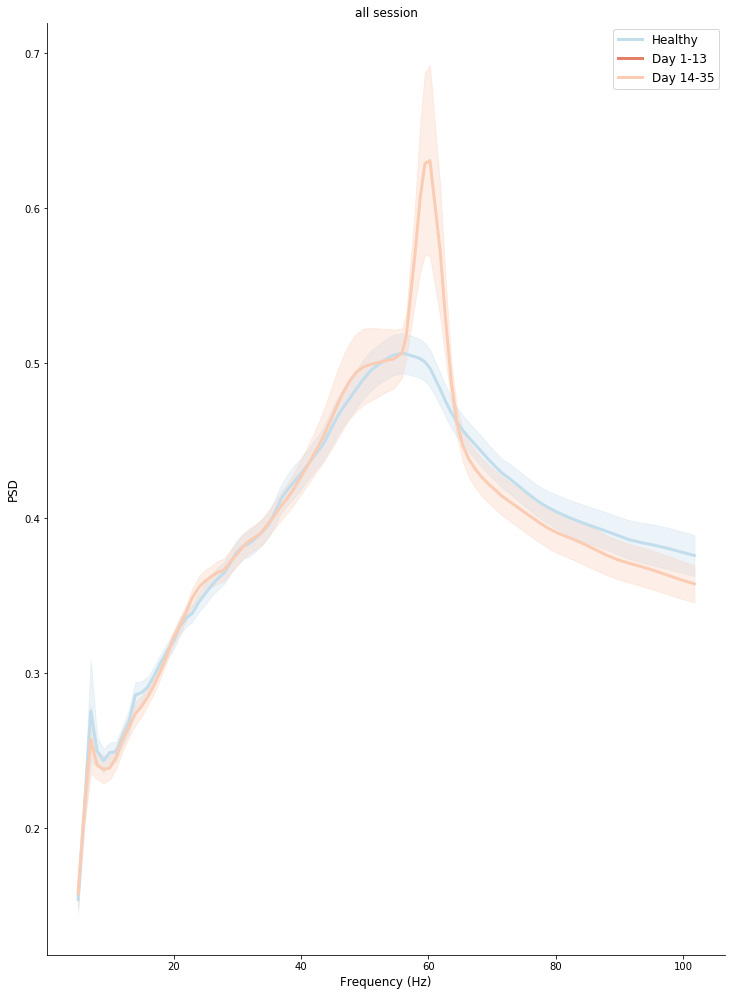

In [176]:
%matplotlib inline
colorsL = sns.cubehelix_palette(8)
colorsH = a3[[2,5,4]]#sns.cubehelix_palette(4, start=2, rot=5, dark=0, light=.65)
colorsH2 = sns.cubehelix_palette(8, start=3, rot=0, dark=0, light=.95)

fig, ax = plt.subplots(1,1,figsize=(12.15,17.15),sharey='row')
for ind, p in enumerate(periods.keys()):
    hC = np.nanmean(periods[p]['lowSpeed'],axis=1)*freq
    hS2 = np.nanstd(periods[p]['lowSpeed'],axis=1)*freq/np.sqrt(periods[p]['all'].shape[1])
       
    ax.plot(freq,hC,color = colorsH[ind], label=p,linewidth=3.0)
    ax.fill_between(freq, hC-hS2, hC+hS2,color=colorsH[ind],alpha=0.3)
#     ax.set_xlim(6,100)
    ax.set_title('all session')
#     ax.set_xlim(60,100)
#    ax[0,ind].set_ylim(0.015,0.03)
    ax.set_ylabel('PSD',fontsize=12)
    #ax[0,ind].axes.get_yaxis().set_ticks([])
    ax.set_xlabel('Frequency (Hz)',fontsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(fontsize=12)
fig.savefig(figFolder+'lfpSpectromPost_LDOPA_lowSpeed_freq.png',transparent=True,format='png')
# ax.set_xlim(10,30)
# fig.savefig(figFolder+'lfpSpectromPeriodAllSess_zoomBeta.svg',transparent=True,format='svg')



In [112]:
df

index mouse day     period  \
0   0761_BaselineL  0761   0    Healthy   
1      0761_day19L  0761  19  Day 14-35   
2      0761_day35L  0761  35  Day 14-35   
3   1208_BaselineL  1208   0    Healthy   
4      1208_day19L  1208  19  Day 14-35   
5      1208_day34L  1208  34  Day 14-35   
6   1222_BaselineL  1222   0    Healthy   
7      1222_day20L  1222  20  Day 14-35   
8      1222_day36L  1222  36  Day 14-35   
9   1231_BaselineL  1231   0    Healthy   
10  1236_BaselineL  1236   0    Healthy   
11     1236_day19L  1236  19  Day 14-35   
12     1236_day35L  1236  35  Day 14-35   
13  1253_BaselineL  1253   0    Healthy   
14  1793_BaselineL  1793   0    Healthy   
15     1793_day19L  1793  19  Day 14-35   
16     1793_day34L  1793  34  Day 14-35   
17  2976_BaselineL  2976   0    Healthy   
18     2976_day19L  2976  19  Day 14-35   
19     2976_day35L  2976  35  Day 14-35   
20  2980_BaselineL  2980   0    Healthy   
21     2980_day19L  2980  19  Day 14-35   
22     2980_day35L  2980  35  Day 14-35   
23  2981_BaselineL  2981   0    Healthy   
24     2981_day19L  2981  19  Day 14-35   
25     2981_day35L  2981  35  Day 14-35   
26  8430_BaselineL  8430   0    Healthy   
27     8430_day19L  8430  19  Day 14-35   
28     8430_day35L  8430  35  Day 14-35   
29  8803_BaselineL  8803   0    Healthy   
30     8803_day19L  8803  19  Day 14-35   
31     8803_day34L  8803  34  Day 14-35   
32  8815_BaselineL  8815   0    Healthy   
33     8815_day19L  8815  19  Day 14-35   
34     8815_day34L  8815  34  Day 14-35   

                                                  all  \
0   [[0.029895043549235237, 0.04380962397832809, 0...   
1   [[0.029731099730866507, 0.04419501652700044, 0...   
2   [[0.02646740678833966, 0.04029770115475512, 0....   
3   [[0.028057806140800372, 0.03081920632653361, 0...   
4   [[0.029528442458084666, 0.030302475275540704, ...   
5   [[0.02509296091847466, 0.02845903158006613, 0....   
6   [[0.03384615455738076, 0.0407946444719836, 0.0...   
7   [[0.023396546356860597, 0.04002836501365547, 0...   
8   [[0.027354810754451692, 0.04061777519899916, 0...   
9   [[0.028375758967224468, 0.049201729978986176, ...   
10  [[0.03908251337219499, 0.039441333048555356, 0...   
11  [[0.039267428475677144, 0.04234191619211763, 0...   
12  [[0.04211831365716995, 0.04033590959378012, 0....   
13  [[0.019708190099456464, 0.026448208286140525, ...   
14  [[0.034700503450078544, 0.03762403617755288, 0...   
15  [[0.02585114501599384, 0.029349481820355527, 0...   
16  [[0.02890964000470946, 0.032216260193234585, 0...   
17  [[0.027626874190366635, 0.033691062569212456, ...   
18  [[0.027404048012713088, 0.03373338109680168, 0...   
19  [[0.028841778364244026, 0.0337608687147382, 0....   
20  [[0.024552414437522766, 0.026634781964355918, ...   
21  [[0.026929829787086624, 0.030289087924752264, ...   
22  [[0.027467519747042726, 0.02962718602544166, 0...   
23  [[0.02972566895491663, 0.033546193096050184, 0...   
24  [[0.02989818475630892, 0.03428696981275031, 0....   
25  [[0.026503782025669755, 0.030128518941045103, ...   
26  [[0.033240525297219034, 0.03453390102884226, 0...   
27  [[0.02543996313066157, 0.026296413793778253, 0...   
28  [[0.0285065181683009, 0.02758650329772567, 0.0...   
29  [[0.03876491645291586, 0.04323337787678693, 0....   
30  [[0.05060679560953696, 0.060832539287741454, 0...   
31  [[0.03865478081334064, 0.035005415006419786, 0...   
32  [[0.025658015553372545, 0.03318838940522962, 0...   
33  [[0.02863397201851895, 0.03093362828331827, 0....   
34  [[0.030851937578674285, 0.03374680624086332, 0...   

                                               highAC  \
0   [[0.013082514115555834, 0.026648016329413802, ...   
1   [[0.013946082068581476, 0.02166028056677778, 0...   
2   [[0.013075135992072039, 0.01656664623371631, 0...   
3   [[0.026018569216110732, 0.03093388437261442, 0...   
4   [[0.036353482345353565, 0.03661707230593379, 0...   
5   [[0.026690186875265337, 0.02657797562852938, 0...   
6   [[0.0200

In [177]:
colorsL = sns.cubehelix_palette(8)
colorsH = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95)
colorsH2 = sns.cubehelix_palette(8, start=3, rot=0, dark=0, light=.95)

beta = (freq>10)&(freq<16)
beta2 = (freq>15)&(freq<25)
gamma =(freq>40)&(freq<60)
highGamma = (freq>60)&(freq<100)
highGamma2 = (freq>80)&(freq<100)

# print(periods[p]['hiSpeed'].shape,np.nanmean(periods[p]['hiSpeed'][beta],axis=0).shape)
df2 = pd.DataFrame(columns = ['Period','Mouse','sess','mvmt','beta','gamma'])
# # fig, ax = plt.subplots(2,3,figsize=(12.15,17.15),sharey='row')
for row in range(len(df)):
    for mv in ['highAC', 'highC', 'lowRot', 'lowSpeed', 'hiSpeed','all']:
        try:
            te = np.array(df.iloc[row][mv])
            df3 = pd.DataFrame({'Period':df.iloc[row]['period'],'Mouse':df.iloc[row]['mouse'],'mvmt':mv,'sess':df.iloc[row]['Sess'],
                                'beta':np.nanmean(te[0,beta],axis=0),
                                'beta2':np.nanmean(te[0,beta2],axis=0),
                               'gamma':np.nanmean(te[0,gamma],axis=0),
                               'highGamma':np.nanmean(te[0,highGamma],axis=0),
                                'highGamma2':np.nanmean(te[0,highGamma2],axis=0),
                               'betaSum':np.nansum(te[0,beta],axis=0),
                                'betaSum2':np.nansum(te[0,beta2],axis=0),
                               'highGammaSum':np.nansum(te[0,highGamma],axis=0),
                                'highGammaSum2':np.nansum(te[0,highGamma2],axis=0),
                               'gammaSum':np.nansum(te[0,gamma],axis=0)},index=[0])
            df2 = pd.concat([df3,df2])
        except: 
            print(df.iloc[row]['Sess'],mv)

df2['ratio'] = df2.apply(lambda x: x.beta/x.gamma, axis = 1)
df2['ratio_High'] = df2.apply(lambda x: x.beta/x.highGamma, axis = 1)
# df['diff'] = 
df2.to_csv(figFolder+'lfpForR_Pre.csv')
df2.head()

0761_day35L highC
0761_day35L hiSpeed
1208_day34L highC
1236_day19L highAC
2980_day19L highC
8803_BaselineL highAC
8803_day34L highC


Period Mouse      mvmt         sess      beta     beta2     gamma  \
0  Day 14-35  8815       all  8815_day34L  0.021555  0.016234  0.008810   
0  Day 14-35  8815   hiSpeed  8815_day34L  0.021065  0.015892  0.008606   
0  Day 14-35  8815  lowSpeed  8815_day34L  0.022163  0.016635  0.009000   
0  Day 14-35  8815    lowRot  8815_day34L  0.021733  0.016511  0.008919   
0  Day 14-35  8815     highC  8815_day34L  0.020750  0.015842  0.008984   

   highGamma  highGamma2   betaSum  betaSum2  highGammaSum  highGammaSum2  \
0   0.005359    0.004222  0.129329  0.162341      0.160766       0.050668   
0   0.005353    0.004219  0.126388  0.158925      0.160579       0.050629   
0   0.005358    0.004217  0.132975  0.166355      0.160737       0.050606   
0   0.005381    0.004220  0.130396  0.165112      0.161439       0.050642   
0   0.005323    0.004234  0.124498  0.158425      0.159682       0.050810   

   gammaSum     ratio  ratio_High  
0  0.176209  2.446501    4.022259  
0  0.172126  2.447597    3.935401  
0  0.180001  2.462494    4.136412  
0  0.178371  2.436793    4.038572  
0  0.179690  2.309498    3.898314

In [210]:
# df =pd.read_csv(figFolder+'lfpForR_Post.csv')
# df3 = df2.merge(df,on=['sess','mvmt','Period'])
# df3.to_csv(figFolder+'lfpForR_Ldopa.csv')
df4 = df3[['Period','Mouse_x','mvmt','sess','betaSum2_x','betaSum2_y']]
df4 = df4[df4.mvmt.isin(['hiSpeed','lowSpeed'])]

def difAplly(row,fr):
    try: 
        if row.mvmt in ['hiSpeed','lowSpeed']:
            low = float(df4[(df4.sess == row.sess)&(df4.Period == row.Period)&(df4.mvmt == 'hiSpeed')][fr].item())
        val = float(row[fr])
    except:
        return None
    if low==0:
        return None
    else: #base <0 and val >0:
        return (val-low)

df4['diff_pre'] = df4.apply(lambda row: difAplly(row,'betaSum2_x'),axis=1)    
df4['diff_post'] = df4.apply(lambda row: difAplly(row,'betaSum2_y'),axis=1)    
df4

Period Mouse_x      mvmt            sess  betaSum2_x  betaSum2_y  \
1    Day 14-35    8815   hiSpeed     8815_day34L    0.158925    0.157568   
2    Day 14-35    8815  lowSpeed     8815_day34L    0.166355    0.176031   
7    Day 14-35    8815   hiSpeed     8815_day19L    0.161264    0.156883   
8    Day 14-35    8815  lowSpeed     8815_day19L    0.178112    0.179431   
13     Healthy    8815   hiSpeed  8815_BaselineL    0.174386    0.163607   
..         ...     ...       ...             ...         ...         ...   
179  Day 14-35    0761  lowSpeed     0761_day35L    0.146508    0.152941   
183  Day 14-35    0761   hiSpeed     0761_day19L    0.170933    0.164399   
184  Day 14-35    0761  lowSpeed     0761_day19L    0.161947    0.164075   
189    Healthy    0761   hiSpeed  0761_BaselineL    0.149140    0.150908   
190    Healthy    0761  lowSpeed  0761_BaselineL    0.160145    0.168885   

     diff_pre  diff_post  
1    0.000000   0.000000  
2    0.007430   0.018463  
7    0.000000   0.000000  
8    0.016848   0.022548  
13   0.000000   0.000000  
..        ...        ...  
179       NaN        NaN  
183  0.000000   0.000000  
184 -0.008986  -0.000325  
189  0.000000   0.000000  
190  0.011005   0.017977  

[67 rows x 8 columns]

In [211]:
df4.to_csv(figFolder+'lfpForR_Ldopa2.csv')

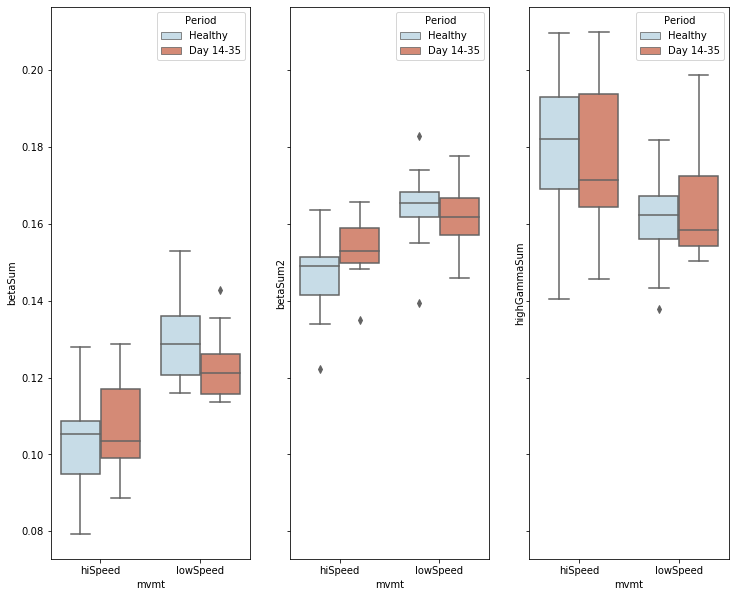

In [136]:
df = pd.read_csv(figFolder+'lfpForR_Post.csv')
df2 = df.groupby(['Period','Mouse','mvmt']).mean()
df2 = df2.reset_index()
# print(df2)
# def difAplly(row,fr):
#     if row.mvmt in ['hiSpeed','lowSpeed']:
#         low = float(df2[(df2.Mouse == row.Mouse)&(df2.Period == row.Period)&(df2.mvmt == 'lowSpeed')][fr].item())
#     else:
#         low = float(df2[(df2.Mouse == row.Mouse)&(df2.Period == row.Period)&(df2.mvmt == 'lowRot')][fr].item())
        
#     val = float(row[fr])
#     if low==0:
#         return None
#     else: #base <0 and val >0:
#         return (val-low)

# df2['diff_beta'] = df2.apply(lambda row: difAplly(row,'betaSum'),axis=1) 
# df2['diff_gamma'] = df2.apply(lambda row: difAplly(row,'gammaSum'),axis=1)    
# fig, ax = fig, ax = plt.subplots(1,2,figsize=(12.15,10.15),sharey='row')
# with sns.color_palette(colorPallet3):
#     sns.boxplot(x='Period',y='betaSum',ax = ax[0],data=df2[df2.mvmt=='all'],order = ['Healthy','Day 14-35'])
#     sns.boxplot(x='Period',y='gammaSum',ax = ax[1],data=df2[df2.mvmt=='all'],order = ['Healthy','Day 14-35'])
# fig.savefig(figFolder+'figure5_lfpfullSess_bar_Post.svg',transparent=True,format='svg')

fig, ax = fig, ax = plt.subplots(1,3,figsize=(12.15,10.15),sharey='row')
with sns.color_palette(colorPallet3):
    sns.boxplot(x='mvmt',hue = 'Period',y='betaSum',ax = ax[0],data=df2[df2.mvmt.isin(['hiSpeed','lowSpeed'])],hue_order = ['Healthy','Day 14-35'])
    sns.boxplot(x='mvmt',hue = 'Period',y='highGammaSum',ax = ax[2],data=df2[df2.mvmt.isin(['hiSpeed','lowSpeed'])],hue_order = ['Healthy','Day 14-35'])
    sns.boxplot(x='mvmt',hue = 'Period',y='betaSum2',ax = ax[1],data=df2[df2.mvmt.isin(['hiSpeed','lowSpeed'])],hue_order = ['Healthy','Day 14-35'])

fig.savefig(figFolder+'figure5_speed_bar_post.png',transparent=True,format='png')

# fig, ax = fig, ax = plt.subplots(1,2,figsize=(12.15,10.15),sharey='row')
# with sns.color_palette(colorPallet3):
#     sns.boxplot(x='mvmt',hue = 'Period',y='diff_beta',ax = ax[0],data=df2[df2.mvmt.isin(['hiSpeed','lowSpeed'])],hue_order = ['Healthy','Day 1-13','Day 14-35'])
#     sns.boxplot(x='mvmt',hue = 'Period',y='diff_gamma',ax = ax[1],data=df2[df2.mvmt.isin(['hiSpeed','lowSpeed'])],hue_order = ['Healthy','Day 1-13','Day 14-35'])
# fig.savefig(figFolder+'figure5_speed_bar_diff.svg',transparent=True,format='svg')


# fig, ax = fig, ax = plt.subplots(1,2,figsize=(12.15,10.15),sharey='row')
# with sns.color_palette(colorPallet3):
#     sns.boxplot(x='mvmt',hue = 'Period',y='betaSum',ax = ax[0],data=df2[df2.mvmt.isin(['lowRot','highAC','highC'])],hue_order = ['Healthy','Day 1-13','Day 14-35'])
#     sns.boxplot(x='mvmt',hue = 'Period',y='gammaSum',ax = ax[1],data=df2[df2.mvmt.isin(['lowRot','highAC','highC'])],hue_order = ['Healthy','Day 1-13','Day 14-35'])
# fig.savefig(figFolder+'figure5_rot_bar.svg',transparent=True,format='svg')

# fig, ax = fig, ax = plt.subplots(1,2,figsize=(12.15,10.15),sharey='row')
# with sns.color_palette(colorPallet3):
#     sns.boxplot(x='mvmt',hue = 'Period',y='diff_beta',ax = ax[0],data=df2[df2.mvmt.isin(['lowRot','highAC','highC'])],hue_order = ['Healthy','Day 1-13','Day 14-35'])
#     sns.boxplot(x='mvmt',hue = 'Period',y='diff_gamma',ax = ax[1],data=df2[df2.mvmt.isin(['lowRot','highAC','highC'])],hue_order = ['Healthy','Day 1-13','Day 14-35'])
# fig.savefig(figFolder+'figure5_rot_bar_diff.svg',transparent=True,format='svg')


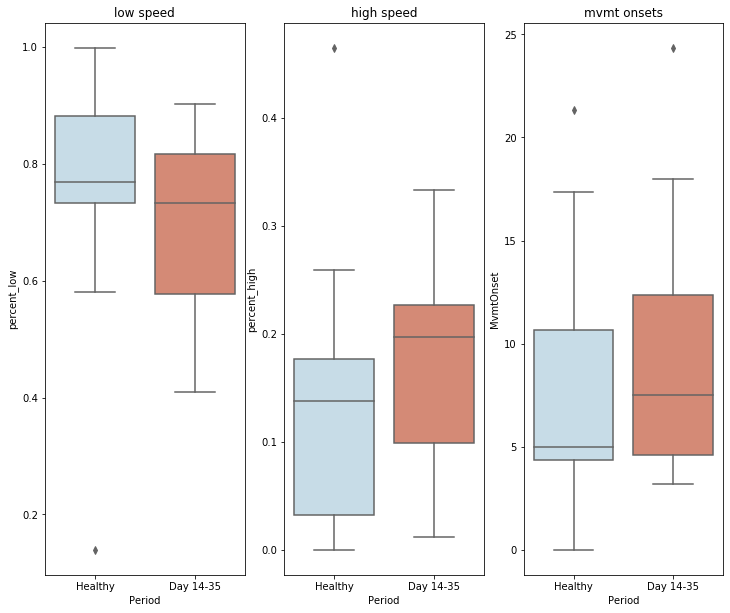

In [172]:
df = pd.read_csv('lineraVelocity_post.csv')
df = df[df.Drug == 'L-Dopa']
df = df[df.timeRange == 'full']
df['Period'] = df.Day.apply(lambda x: periodCalc(x))
df.to_csv(figFolder+'lineraVelocity_post2.csv')
df2 = df.groupby(['Period','Mouse']).mean()
df2 = df2.reset_index()

fig, ax = fig, ax = plt.subplots(1,3,figsize=(12.15,10.15))#,sharey='row')
with sns.color_palette(colorPallet3):
    sns.boxplot(x='Period',y='percent_low',ax = ax[0],data=df2,order = ['Healthy','Day 14-35'])
    sns.boxplot(x='Period',y='percent_high',ax = ax[1],data=df2,order = ['Healthy','Day 14-35'])
    sns.boxplot(x='Period',y='MvmtOnset',ax = ax[2],data=df2,order = ['Healthy','Day 14-35'])
    ax[0].set_title('low speed')
    ax[1].set_title('high speed')
    ax[2].set_title('mvmt onsets')
fig.savefig(figFolder+'speed_post_LDopa.png',transparent=True,format='png')


In [187]:
# df = df_normlizeByCol_meanPost
df = df_normlizeByCol_meanPre
# df.groupby(['mouse','period'])
periodsPre = {'Healthy':{'axis':0},'Day 14-35':{'axis':1}}
conds = ['highAC','highC','lowRot','lowSpeed','hiSpeed','all']

for p in periodsPre.keys():
    for c in conds:
        periodsPre[p][c] = np.zeros((87,1))
    for m in df[df.period == p].mouse.unique():
        for c in conds:
            try:
                te = np.array(df[(df.period == p)&(df.mouse == m)][c].tolist())
#                 print(te.shape)
                periodsPre[p][c] = np.concatenate((periodsPre[p][c],np.nanmean(te,axis=0).T),axis=1)                         
            except:
                print(m,c,p,te.shape)
                continue
for p in periodsPre.keys():
    for c in conds:
        periodsPre[p][c] = periodsPre[p][c][:,1:]



8803 highAC Healthy (1,)
0761 highC Day 14-35 (2,)
0761 hiSpeed Day 14-35 (2,)
1208 highC Day 14-35 (2,)
1236 highAC Day 14-35 (2,)
2980 highC Day 14-35 (2,)
8803 highC Day 14-35 (2,)


/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


In [188]:
df = df_normlizeByCol_meanPost
# df = df_normlizeByCol_meanPre
# df.groupby(['mouse','period'])
periodsPost = {'Healthy':{'axis':0},'Day 14-35':{'axis':1}}
conds = ['highAC','highC','lowRot','lowSpeed','hiSpeed','all']

for p in periodsPost.keys():
    for c in conds:
        periodsPost[p][c] = np.zeros((87,1))
    for m in df[df.period == p].mouse.unique():
        for c in conds:
            try:
                te = np.array(df[(df.period == p)&(df.mouse == m)][c].tolist())
#                 print(te.shape)
                periodsPost[p][c] = np.concatenate((periodsPost[p][c],np.nanmean(te,axis=0).T),axis=1)                         
            except:
                print(m,c,p,te.shape)
                continue
for p in periodsPost.keys():
    for c in conds:
        periodsPost[p][c] = periodsPost[p][c][:,1:]



1793 highAC Healthy (1,)
1793 highC Healthy (1,)
1793 hiSpeed Healthy (1,)
8430 highAC Healthy (1,)
1236 highAC Day 14-35 (2,)
1793 highAC Day 14-35 (2,)
1793 highC Day 14-35 (2,)
1793 hiSpeed Day 14-35 (2,)
8803 highAC Day 14-35 (2,)


/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


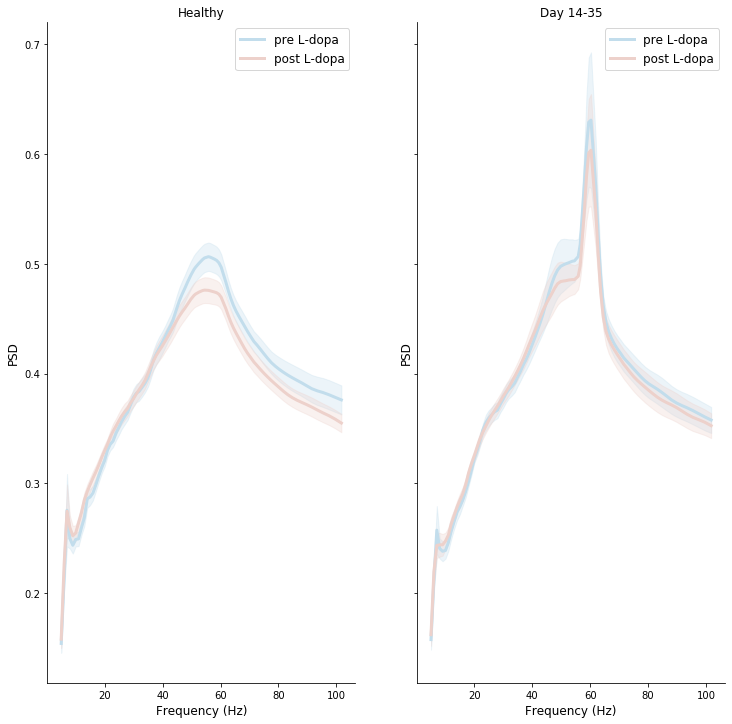

In [200]:
%matplotlib inline
colorsL = sns.cubehelix_palette(8)
colorsH = a3[[2,5,4]]#sns.cubehelix_palette(4, start=2, rot=5, dark=0, light=.65)
colorsH2 = sns.cubehelix_palette(8, start=3, rot=0, dark=0, light=.95)

fig, ax = plt.subplots(1,2,figsize=(12.15,12.15),sharey='row')
for ind, p in enumerate(periodsPre.keys()):
    hC = np.nanmean(periodsPre[p]['lowSpeed'],axis=1)*freq
    hS2 = np.nanstd(periodsPre[p]['lowSpeed'],axis=1)*freq/np.sqrt(periodsPre[p]['all'].shape[1])
       
    ax[ind].plot(freq,hC,color = colorsH[0], label='pre L-dopa',linewidth=3.0)
    ax[ind].fill_between(freq, hC-hS2, hC+hS2,color=colorsH[0],alpha=0.3)
    
    hC = np.nanmean(periodsPost[p]['lowSpeed'],axis=1)*freq
    hS2 = np.nanstd(periodsPost[p]['lowSpeed'],axis=1)*freq/np.sqrt(periodsPost[p]['all'].shape[1])
       
    ax[ind].plot(freq,hC,color = colorsL[0], label='post L-dopa',linewidth=3.0)
    ax[ind].fill_between(freq, hC-hS2, hC+hS2,color=colorsL[0],alpha=0.3)
#     ax.set_xlim(6,100)
    ax[ind].set_title(p)
#     ax.set_xlim(60,100)
#    ax[0,ind].set_ylim(0.015,0.03)
    ax[ind].set_ylabel('PSD',fontsize=12)
    #ax[0,ind].axes.get_yaxis().set_ticks([])
    ax[ind].set_xlabel('Frequency (Hz)',fontsize=12)
    ax[ind].spines['right'].set_visible(False)
    ax[ind].spines['top'].set_visible(False)
    ax[ind].legend(fontsize=12)
# fig.savefig(figFolder+'lfpSpectromPost_LDOPA_lowSpeed_freq.png',transparent=True,format='png')
# ax.set_xlim(10,30)
# fig.savefig(figFolder+'lfpSpectromPeriodAllSess_zoomBeta.svg',transparent=True,format='svg')



In [186]:
periodsPre.keys()

dict_keys(['Healthy', 'Day 1-13', 'Day 14-35'])

In [271]:
# spectrom in high/low mvmt
f = h5py.File('Spectograms.hdf5','r')

miceList = getMiceList(Files[0])
specs = {}
for m in tqdm(miceList):  
    data =  getData(Files[0],['lfp','speed'],period ='Post', mice=m, drug = b'Amphetamin')
    
    for sess in data:
        try:
            if sess[5] == 'B':
                day = 0
            else:
                day = int(re.findall(r'\d+',sess[5:])[0])

            # get data
            dtS = 1/data[sess]['speed']['Fs']
            dtL = 1/data[sess]['lfp']['FS']
            ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
            tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL


            highAC = getOnsetOrPeriod(m,sess,'Post','hiACRotPeriods_vector')
            highC = getOnsetOrPeriod(m,sess,'Post','hiCRotPeriods_vector')
            lowRot = getOnsetOrPeriod(m,sess,'Post','loRotPeriods_vector')
            lowSpeed = getOnsetOrPeriod(m,sess,'Post','LowMvmtPeriods_vector')
            hiSpeed = getOnsetOrPeriod(m,sess,'Post','HighMvmtPeriods_vector')
            tempDict = {'mouse':m,'day':day,'period':periodCalc(day)}

            freq = f[m]['freq'].value
            coeff = np.abs(f[m][sess]['Post']['coeff'].value)
            lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
            coeff[:,(lfpOutliers[:,0]==1)] = np.nan
            coeff = coeff.T
            
            Hs = np.nansum(coeff, axis=1)
            Hs2 = coeff.T/Hs.T
            Hs2 = Hs2.T
            tempDict['all'] = np.nanmean(Hs2,axis=0, keepdims=True)


            for mv in ['highAC','highC','lowRot','lowSpeed','hiSpeed']:
                Himvmt = np.full_like(tl,False)
                mVector = eval(mv)
                if np.sum(mVector) == 0:
                    continue
                V = np.append(mVector[1:]*1-mVector[:-1]*1,0)
                HpStart = ts[V==1]
                HpEnd = ts[V==-1]
                if mVector[0] == 1:
                    HpStart = np.insert(HpStart,0,0)
                for segI, seg in enumerate(HpStart):
                    si = np.argmin(np.abs(tl-seg))
                    se = np.argmin(np.abs(tl-HpEnd[segI])
                                  )
                    Himvmt[si:se] = True

                #coeff = np.delete(coeff,(56), axis=1)
                sessH = (Hs2[(Himvmt ==1),:])
#                 Hs = np.nansum(sessH, axis=0)
#                 Hs2 = sessH/Hs
                tempDict[mv] = np.nanmean(sessH,axis=0, keepdims=True)
            specs[sess] = tempDict
        except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess,exc_tb.tb_lineno)

df_normlizeByCol_meanPost_Amph = pd.DataFrame(specs)
df_normlizeByCol_meanPost_Amph = df_normlizeByCol_meanPost_Amph.T
# df.to_csv('specs_normlizeByRow_sum.csv')

  0%|          | 0/16 [00:00<?, ?it/s]/home/dana_z/ssd_2TB/6OHDA/IO.py:152: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  speed = hf[m][s]['mvmt']['speed'].value
/home/dana_z/ssd_2TB/6OHDA/IO.py:48: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  lfp = hf[m][s]['ePhys']['lfp'].value


cleaning up lfp data
cleaning up speed data


/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  6%|▋         | 1/16 [02:31<37:56, 151.74s/it]

cleaning up lfp data
cleaning up speed data


 12%|█▎        | 2/16 [05:33<37:30, 160.76s/it]

cleaning up lfp data
cleaning up speed data


 19%|█▉        | 3/16 [07:52<33:25, 154.29s/it]

cleaning up lfp data
cleaning up speed data


 25%|██▌       | 4/16 [08:48<24:57, 124.82s/it]

cleaning up lfp data
cleaning up speed data
found  34.0  outlier points
found  927582.0  outlier points


 31%|███▏      | 5/16 [11:39<25:24, 138.60s/it]

cleaning up lfp data
cleaning up speed data


 38%|███▊      | 6/16 [12:20<18:14, 109.40s/it]

cleaning up lfp data
cleaning up speed data


 44%|████▍     | 7/16 [15:21<19:36, 130.70s/it]

cleaning up lfp data
cleaning up speed data


 50%|█████     | 8/16 [17:59<18:31, 138.99s/it]

cleaning up lfp data
cleaning up speed data
found  144.0  outlier points


 56%|█████▋    | 9/16 [21:09<18:00, 154.42s/it]

cleaning up lfp data
cleaning up speed data
found  105.0  outlier points


 62%|██████▎   | 10/16 [23:50<15:37, 156.31s/it]

cleaning up lfp data
cleaning up speed data
found  17.0  outlier points


 69%|██████▉   | 11/16 [26:21<12:53, 154.71s/it]

cleaning up lfp data
cleaning up speed data


 75%|███████▌  | 12/16 [27:26<08:30, 127.71s/it]

cleaning up lfp data
cleaning up speed data
found  10.0  outlier points


 81%|████████▏ | 13/16 [30:41<07:24, 148.03s/it]

cleaning up lfp data
cleaning up speed data


 88%|████████▊ | 14/16 [33:02<04:51, 145.93s/it]

cleaning up lfp data
cleaning up speed data


 94%|█████████▍| 15/16 [35:07<02:19, 139.44s/it]

cleaning up lfp data
cleaning up speed data


100%|██████████| 16/16 [37:31<00:00, 140.74s/it]


In [272]:
# spectrom in high/low mvmt
f = h5py.File('Spectograms.hdf5','r')

miceList = getMiceList(Files[0])
specs = {}
for m in tqdm(miceList):  
    data =  getData(Files[0],['lfp','speed'],period ='Pre', mice=m, drug = b'Amphetamin')
    
    for sess in data:
        try:
            if sess[5] == 'B':
                day = 0
            else:
                day = int(re.findall(r'\d+',sess[5:])[0])

            # get data
            dtS = 1/data[sess]['speed']['Fs']
            dtL = 1/data[sess]['lfp']['FS']
            ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
            tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL


            highAC = getOnsetOrPeriod(m,sess,'Pre','hiACRotPeriods_vector')
            highC = getOnsetOrPeriod(m,sess,'Pre','hiCRotPeriods_vector')
            lowRot = getOnsetOrPeriod(m,sess,'Pre','loRotPeriods_vector')
            lowSpeed = getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_vector')
            hiSpeed = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_vector')
            tempDict = {'mouse':m,'day':day,'period':periodCalc(day)}

            freq = f[m]['freq'].value
            coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
            lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
            coeff[:,(lfpOutliers[:,0]==1)] = np.nan
            coeff = coeff.T
            
            Hs = np.nansum(coeff, axis=1)
            Hs2 = coeff.T/Hs.T
            Hs2 = Hs2.T
            tempDict['all'] = np.nanmean(Hs2,axis=0, keepdims=True)


            for mv in ['highAC','highC','lowRot','lowSpeed','hiSpeed']:
                Himvmt = np.full_like(tl,False)
                mVector = eval(mv)
                if np.sum(mVector) == 0:
                    continue
                V = np.append(mVector[1:]*1-mVector[:-1]*1,0)
                HpStart = ts[V==1]
                HpEnd = ts[V==-1]
                if mVector[0] == 1:
                    HpStart = np.insert(HpStart,0,0)
                for segI, seg in enumerate(HpStart):
                    si = np.argmin(np.abs(tl-seg))
                    se = np.argmin(np.abs(tl-HpEnd[segI])
                                  )
                    Himvmt[si:se] = True

                #coeff = np.delete(coeff,(56), axis=1)
                sessH = (Hs2[(Himvmt ==1),:])
#                 Hs = np.nansum(sessH, axis=0)
#                 Hs2 = sessH/Hs
                tempDict[mv] = np.nanmean(sessH,axis=0, keepdims=True)
            specs[sess] = tempDict
        except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess,exc_tb.tb_lineno)

df_normlizeByCol_meanPre_Amph = pd.DataFrame(specs)
df_normlizeByCol_meanPre_Amph = df_normlizeByCol_meanPre_Amph.T
# df.to_csv('specs_normlizeByRow_sum.csv')

  0%|          | 0/16 [00:00<?, ?it/s]/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


cleaning up lfp data
cleaning up speed data


  6%|▋         | 1/16 [00:30<07:32, 30.16s/it]

cleaning up lfp data
cleaning up speed data


 12%|█▎        | 2/16 [01:01<07:07, 30.56s/it]

cleaning up lfp data
cleaning up speed data


 19%|█▉        | 3/16 [01:38<07:01, 32.42s/it]

cleaning up lfp data
cleaning up speed data


 25%|██▌       | 4/16 [01:50<05:17, 26.44s/it]

cleaning up lfp data
cleaning up speed data
found  1.0  outlier points
found  888231.0  outlier points


 31%|███▏      | 5/16 [02:26<05:21, 29.27s/it]

cleaning up lfp data
cleaning up speed data


 38%|███▊      | 6/16 [02:38<04:01, 24.15s/it]

cleaning up lfp data
cleaning up speed data


 44%|████▍     | 7/16 [03:15<04:09, 27.75s/it]

cleaning up lfp data
cleaning up speed data
found  1.0  outlier points


 50%|█████     | 8/16 [03:51<04:03, 30.45s/it]

cleaning up lfp data
cleaning up speed data


 56%|█████▋    | 9/16 [04:26<03:42, 31.74s/it]

cleaning up lfp data
cleaning up speed data
found  50.0  outlier points


 62%|██████▎   | 10/16 [05:03<03:19, 33.31s/it]

cleaning up lfp data
cleaning up speed data


 69%|██████▉   | 11/16 [05:49<03:05, 37.04s/it]

cleaning up lfp data
cleaning up speed data


 75%|███████▌  | 12/16 [06:11<02:09, 32.47s/it]

cleaning up lfp data
cleaning up speed data


 81%|████████▏ | 13/16 [06:59<01:52, 37.34s/it]

cleaning up lfp data
cleaning up speed data


 88%|████████▊ | 14/16 [07:34<01:12, 36.46s/it]

cleaning up lfp data
cleaning up speed data


 94%|█████████▍| 15/16 [07:56<00:32, 32.23s/it]

cleaning up lfp data
cleaning up speed data


100%|██████████| 16/16 [08:29<00:00, 31.82s/it]


In [277]:
df = df_normlizeByCol_meanPost_Amph
# df = df_normlizeByCol_meanPre_Amph
# df.groupby(['mouse','period'])
periods = {'Healthy':{'axis':0},'Day 1-13':{'axis':1},'Day 14-35':{'axis':2}}
conds = ['highAC','highC','lowRot','lowSpeed','hiSpeed','all']

for p in periods.keys():
    for c in conds:
        periods[p][c] = np.zeros((87,1))
    for m in df[df.period == p].mouse.unique():
        for c in conds:
            try:
                te = np.array(df[(df.period == p)&(df.mouse == m)][c].tolist())
#                 print(te.shape)
                periods[p][c] = np.concatenate((periods[p][c],np.nanmean(te,axis=0).T),axis=1)                         
            except:
                print(m,c,p,te.shape)
                continue
for p in periods.keys():
    for c in conds:
        periods[p][c] = periods[p][c][:,1:]



1253 highAC Healthy (1,)
4539 lowSpeed Healthy (2,)
1222 highC Day 14-35 (2,)
1793 highC Day 14-35 (2,)
8430 highC Day 14-35 (2,)
8815 highC Day 14-35 (2,)


/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


In [281]:
df.reset_index(inplace=True)
df = df.rename(columns = {'index':'Sess'})
df

Sess mouse day     period  \
0    0761_BaselineA  0761   0    Healthy   
1       0761_day14A  0761  14  Day 14-35   
2       0761_day31A  0761  31  Day 14-35   
3    1208_BaselineA  1208   0    Healthy   
4       1208_day15A  1208  15  Day 14-35   
5       1208_day30A  1208  30  Day 14-35   
6    1222_BaselineA  1222   0    Healthy   
7       1222_day15A  1222  15  Day 14-35   
8       1222_day32A  1222  32  Day 14-35   
9    1231_BaselineA  1231   0    Healthy   
10   1236_BaselineA  1236   0    Healthy   
11      1236_day15A  1236  15  Day 14-35   
12      1236_day30A  1236  30  Day 14-35   
13   1253_BaselineA  1253   0    Healthy   
14   1793_BaselineA  1793   0    Healthy   
15      1793_day15A  1793  15  Day 14-35   
16      1793_day30A  1793  30  Day 14-35   
17   2976_BaselineA  2976   0    Healthy   
18      2976_day15A  2976  15  Day 14-35   
19      2976_day30A  2976  30  Day 14-35   
20   2980_BaselineA  2980   0    Healthy   
21      2980_day15A  2980  15  Day 14-35   
22      2980_day30A  2980  30  Day 14-35   
23   2981_BaselineA  2981   0    Healthy   
24      2981_day15A  2981  15  Day 14-35   
25      2981_day30A  2981  30  Day 14-35   
26  4539_Baseline2A  4539   0    Healthy   
27   4539_BaselineA  4539   0    Healthy   
28      4539_day15A  4539  15  Day 14-35   
29      4539_day30A  4539  30  Day 14-35   
30   7584_BaselineA  7584   0    Healthy   
31      7584_day30A  7584  30  Day 14-35   
32  7909_Baseline2A  7909   0    Healthy   
33   7909_BaselineA  7909   0    Healthy   
34      7909_day15A  7909  15  Day 14-35   
35      7909_day30A  7909  30  Day 14-35   
36   8430_BaselineA  8430   0    Healthy   
37      8430_day15A  8430  15  Day 14-35   
38      8430_day30A  8430  30  Day 14-35   
39   8803_BaselineA  8803   0    Healthy   
40      8803_day30A  8803  30  Day 14-35   
41   8815_BaselineA  8815   0    Healthy   
42      8815_day15A  8815  15  Day 14-35   
43      8815_day30A  8815  30  Day 14-35   

                                                  all  \
0   [[0.02876768465526848, 0.06463936762839047, 0....   
1   [[0.017636786404003547, 0.07119876102346331, 0...   
2   [[0.013457495647732354, 0.032516934385271964, ...   
3   [[0.02151405813410194, 0.027889262932355822, 0...   
4   [[0.02190567698078864, 0.025951991808510176, 0...   
5   [[0.022274765010398892, 0.024071326023251544, ...   
6   [[0.05195676641707478, 0.04705546357774312, 0....   
7   [[0.02102743964504221, 0.08952123296884675, 0....   
8   [[0.020605211915185002, 0.07292698875613411, 0...   
9   [[0.022729885870271627, 0.06185686331149055, 0...   
10  [[0.04195506607320533, 0.03788154833760315, 0....   
11  [[0.027036902295669917, 0.03095913241892255, 0...   
12  [[0.038296540022776784, 0.03838187834319319, 0...   
13  [[0.014665136369345664, 0.02397050276403033, 0...   
14  [[0.041792117995050095, 0.0396511678102965, 0....   
15  [[0.027456636554759377, 0.03547397773107833, 0...   
16  [[0.03260131131072412, 0.04203704347296042, 0....   
17  [[0.021215524077346733, 0.03206756102255772, 0...   
18  [[0.023721182607507777, 0.033911352134524085, ...   
19  [[0.0250418163148526, 0.03664950056438441, 0.0...   
20  [[0.021159880922434364, 0.03106977655197282, 0...   
21  [[0.059184897178450886, 0.05004534132673688, 0...   
22  [[0.0154506738405611, 0.021274368789990367, 0....   
23  [[0.026977799285513533, 0.046942021559125836, ...   
24  [[0.02878131818425415, 0.03640626756097827, 0....   
25  [[0.018699995799692146, 0.02436494623559822, 0...   
26  [[0.03232942425487782, 0.04377095599813238, 0....   
27  [[0.021379845011558953, 0.032871841693483735, ...   
28  [[0.03426362603843789, 0.039669473819400336, 0...   
29  [[0.03830028677195637, 0.04503430182276259, 0....   
30  [[0.03109777154131879, 0.03573889507765502, 0....   
31  [[0.03436848711098994, 0.04474113889108004, 0....   
32  [[0.04524726468283656, 0.05831003993978197, 0....   
33  [[0.03292318112386883, 0.03969800705800743, 0....   
34  [[0.036229587446397794, 0.039830816

/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/home/dana_z/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


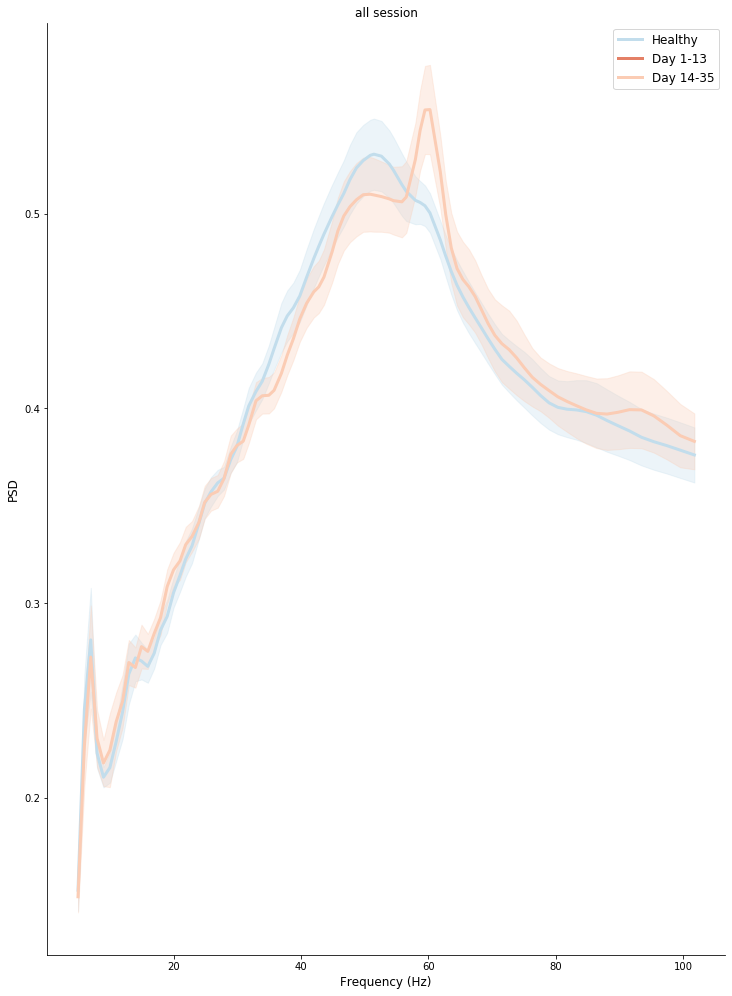

In [282]:
%matplotlib inline
colorsL = sns.cubehelix_palette(8)
colorsH = a3[[2,5,4]]#sns.cubehelix_palette(4, start=2, rot=5, dark=0, light=.65)
colorsH2 = sns.cubehelix_palette(8, start=3, rot=0, dark=0, light=.95)

fig, ax = plt.subplots(1,1,figsize=(12.15,17.15),sharey='row')
for ind, p in enumerate(periods.keys()):
    hC = np.nanmean(periods[p]['lowSpeed'],axis=1)*freq
    hS2 = np.nanstd(periods[p]['lowSpeed'],axis=1)*freq/np.sqrt(periods[p]['all'].shape[1])
       
    ax.plot(freq,hC,color = colorsH[ind], label=p,linewidth=3.0)
    ax.fill_between(freq, hC-hS2, hC+hS2,color=colorsH[ind],alpha=0.3)
#     ax.set_xlim(6,100)
    ax.set_title('all session')
#     ax.set_xlim(60,100)
#    ax[0,ind].set_ylim(0.015,0.03)
    ax.set_ylabel('PSD',fontsize=12)
    #ax[0,ind].axes.get_yaxis().set_ticks([])
    ax.set_xlabel('Frequency (Hz)',fontsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(fontsize=12)
fig.savefig(figFolder+'lfpSpectromPost_LDOPA_lowSpeed_freq.png',transparent=True,format='png')
# ax.set_xlim(10,30)
# fig.savefig(figFolder+'lfpSpectromPeriodAllSess_zoomBeta.svg',transparent=True,format='svg')



In [233]:
# df = df_normlizeByCol_meanPost_Saline
# df.reset_index(inplace=True)
# df = df.rename(columns = {'index':'Sess'})
# df


# te = np.array(df.iloc[0]['hiSpeed'])
# np.sum(te)
Hs.shape

(1815677,)

In [283]:
colorsL = sns.cubehelix_palette(8)
colorsH = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95)
colorsH2 = sns.cubehelix_palette(8, start=3, rot=0, dark=0, light=.95)

beta = (freq>10)&(freq<16)
beta2 = (freq>15)&(freq<25)
gamma =(freq>40)&(freq<60)
highGamma = (freq>60)&(freq<100)
highGamma2 = (freq>80)&(freq<100)

# print(periods[p]['hiSpeed'].shape,np.nanmean(periods[p]['hiSpeed'][beta],axis=0).shape)
df2 = pd.DataFrame(columns = ['Period','Mouse','sess','mvmt','beta','gamma'])
# # fig, ax = plt.subplots(2,3,figsize=(12.15,17.15),sharey='row')
for row in range(len(df)):
    for mv in ['highAC', 'highC', 'lowRot', 'lowSpeed', 'hiSpeed','all']:
        try:
            te = np.array(df.iloc[row][mv])
            df3 = pd.DataFrame({'Period':df.iloc[row]['period'],'Mouse':df.iloc[row]['mouse'],'mvmt':mv,'sess':df.iloc[row]['Sess'],
                                'beta':np.nanmean(te[0,beta],axis=0),
                                'beta2':np.nanmean(te[0,beta2],axis=0),
                               'gamma':np.nanmean(te[0,gamma],axis=0),
                               'highGamma':np.nanmean(te[0,highGamma],axis=0),
                                'highGamma2':np.nanmean(te[0,highGamma2],axis=0),
                               'betaSum':np.nansum(te[0,beta],axis=0),
                                'betaSum2':np.nansum(te[0,beta2],axis=0),
                               'highGammaSum':np.nansum(te[0,highGamma],axis=0),
                                'highGammaSum2':np.nansum(te[0,highGamma2],axis=0),
                               'gammaSum':np.nansum(te[0,gamma],axis=0)},index=[0])
            df2 = pd.concat([df3,df2])
        except: 
            print(df.iloc[row]['Sess'],mv)

df2['ratio'] = df2.apply(lambda x: x.beta/x.gamma, axis = 1)
df2['ratio_High'] = df2.apply(lambda x: x.beta/x.highGamma, axis = 1)
# df['diff'] = 
df2.to_csv(figFolder+'lfpForR_Post_Amph.csv')
df2.head()

1222_day32A highC
1253_BaselineA highAC
1793_day30A highC
4539_BaselineA lowSpeed
8430_day30A highC
8815_day30A highC


Period Mouse      mvmt         sess      beta     beta2     gamma  \
0  Day 14-35  8815       all  8815_day30A  0.023439  0.016035  0.008135   
0  Day 14-35  8815   hiSpeed  8815_day30A  0.024817  0.016081  0.007693   
0  Day 14-35  8815  lowSpeed  8815_day30A  0.019328  0.016105  0.009379   
0  Day 14-35  8815    lowRot  8815_day30A  0.020865  0.015969  0.008966   
0  Day 14-35  8815    highAC  8815_day30A  0.025363  0.016322  0.007454   

   highGamma  highGamma2   betaSum  betaSum2  highGammaSum  highGammaSum2  \
0   0.005002    0.003896  0.140634  0.160350      0.150052       0.046747   
0   0.004789    0.003740  0.148899  0.160813      0.143678       0.044879   
0   0.005604    0.004341  0.115970  0.161047      0.168123       0.052095   
0   0.005431    0.004230  0.125189  0.159688      0.162932       0.050763   
0   0.004571    0.003601  0.152179  0.163215      0.137145       0.043218   

   gammaSum     ratio  ratio_High  
0  0.162707  2.881133    4.686179  
0  0.153861  3.225841    5.181707  
0  0.187584  2.060774    3.448974  
0  0.179317  2.327146    3.841739  
0  0.149087  3.402469    5.548114

In [284]:
df2 =pd.read_csv(figFolder+'lfpForR_Pre_Amph.csv')
df =pd.read_csv(figFolder+'lfpForR_Post_Amph.csv')
df3 = df2.merge(df,on=['sess','mvmt','Period'])
df3.to_csv(figFolder+'lfpForR_Amph.csv')
df4 = df3[['Period','Mouse_x','mvmt','sess','betaSum2_x','betaSum2_y']]
df4 = df4[df4.mvmt.isin(['hiSpeed','lowSpeed'])]

def difAplly(row,fr):
    try: 
        if row.mvmt in ['hiSpeed','lowSpeed']:
            low = float(df4[(df4.sess == row.sess)&(df4.Period == row.Period)&(df4.mvmt == 'hiSpeed')][fr].item())
        val = float(row[fr])
    except:
        return None
    if low==0:
        return None
    else: #base <0 and val >0:
        return (val-low)

df4['diff_pre'] = df4.apply(lambda row: difAplly(row,'betaSum2_x'),axis=1)    
df4['diff_post'] = df4.apply(lambda row: difAplly(row,'betaSum2_y'),axis=1)

df4

Period  Mouse_x      mvmt            sess  betaSum2_x  betaSum2_y  \
1    Day 14-35     8815   hiSpeed     8815_day30A    0.159633    0.160813   
2    Day 14-35     8815  lowSpeed     8815_day30A    0.171568    0.161047   
6    Day 14-35     8815   hiSpeed     8815_day15A    0.150665    0.162123   
7    Day 14-35     8815  lowSpeed     8815_day15A    0.164129    0.156113   
12     Healthy     8815   hiSpeed  8815_BaselineA    0.169029    0.172160   
..         ...      ...       ...             ...         ...         ...   
239  Day 14-35      761  lowSpeed     0761_day31A    0.162054    0.138108   
243  Day 14-35      761   hiSpeed     0761_day14A    0.176601    0.139192   
244  Day 14-35      761  lowSpeed     0761_day14A    0.166417    0.148513   
249    Healthy      761   hiSpeed  0761_BaselineA    0.153560    0.140693   
250    Healthy      761  lowSpeed  0761_BaselineA    0.159052    0.142954   

     diff_pre  diff_post  
1    0.000000   0.000000  
2    0.011936   0.000234  
6    0.000000   0.000000  
7    0.013464  -0.006010  
12   0.000000   0.000000  
..        ...        ...  
239 -0.005652   0.004739  
243  0.000000   0.000000  
244 -0.010183   0.009321  
249  0.000000   0.000000  
250  0.005492   0.002261  

[87 rows x 8 columns]

In [285]:
df4.to_csv(figFolder+'lfpForR_Amph2.csv')

In [8]:
# spectrom in high/low mvmt
f = h5py.File('Spectograms.hdf5','r')

miceList = getMiceList(Files[0])
specs = {}
for m in tqdm(miceList):  
    data =  getData(Files[0],['lfp','speed'],period ='Pre', mice=m)#, drug = b'Amphetamin')
    
    for sess in data:
        try:
            if sess[5] == 'B':
                day = 0
            else:
                day = int(re.findall(r'\d+',sess[5:])[0])

            # get data
            dtS = 1/data[sess]['speed']['Fs']
            dtL = 1/data[sess]['lfp']['FS']
            ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
            tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL


            highAC = getOnsetOrPeriod(m,sess,'Pre','hiACRotPeriods_vector')
            highC = getOnsetOrPeriod(m,sess,'Pre','hiCRotPeriods_vector')
            lowRot = getOnsetOrPeriod(m,sess,'Pre','loRotPeriods_vector')
            lowSpeed = getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_vector')
            hiSpeed = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_vector')
            rot = highAC+highC
            tempDict = {'mouse':m,'day':day,'period':periodCalc(day)}

            freq = f[m]['freq'].value
            coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
            lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
            coeff[:,(lfpOutliers[:,0]==1)] = np.nan
            coeff = coeff.T
            
            Hs = np.nansum(coeff, axis=1)
            Hs2 = coeff.T/Hs.T
            Hs2 = Hs2.T
            tempDict['all'] = np.nanmean(Hs2,axis=0, keepdims=True)


            for mv in ['highAC','highC','lowRot','lowSpeed','hiSpeed','rot']:
                Himvmt = np.full_like(tl,False)
                mVector = eval(mv)
                if np.sum(mVector) == 0:
                    continue
                V = np.append(mVector[1:]*1-mVector[:-1]*1,0)
                HpStart = ts[V==1]
                HpEnd = ts[V==-1]
                if mVector[0] == 1:
                    HpStart = np.insert(HpStart,0,0)
                for segI, seg in enumerate(HpStart):
                    si = np.argmin(np.abs(tl-seg))
                    se = np.argmin(np.abs(tl-HpEnd[segI])
                                  )
                    Himvmt[si:se] = True

                #coeff = np.delete(coeff,(56), axis=1)
                sessH = (Hs2[(Himvmt ==1),:])
#                 Hs = np.nansum(sessH, axis=0)
#                 Hs2 = sessH/Hs
                tempDict[mv] = np.nanmean(sessH,axis=0, keepdims=True)
            specs[sess] = tempDict
        except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess,exc_tb.tb_lineno)

df_normlizeByCol_mean = pd.DataFrame(specs)
df_normlizeByCol_mean = df_normlizeByCol_mean.T
# df.to_csv('specs_normlizeByRow_sum.csv')

  0%|          | 0/16 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  6%|▋         | 1/16 [02:14<33:35, 134.36s/it]

cleaning up lfp data
I deleted session: 1208_day12
cleaning up speed data
found  17.0  outlier points


 12%|█▎        | 2/16 [04:42<32:17, 138.43s/it]

cleaning up lfp data
cleaning up speed data


 19%|█▉        | 3/16 [07:41<32:38, 150.63s/it]

cleaning up lfp data
cleaning up speed data


 25%|██▌       | 4/16 [08:19<23:22, 116.89s/it]

cleaning up lfp data
cleaning up speed data
found  1.0  outlier points
found  888231.0  outlier points
found  481139.0  outlier points


 31%|███▏      | 5/16 [10:56<23:38, 128.99s/it]

cleaning up lfp data
cleaning up speed data


 38%|███▊      | 6/16 [11:35<17:00, 102.04s/it]

cleaning up lfp data
cleaning up speed data


 44%|████▍     | 7/16 [14:30<18:35, 123.91s/it]

cleaning up lfp data
I deleted session: 2976_day4
cleaning up speed data
found  1.0  outlier points
found  3.0  outlier points


 50%|█████     | 8/16 [17:11<18:00, 135.06s/it]

cleaning up lfp data
cleaning up speed data


 56%|█████▋    | 9/16 [19:49<16:33, 141.88s/it]

cleaning up lfp data
cleaning up speed data
found  50.0  outlier points


 62%|██████▎   | 10/16 [22:40<15:04, 150.70s/it]

cleaning up lfp data
cleaning up speed data
found  29.0  outlier points


 69%|██████▉   | 11/16 [25:59<13:44, 164.94s/it]

cleaning up lfp data
cleaning up speed data


 75%|███████▌  | 12/16 [28:58<11:16, 169.24s/it]

cleaning up lfp data
cleaning up speed data


 81%|████████▏ | 13/16 [32:18<08:55, 178.36s/it]

cleaning up lfp data
cleaning up speed data


 88%|████████▊ | 14/16 [34:49<05:40, 170.21s/it]

cleaning up lfp data
cleaning up speed data
8803_day6 34


 94%|█████████▍| 15/16 [37:09<02:41, 161.28s/it]

cleaning up lfp data
cleaning up speed data
8815_day6 34


100%|██████████| 16/16 [39:33<00:00, 148.36s/it]


In [31]:
df = df_normlizeByCol_mean
# df = df_normlizeByCol_meanPre_Amph
# df.groupby(['mouse','period'])
periods = {'Healthy':{'axis':0},'Day 1-13':{'axis':1},'Day 14-35':{'axis':2}}
conds = ['highAC','highC','lowRot','lowSpeed','hiSpeed','rot','all']

for p in periods.keys():
    for c in conds:
        periods[p][c] = np.zeros((87,1))
    for m in df[df.period == p].mouse.unique():
        for c in conds:
            try:
                te = np.array(df[(df.period == p)&(df.mouse == m)][c].tolist())
#                 print(te.shape)
                periods[p][c] = np.concatenate((periods[p][c],np.nanmean(te,axis=0).T),axis=1)                         
            except:
                print(m,c,p,te.shape)
                continue
for p in periods.keys():
    for c in conds:
        periods[p][c] = periods[p][c][:,1:]



8803 highAC Healthy (3,)
1208 highC Day 1-13 (5,)
2981 highAC Day 1-13 (6,)
4539 highAC Day 1-13 (12,)
4539 highC Day 1-13 (12,)
4539 rot Day 1-13 (12,)
7584 highAC Day 1-13 (12,)
7584 highC Day 1-13 (12,)
7584 rot Day 1-13 (12,)
7909 highAC Day 1-13 (12,)
7909 highC Day 1-13 (12,)
7909 hiSpeed Day 1-13 (12,)
7909 rot Day 1-13 (12,)
0761 highC Day 14-35 (4,)
0761 hiSpeed Day 14-35 (4,)
1208 highC Day 14-35 (5,)
1236 highAC Day 14-35 (5,)
2980 highC Day 14-35 (5,)
4539 highAC Day 14-35 (4,)
4539 highC Day 14-35 (4,)
4539 rot Day 14-35 (4,)
7584 highAC Day 14-35 (2,)
7584 highC Day 14-35 (2,)
7584 rot Day 14-35 (2,)
7909 highAC Day 14-35 (4,)
7909 highC Day 14-35 (4,)
7909 rot Day 14-35 (4,)
8803 highC Day 14-35 (4,)


/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


In [11]:
df.reset_index(inplace=True)
df = df.rename(columns = {'index':'Sess'})
df

Sess mouse day     period  \
0    0761_BaselineA  0761   0    Healthy   
1    0761_BaselineL  0761   0    Healthy   
2    0761_BaselineS  0761   0    Healthy   
3         0761_day1  0761   1   Day 1-13   
4        0761_day10  0761  10   Day 1-13   
..              ...   ...  ..        ...   
205       8815_day2  8815   2   Day 1-13   
206     8815_day30A  8815  30  Day 14-35   
207     8815_day34L  8815  34  Day 14-35   
208       8815_day4  8815   4   Day 1-13   
209       8815_day8  8815   8   Day 1-13   

                                                   all  \
0    [[0.026937597856671294, 0.039606724431787664, ...   
1    [[0.028317944575055945, 0.042404741343348366, ...   
2    [[0.025604036096745934, 0.040613298984899585, ...   
3    [[0.03029638015657264, 0.04370467652972099, 0....   
4    [[0.03232579724128348, 0.044394029432878665, 0...   
..                                                 ...   
205  [[0.030633934610500152, 0.03812544275709151, 0...   
206  [[0.029709471755341138, 0.03756162958831144, 0...   
207  [[0.031932283376201985, 0.03439057942215082, 0...   
208  [[0.03983152776919577, 0.04185539691257952, 0....   
209  [[0.028057127319230577, 0.03541598417341907, 0...   

                                                highAC  \
0    [[0.015334746927216668, 0.025047390304927433, ...   
1    [[0.017175769082858994, 0.03008794858631673, 0...   
2    [[0.018151913956442143, 0.032198904948375844, ...   
3    [[0.016654866847566202, 0.031516705070738255, ...   
4    [[0.018798173218869042, 0.027129806183325174, ...   
..                                                 ...   
205  [[0.033870030939494665, 0.033247935255767684, ...   
206  [[0.038618751735773844, 0.04787599804929012, 0...   
207  [[0.032199991716480525, 0.03489771579851191, 0...   
208  [[0.025462524716821082, 0.03404653370128897, 0...   
209  [[0.026175280517403362, 0.031021640593790468, ...   

                                                 highC  \
0    [[0.02152817333132848, 0.03140060220470342, 0....   
1    [[0.02024810813837574, 0.03613063664659965, 0....   
2    [[0.020641377127176973, 0.03583771182228051, 0...   
3    [[0.027168830998745976, 0.03868191071369943, 0...   
4    [[0.02922983661437048, 0.03417746875509607, 0....   
..                                                 ...   
205  [[0.018868834668442788, 0.0338308521285831, 0....   
206  [[0.01969704923241186, 0.04471202290593525, 0....   
207  [[0.028403964314384585, 0.030523573537765275, ...   
208  [[0.023449505458744097, 0.044301997233991725, ...   
209  [[0.02342224057216796, 0.03180761547819973, 0....   

                                                lowRot  \
0    [[0.030080730572367605, 0.04428542979826004, 0...   
1    [[0.03251517431718947, 0.04660735134274601, 0....   
2    [[0.0313811331062335, 0.04422470570178386, 0.0...   
3    [[0.03549183848397926, 0.04829577162249925, 0....   
4    [[0.03595818137495213, 0.047839785777122334, 0...   
..                                                 ...   
205  [[0.0318723597713264, 0.04039862305953711, 0.0...   
206  [[0.02761709832339242, 0.037121688925973395, 0...   
207  [[0.030245634234714717, 0.03417477644013087, 0...   
208  [[0.04326036695833673, 0.042629498345019466, 0...   
209  [[0.03046689554870836, 0.036266575588599456, 0...   

                                              lowSpeed  \
0    [[0.02941381885052106, 0.04352431763246545, 0....   
1    [[0.032633792249092235, 0.047944465932890985, ...   
2    [[0.030367619906178117, 0.04517285254535004, 0...   
3    [[0.034686448288155085, 0.04820219698752827, 0...   
4    [[0.035431403515385165, 0.04807538527882928, 0...   
..                                                 ...   
205  [[0.031395622470692615, 0.04012279257646909, 0...   
206  [[0.026707070943332512, 0.036632198699880665, ...   
207  [[0.027982140590906677, 0.034239144109448026, ...   
208  [[0.04323537510900435, 0.04265300119263958, 0....   
209  [[0.030293417733631187, 0.03636366116628411, 0...   

 

In [48]:
a = (freq<60)|(freq>61)
print(a.shape,a)

(87,) [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]


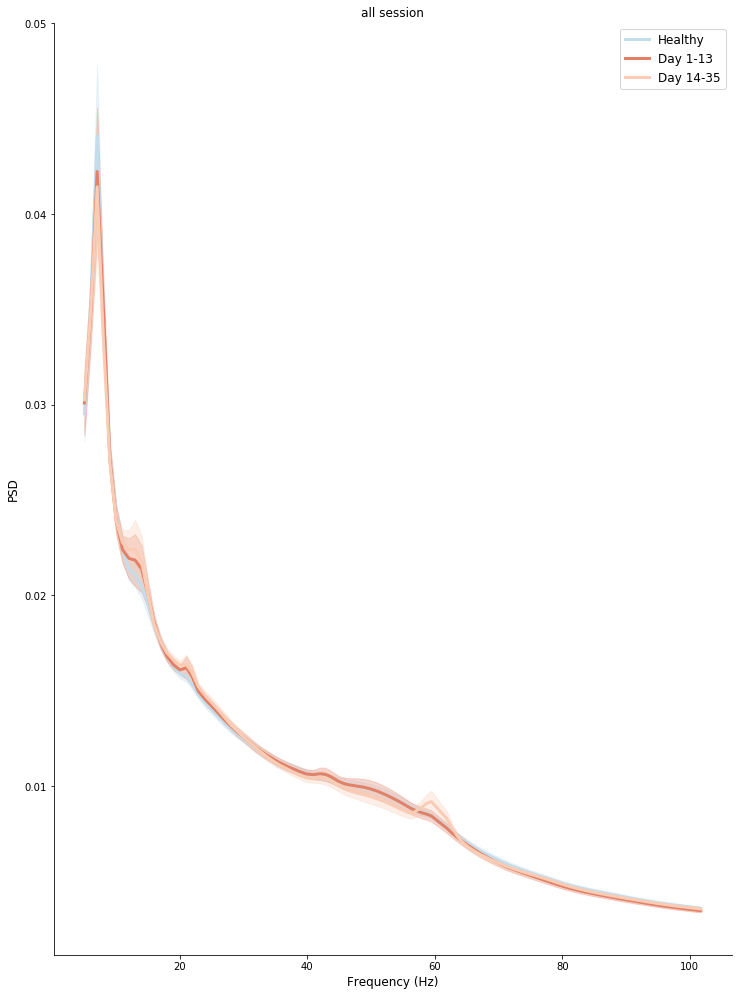

In [55]:
%matplotlib inline
colorsL = sns.cubehelix_palette(8)
colorsH = a3[[2,5,4]]#sns.cubehelix_palette(4, start=2, rot=5, dark=0, light=.65)
colorsH2 = sns.cubehelix_palette(8, start=3, rot=0, dark=0, light=.95)

fig, ax = plt.subplots(1,1,figsize=(12.15,17.15),sharey='row')
for ind, p in enumerate(periods.keys()):
    hC = np.nanmean(periods[p]['all'][a],axis=1)
    hS2 = np.nanstd(periods[p]['all'][a],axis=1)/np.sqrt(periods[p]['all'][a].shape[1])
       
    ax.plot(freq[a],hC,color = colorsH[ind], label=p,linewidth=3.0)
    ax.fill_between(freq[a], hC-hS2, hC+hS2,color=colorsH[ind],alpha=0.3)
#     ax.set_xlim(55,65)
    ax.set_title('all session')
#     ax.set_xlim(60,100)
#    ax[0,ind].set_ylim(0.015,0.03)
    ax.set_ylabel('PSD',fontsize=12)
    #ax[0,ind].axes.get_yaxis().set_ticks([])
    ax.set_xlabel('Frequency (Hz)',fontsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(fontsize=12)
# fig.savefig(figFolder+'lfpSpectromPost_LDOPA_lowSpeed_freq.png',transparent=True,format='png')
# ax.set_xlim(10,30)
fig.savefig(figFolder+'lfpSpectromPeriod_all.svg',transparent=True,format='svg')



In [24]:
def difAplly(row,fr):
    if row.mvmt in ['hiSpeed','lowSpeed']:
        low = float(df2[(df2.sess == row.sess)&(df2.Period == row.Period)&(df2.mvmt == 'lowSpeed')][fr].item())
    else:
        low = float(df2[(df2.sess == row.sess)&(df2.Period == row.Period)&(df2.mvmt == 'lowRot')][fr].item())
    val = float(row[fr])
    if low==0:
        return None
    else: #base <0 and val >0:
        return (low-val)

In [25]:
colorsL = sns.cubehelix_palette(8)
colorsH = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95)
colorsH2 = sns.cubehelix_palette(8, start=3, rot=0, dark=0, light=.95)

beta = (freq>10)&(freq<16)
beta2 = (freq>15)&(freq<25)
gamma =(freq>40)&(freq<60)
highGamma = (freq>60)&(freq<100)
highGamma2 = (freq>80)&(freq<100)

# print(periods[p]['hiSpeed'].shape,np.nanmean(periods[p]['hiSpeed'][beta],axis=0).shape)
df2 = pd.DataFrame(columns = ['Period','Mouse','sess','mvmt','beta','gamma'])
# # fig, ax = plt.subplots(2,3,figsize=(12.15,17.15),sharey='row')
for row in range(len(df)):
    for mv in ['highAC', 'highC', 'lowRot', 'lowSpeed', 'hiSpeed','rot','all']:
        try:
            te = np.array(df.iloc[row][mv])
            df3 = pd.DataFrame({'Period':df.iloc[row]['period'],'Mouse':df.iloc[row]['mouse'],'mvmt':mv,'sess':df.iloc[row]['Sess'],
                                'beta':np.nanmean(te[0,beta],axis=0),
                                'beta2':np.nanmean(te[0,beta2],axis=0),
                               'gamma':np.nanmean(te[0,gamma],axis=0),
                               'highGamma':np.nanmean(te[0,highGamma],axis=0),
                                'highGamma2':np.nanmean(te[0,highGamma2],axis=0),
                               'betaSum':np.nansum(te[0,beta],axis=0),
                                'betaSum2':np.nansum(te[0,beta2],axis=0),
                               'highGammaSum':np.nansum(te[0,highGamma],axis=0),
                                'highGammaSum2':np.nansum(te[0,highGamma2],axis=0),
                               'gammaSum':np.nansum(te[0,gamma],axis=0)},index=[0])
            df2 = pd.concat([df3,df2])
        except: 
            print(df.iloc[row]['Sess'],mv)

df2['ratio'] = df2.apply(lambda x: x.betaSum/x.gammaSum, axis = 1)
df2['ratio_High'] = df2.apply(lambda x: x.betaSum/x.highGammaSum, axis = 1)
df2['diffBeta'] = df2.apply(lambda x: difAplly(x,'betaSum'), axis = 1)

df2.to_csv(figFolder+'lfpForR.csv')
df2 = df2.groupby(['Mouse','Period','mvmt']).mean()
df2 = df2.reset_index()
df2.to_csv(figFolder+'lfpForR_grouped.csv')

0761_day31A highC
0761_day35L highC
0761_day35L hiSpeed
1208_day2 highC
1208_day30A highC
1208_day34L highC
1236_day15A highAC
1236_day19L highAC
1236_day30A highAC
2980_day19L highC
2981_day2 highAC
4539_day1 highAC
4539_day1 highC
4539_day1 rot
4539_day10 highAC
4539_day10 highC
4539_day10 rot
4539_day11 highAC
4539_day11 highC
4539_day11 rot
4539_day12 highAC
4539_day12 highC
4539_day12 rot
4539_day13 highAC
4539_day13 highC
4539_day13 rot
4539_day14 highAC
4539_day14 highC
4539_day14 rot
4539_day2 highAC
4539_day2 highC
4539_day2 rot
4539_day3 highAC
4539_day3 highC
4539_day3 rot
4539_day4 highAC
4539_day4 highC
4539_day4 rot
4539_day5 highAC
4539_day5 highC
4539_day5 rot
4539_day6 highAC
4539_day6 highC
4539_day6 rot
4539_day7 highAC
4539_day7 highC
4539_day7 rot
4539_day8 highAC
4539_day8 highC
4539_day8 rot
4539_day9 highAC
4539_day9 highC
4539_day9 rot
7584_day1 highAC
7584_day1 highC
7584_day1 rot
7584_day10 highAC
7584_day10 highC
7584_day10 rot
7584_day11 highAC
7584_day11 h

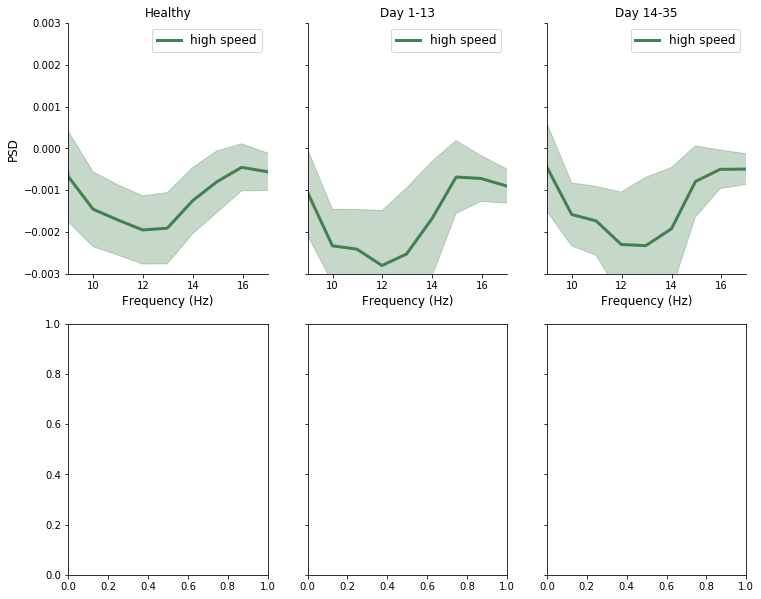

In [36]:
#periods = {'Healthy':{'axis':0},'Day 1-4':{'axis':1},'Day 5-12':{'axis':2},'Day 13-20':{'axis':3},'One Month':{'axis':4}}
%matplotlib inline
colorsL = sns.cubehelix_palette(8)
colorsH = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95)
colorsH2 = sns.cubehelix_palette(8, start=3, rot=0, dark=0, light=.95)

fig, ax = plt.subplots(2,3,figsize=(12.15,10.15),sharey='row')
for ind, p in enumerate(periods.keys()):
    hC = np.nanmean(periods[p]['hiSpeed'],axis=1) - np.nanmean(periods[p]['lowSpeed'],axis=1)
    hS2 = np.sqrt(np.nanstd(periods[p]['hiSpeed'],axis=1)**2+np.nanstd(periods[p]['lowSpeed'],axis=1)**2)/np.sqrt(2)
    hS2 = hS2/np.sqrt(periods[p]['hiSpeed'].shape[1])
       
    ax[0,ind].plot(freq,hC,color = colorsH[4], label='high speed',linewidth=3.0)
    ax[0,ind].fill_between(freq, hC-hS2, hC+hS2,color=colorsH[4],alpha=0.3)
#     ax[0,ind].plot(freq,lC,color = colorsL[4], label='low speed',linewidth=3.0)
#     ax[0,ind].fill_between(freq, lC-lS2, lC+lS2,color=colorsL[4],alpha=0.2)
    ax[0,ind].set_xlim(6,100)
#     ax[0,ind].set_yscale('log')
    ax[0,ind].set_title(p)
#    ax[0,ind].set_xlim(9,15)
#    ax[0,ind].set_ylim(0.015,0.03)
    ax[0,0].set_ylabel('PSD',fontsize=12)
    #ax[0,ind].axes.get_yaxis().set_ticks([])
    ax[0,ind].set_xlabel('Frequency (Hz)',fontsize=12)
    ax[0,ind].spines['right'].set_visible(False)
    ax[0,ind].spines['top'].set_visible(False)
    ax[0,ind].legend(fontsize=12)
    
#     hC = np.nanmean(periods[p]['highC'],axis=1)
#     hS2 = np.nanstd(periods[p]['highC'],axis=1)/np.sqrt(periods[p]['highC'].shape[1])
#     hAC = np.nanmean(periods[p]['highAC'],axis=1)
#     hS2A = np.nanstd(periods[p]['highAC'],axis=1)/np.sqrt(periods[p]['highAC'].shape[1])
#     lC = np.nanmean(periods[p]['lowRot'],axis=1)
#     lS2 = np.nanstd(periods[p]['lowRot'],axis=1)/np.sqrt(periods[p]['lowRot'].shape[1])
       
#     ax[1,ind].plot(freq,hC,color = colorsH[4], label='high Contralateral rot',linewidth=3.0)
#     ax[1,ind].fill_between(freq, hC-hS2, hC+hS2,color=colorsH[4],alpha=0.3)
#     ax[1,ind].plot(freq,hAC,color = colorsH2[4], label='high Ipsiliteral rot',linewidth=3.0)
#     ax[1,ind].fill_between(freq, hAC-hS2A, hAC+hS2A,color=colorsH2[4],alpha=0.3)
#     ax[1,ind].plot(freq,lC,color = colorsL[4], label='low rotation',linewidth=3.0)
#     ax[1,ind].fill_between(freq, lC-lS2, lC+lS2,color=colorsL[4],alpha=0.2)
#     ax[1,ind].set_xlim(6,100)
#     ax[1,ind].set_yscale('log')
#     ax[1,ind].set_title(p)
# #    ax[0,ind].set_xlim(9,15)
# #    ax[0,ind].set_ylim(0.015,0.03)
#     ax[1,0].set_ylabel('PSD',fontsize=12)
#     #ax[0,ind].axes.get_yaxis().set_ticks([])
#     ax[1,ind].set_xlabel('Frequency (Hz)',fontsize=12)
#     ax[1,ind].spines['right'].set_visible(False)
#     ax[1,ind].spines['top'].set_visible(False)
#     ax[1,ind].legend(fontsize=12)
# #fig.savefig(figFolder+'lfpSpectromPeriod.png',transparent=True,format='png')
# fig.savefig(figFolder+'figure5_lfpSpectromPeriod.svg',transparent=True,format='svg')

#fig2, ax2 = plt.subplots(1,2,sharex='col',sharey='row')
# for ind, p in enumerate(periods.keys()):
    ax[0,ind].set_xlim(9,17)
    ax[0,ind].set_ylim(-0.003,0.003)
#     ax[1,ind].set_xlim(9,17)
#     ax[1,ind].set_ylim(0.015,0.03)
# #     ax[0,ind].set_ylim(0,0.032)
# #     ax[1,ind].set_ylim(0,0.032)
# #fig.savefig(figFolder+'lfpSpectromPeriodZoomBeta.png',transparent=True,format='png')
# fig.savefig(figFolder+'figure5_ZoomBeta.svg',transparent=True,format='svg')
# for ind, p in enumerate(periods.keys()):
#     ax[0,ind].set_xlim(40,60)
#     ax[0,ind].set_ylim(0.008,0.012)
#     ax[1,ind].set_xlim(40,60)
#     ax[1,ind].set_ylim(0.008,0.012)
# #     ax[0,ind].set_ylim(0,0.02)
# #     ax[1,ind].set_ylim(0,0.02)
# fig.savefig(figFolder+'lfpSpectromPeriodZoomGamma.svg',transparent=True,format='svg')
# fig.savefig(figFolder+'figure5_lfpZoomGamma_log.svg',transparent=True,format='svg')
# for ind, p in enumerate(periods.keys()):
#     ax[0,ind].set_xlim(5,10)
#     ax[1,ind].set_xlim(5,10)
# #     ax[0,ind].set_ylim(0.03,0.05)
# #     ax[1,ind].set_ylim(0.03,0.05)
# fig.savefig(figFolder+'lfpSpectromPeriodZoomTheta.svg',transparent=True,format='svg')



In [34]:
hC

array([-5.63684048e-03, -7.29162017e-03,  1.80811030e-04,  1.64224330e-03,
       -4.39990242e-04, -1.57940939e-03, -1.73338651e-03, -2.29787899e-03,
       -2.32538315e-03, -1.92089655e-03, -7.90373008e-04, -5.00123892e-04,
       -4.93583928e-04, -4.55974624e-04, -5.92263316e-04, -4.05339510e-04,
       -2.60857966e-04, -1.77295990e-04, -1.37095488e-04,  7.23563732e-05,
        3.25155524e-04,  4.02320404e-04,  3.37419628e-04,  5.81558313e-04,
        8.17477237e-04,  8.41857826e-04,  6.54083588e-04,  5.67649756e-04,
        5.77689683e-04,  6.57108963e-04,  6.93037018e-04,  6.68877036e-04,
        5.82949946e-04,  5.58330126e-04,  5.77573927e-04,  5.98480054e-04,
        6.18190258e-04,  5.77248709e-04,  5.63789910e-04,  5.65130010e-04,
        5.80238190e-04,  5.86029303e-04,  6.11752704e-04,  6.48649375e-04,
        6.64399154e-04,  6.53874451e-04,  6.40110366e-04,  6.23897621e-04,
        5.54079634e-04,  4.69777480e-04,  4.31939101e-04,  3.43043571e-04,
        2.68155635e-04,  

/home/dana_z/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 62.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/dana_z/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 52.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/dana_z/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 45.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


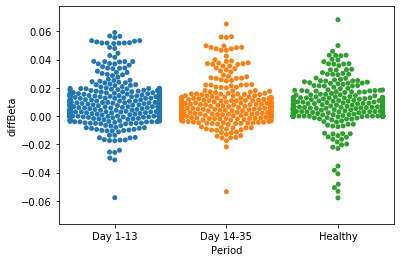

In [30]:
# df = pd.read_csv(figFolder+'lfpForR.csv')
sns.swarmplot(x='Period',y='diffBeta',data = df)


High-spped/ low-speed LFP align tpo MSN

In [12]:
# LOW Speed ONLY
warnings.filterwarnings("ignore")

# open all necassary files 
f = h5py.File('Spectograms.hdf5','r') #LFP coeffs
savePath = 'J:\\lfp2ca_notNormalize\\lowSpeed\\'

df = pd.DataFrame(columns=['mouse','sess','day','period','cre','numred'])

# constents for analysis:
WinPre = 2 #s
WinPost = 2 #s

# for each mouse: 
for m in miceList:
    data =  getData(Files[1],['lfp','trace'],period ='Pre', mice=m)
    cre = getCreType(Files[1],m)
    for sess in tqdm(data.keys()): 
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])

        numRed = int(data[sess]['trace']['numred'])

        # get data
        Ca = getOnsetOrPeriod(m,sess,'Pre','caOnset_Hf')
        
        # remove any events not in low periods
        Lp = getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_vector')
        if len(Lp)<Ca.shape[1]:
            Lp = np.append(Lp,0)
        Ca[:,Lp!=1] = 0;
        dCa = np.append(Ca[:,1:]-Ca[:,:-1],np.zeros((Ca.shape[0],1)),axis=1)
        dCa[dCa==-1] = 0
        
        coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
        lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
        try:
            coeff[:,(lfpOutliers[:,0]==1)] = np.nan
            coeff= coeff.T
            #coeff = coeff.T/np.nansum(coeff,axis=1) # So that axis[0] is the time axis + normalize power in frequency per sesion
        except:
            print(sess)
            continue
        

        dtS = float(1/data[sess]['trace']['FS'])
        dtL = float(1/data[sess]['lfp']['FS'])
        ts = np.arange(0, np.max(data[sess]['trace']['dff'].shape)) * dtS 
        tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL

        tPlot = np.linspace(-WinPre,WinPost,int((WinPre+WinPost)/dtL))     
        

        # for every Cre neuron:
        dca = dCa[0:numRed,:]
        dca = dca[np.sum(dca,axis=1)!=0,:]
        
        for creN in range(0,np.min(dca.shape)):
            onsetL = np.full_like(tl,False)
            cN = dca[creN,:]
            for si in ts[cN.astype(bool)]:
                ti = np.argmin(np.abs(tl-si))
                onsetL[ti] = True
            al = alignToOnset(coeff,(onsetL==1), winPost =WinPre/dtL, winPre = WinPost/dtL)

            if al.ndim <3:
                try:
                    al = np.reshape(al,(al.shape[0],al.shape[1],1))
                except:
                    print('no onset, when there should be. CRE#',creN,' in sess= ',sess)
                    continue
            al = np.nanmean(al,axis=2,keepdims=True)
            al = np.nan_to_num(al,nan=-9999)
            
            if 'aligned' in locals():
                aligned = np.concatenate((aligned,al), axis = 2)
            else:
                aligned = al
        
        if np.min(dca.shape)>0:
            pickle.dump( aligned, open( savePath+"CRE\\"+sess, "wb" ), protocol=4 )
            del aligned
        
        # for every MSN neuron:
        dca = dCa[numRed:,:]
        dca = dca[np.sum(dca,axis=1)!=0,:]
        
        for msnN in range(0,np.min(dca.shape)):
            onsetL = np.full_like(tl,False)
            mN = dca[msnN,:]
            for si in ts[mN.astype(bool)]:
                ti = np.argmin(np.abs(tl-si))
                onsetL[ti] = True
            al = alignToOnset(coeff,(onsetL==1), winPost =WinPre/dtL, winPre = WinPost/dtL)

            if al.ndim <3:
                try:
                    al = np.reshape(al,(al.shape[0],al.shape[1],1))
                except:
                    print('no onset, when there should be. MSN#',msnN,' in sess= ',sess)
                    continue
            
            al = np.nanmean(al,axis=2,keepdims=True)
            al = np.nan_to_num(al,nan=-9999)
            if 'aligned' in locals():
                aligned = np.concatenate((aligned,al), axis = 2)
            else:
                aligned = al
        
        if np.min(dca.shape)>0:
            pickle.dump( aligned, open( savePath+"MSN\\"+sess, "wb" ) , protocol=4)
            del aligned
        # add session to df, so can be retrived
        df= df.append({'mouse':m,'sess':sess,'day':day,
                       'period': periodCalc(day),'cre':cre,'numred':numRed,'numMsn':Ca.shape[0]},ignore_index=True)

df.to_csv(savePath+'sessions')


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data
I deleted session: 1208_day12


 46%|█████████████████████████████████████▊                                            | 6/13 [14:48<14:15, 122.15s/it]

found  17.0  outlier points


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data
found  1.0  outlier points


 64%|█████████████████████████████████████████████████████▎                             | 9/14 [04:39<02:27, 29.46s/it]

found  888231.0  outlier points


 71%|██████████████████████████████████████████████████████████▌                       | 10/14 [06:36<03:42, 55.71s/it]

found  481139.0  outlier points


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data
I deleted session: 2976_day4
found  1.0  outlier points


 92%|███████████████████████████████████████████████████████████████████████████▋      | 12/13 [03:25<00:17, 17.01s/it]

found  3.0  outlier points


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


 43%|███████████████████████████████████▌                                               | 6/14 [04:21<05:16, 39.54s/it]

found  50.0  outlier points


  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


 21%|█████████████████▍                                                                 | 4/19 [07:49<24:29, 97.99s/it]

found  29.0  outlier points


  0%|                                                                                           | 0/17 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [05:17<00:00, 22.69s/it]


In [13]:
# HIGH Speed ONLY
warnings.filterwarnings("ignore")

# open all necassary files 
f = h5py.File('Spectograms.hdf5','r') #LFP coeffs
savePath = 'J:\\lfp2ca_notNormalize\\highSpeed\\'

df = pd.DataFrame(columns=['mouse','sess','day','period','cre','numred'])

# constents for analysis:
WinPre = 2 #s
WinPost = 2 #s

# for each mouse: 
for m in miceList:
    data =  getData(Files[1],['lfp','trace'],period ='Pre', mice=m)
    cre = getCreType(Files[1],m)
    for sess in tqdm(data.keys()): 
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])

        numRed = int(data[sess]['trace']['numred'])

        # get data
        Ca = getOnsetOrPeriod(m,sess,'Pre','caOnset_Hf')
        
        # remove any events not in low periods
        Lp =  getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_vector')
        if len(Lp)<Ca.shape[1]:
            Lp = np.append(Lp,0)
        Ca[:,Lp!=1] = 0;
        dCa = np.append(Ca[:,1:]-Ca[:,:-1],np.zeros((Ca.shape[0],1)),axis=1)
        dCa[dCa==-1] = 0
        
        coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
        lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
        try:
            coeff[:,(lfpOutliers[:,0]==1)] = np.nan
            coeff= coeff.T
            #coeff = coeff.T/np.nansum(coeff,axis=1) # So that axis[0] is the time axis + normalize power in frequency per sesion
        except:
            print(sess)
            continue
        

        dtS = float(1/data[sess]['trace']['FS'])
        dtL = float(1/data[sess]['lfp']['FS'])
        ts = np.arange(0, np.max(data[sess]['trace']['dff'].shape)) * dtS 
        tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL

        tPlot = np.linspace(-WinPre,WinPost,int((WinPre+WinPost)/dtL))     
        

        # for every Cre neuron:
        dca = dCa[0:numRed,:]
        dca = dca[np.sum(dca,axis=1)!=0,:]
        
        for creN in range(0,np.min(dca.shape)):
            onsetL = np.full_like(tl,False)
            cN = dca[creN,:]
            for si in ts[cN.astype(bool)]:
                ti = np.argmin(np.abs(tl-si))
                onsetL[ti] = True
            al = alignToOnset(coeff,(onsetL==1), winPost =WinPre/dtL, winPre = WinPost/dtL)

            if al.ndim <3:
                try:
                    al = np.reshape(al,(al.shape[0],al.shape[1],1))
                except:
                    print('no onset, when there should be. CRE#',creN,' in sess= ',sess)
                    continue
            al = np.nanmean(al,axis=2,keepdims=True)
            al = np.nan_to_num(al,nan=-9999)
            
            if 'aligned' in locals():
                aligned = np.concatenate((aligned,al), axis = 2)
            else:
                aligned = al
        
        if np.min(dca.shape)>0:
            pickle.dump( aligned, open( savePath+"CRE\\"+sess, "wb" ), protocol=4 )
            del aligned
        
        # for every MSN neuron:
        dca = dCa[numRed:,:]
        dca = dca[np.sum(dca,axis=1)!=0,:]
        
        for msnN in range(0,np.min(dca.shape)):
            onsetL = np.full_like(tl,False)
            mN = dca[msnN,:]
            for si in ts[mN.astype(bool)]:
                ti = np.argmin(np.abs(tl-si))
                onsetL[ti] = True
            al = alignToOnset(coeff,(onsetL==1), winPost =WinPre/dtL, winPre = WinPost/dtL)

            if al.ndim <3:
                try:
                    al = np.reshape(al,(al.shape[0],al.shape[1],1))
                except:
                    print('no onset, when there should be. MSN#',msnN,' in sess= ',sess)
                    continue
            
            al = np.nanmean(al,axis=2,keepdims=True)
            al = np.nan_to_num(al,nan=-9999)
            if 'aligned' in locals():
                aligned = np.concatenate((aligned,al), axis = 2)
            else:
                aligned = al
        
        if np.min(dca.shape)>0:
            pickle.dump( aligned, open( savePath+"MSN\\"+sess, "wb" ) , protocol=4)
            del aligned
        # add session to df, so can be retrived
        df= df.append({'mouse':m,'sess':sess,'day':day,
                       'period': periodCalc(day),'cre':cre,'numred':numRed,'numMsn':Ca.shape[0]},ignore_index=True)

df.to_csv(savePath+'sessions')


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data
I deleted session: 1208_day12


 46%|██████████████████████████████████████▎                                            | 6/13 [10:17<09:56, 85.27s/it]

found  17.0  outlier points


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data
found  1.0  outlier points


 64%|█████████████████████████████████████████████████████▎                             | 9/14 [05:16<02:43, 32.65s/it]

found  888231.0  outlier points


 71%|██████████████████████████████████████████████████████████▌                       | 10/14 [07:12<03:51, 57.81s/it]

found  481139.0  outlier points


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data
I deleted session: 2976_day4
found  1.0  outlier points


 92%|███████████████████████████████████████████████████████████████████████████▋      | 12/13 [02:37<00:12, 12.02s/it]

found  3.0  outlier points


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


 43%|███████████████████████████████████▌                                               | 6/14 [04:56<05:55, 44.39s/it]

found  50.0  outlier points


  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


 21%|█████████████████▎                                                                | 4/19 [14:14<44:05, 176.36s/it]

found  29.0  outlier points


  0%|                                                                                           | 0/17 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [05:29<00:00, 23.52s/it]


In [9]:
def getAlignedLFP3(savePath,cellType,cre = None, mice = None, period = None, day=None, drug=None,drugPeriod='Pre'):
    # function that take in the classification and return the appropreate data:
    #Inputs:
    #   cellType - return MSN or CRE if both pass ['MNS','CRE']
    #   mice - (Optional) list of mice from to include. Default: None - will load data for all mice
    #   period - (Optional) either 'Pre' or 'Post'. difault: None - return full length of data from picked sessions
    #   day - (Optional) lambda function with logic for picking days. Default: None - ignore day attr when picking data
    #           NOTE: day will be ignored if period is specified
    #   cre - (Optional) which cre mouse is it. options:None (default), "PV", "CHI"
    #                   must have trace included in dataType list to be taken into account
    #   WinPre - (Optional) length of pre window in secounds (default 2)
    #   WinPost - (Optional) length of post window in secounds (default 2)
    #Output:
    #   data - the requested data. format: {mice_session:{dataType:data}}
    
    
    dFile = 'FinalData_6OHDA_H.h5'
    # double check parameters inputs are valid:
#     if drugPeriod=='Post':
#         savePath = 'J:\\lfp2ca_notNormalize\\Post\\'#'/home/dana_z/HD1/lfpAligned2Ca/Post/'
#     else:
#         savePath = 'J:\\lfp2ca_notNormalize\\'#'/home/dana_z/HD1/lfpAligned2Ca/Pre/'

    df = pd.read_csv(savePath+'sessions')
    
    if period == None and day != None and isinstance(day,type(lambda c:None)):
        df['keep'] = df.apply(lambda row: day(row.day), axis=1)
        df = df[(df.keep==True)]
    
    if period in ['Healthy','Acute','Chronic']:
        df = df[(df.period==period)]
       
    if cre in ['PV','CHI','NA']:
        df = df[(df.cre==cre)]
    
    if drug in ['Amph','L-Dopa','Saline','None']:
        df = df[(df.drug==drug)]
    

    if not isinstance(cellType,list):
        cellType = [cellType]
        
    cellType = list(set(cellType).intersection(set(['MSN','CRE'])))
    if len(cellType) == 0:
        raise ValueError('Not a valid cellType value. cellType must be in ["MSN","CRE"]')
    
    # traverse the hdf5 file:
    if mice == None:
        mice = getMiceList(dFile) 
    elif not isinstance(mice,list):
        mice = [mice]
    
    if not isinstance(mice[0],str):
        for m in range(0,len(mice)):
            mice[m] = str(mice[m])
    df = df[(df.mouse.isin(mice))]
    # start extracting the data:   
    
    # alllocate memory:
#    nNeurons = 0;
#    if 'MSN' in cellType:
#        nNeurons = nNeurons + int(df.numMsn.sum()) - int(df.numred.sum())
#    if 'CRE' in cellType:
#        nNeurons = nNeurons + int(df.numred.sum())
    nSess = len(df.mouse.unique())
    dResult = np.empty([12206,87,nSess],dtype=float)
    
    ind = 0
    for m in df.mouse.unique():
        dfM = df[df.mouse == m]
        indM = 0
        nSessM = len(df.sess.unique())
        nNeurons = 0
        if 'MSN' in cellType:
            nNeurons = nNeurons + int(dfM.numMsn.sum()) - int(dfM.numred.sum())
        if 'CRE' in cellType:
            nNeurons = nNeurons + int(dfM.numred.sum())
        MResult = np.empty([12206,87,nNeurons],dtype=float)
        for sess in dfM.sess.unique():
            if 'MSN' in cellType:
                try: 
                    tempD = pickle.load(open(savePath+'MSN\\'+sess,'rb'))
                except:
                    continue
                tempD[tempD==9999] = np.nan
                tempD[tempD==-9999] = np.nan
                mu = np.mean(tempD[:int(tempD.shape[0]/2),:,:],axis=0)
                Std = np.std(tempD[:int(tempD.shape[0]/2),:,:],axis=0)
                tempD =(tempD-mu)/Std
#                 print(indM,indM+tempD.shape[2],tempD.shape[2],MResult[:,:,indM:(indM+tempD.shape[2])].shape)
                MResult[:,:,indM:(indM+tempD.shape[2])] = tempD 
                indM = indM+tempD.shape[2]
            # for every Cre neuron:
            if 'CRE' in cellType:
                try:
                    tempD = pickle.load(open(savePath+'CRE\\'+sess,'rb'))
                except:
                    continue
                tempD[tempD==9999] = np.nan
                tempD[tempD==-9999] = np.nan
                mu = np.mean(tempD[:int(tempD.shape[0]/2),:,:],axis=0)
                Std = np.std(tempD[:int(tempD.shape[0]/2),:,:],axis=0)
                tempD =(tempD-mu)/Std
#                 print(indM,indM+tempD.shape[2],tempD.shape[2],MResult[:,:,indM:(indM+tempD.shape[2])].shape)
                MResult[:,:,indM:(indM+tempD.shape[2])] = tempD 
                indM = indM+tempD.shape[2]
        MResult = MResult[:,:,:indM]
        dResult[:,:,ind] = np.nanmean(MResult,axis=2)  
        ind = ind+1
        
    return dResult[:,:,:ind],df

<ipython-input-11-1f8339a55e6e>:9: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  freq = f['0761']['0761_BaselineA']['Pre']['freq'].value


<IPython.core.display.Javascript object>


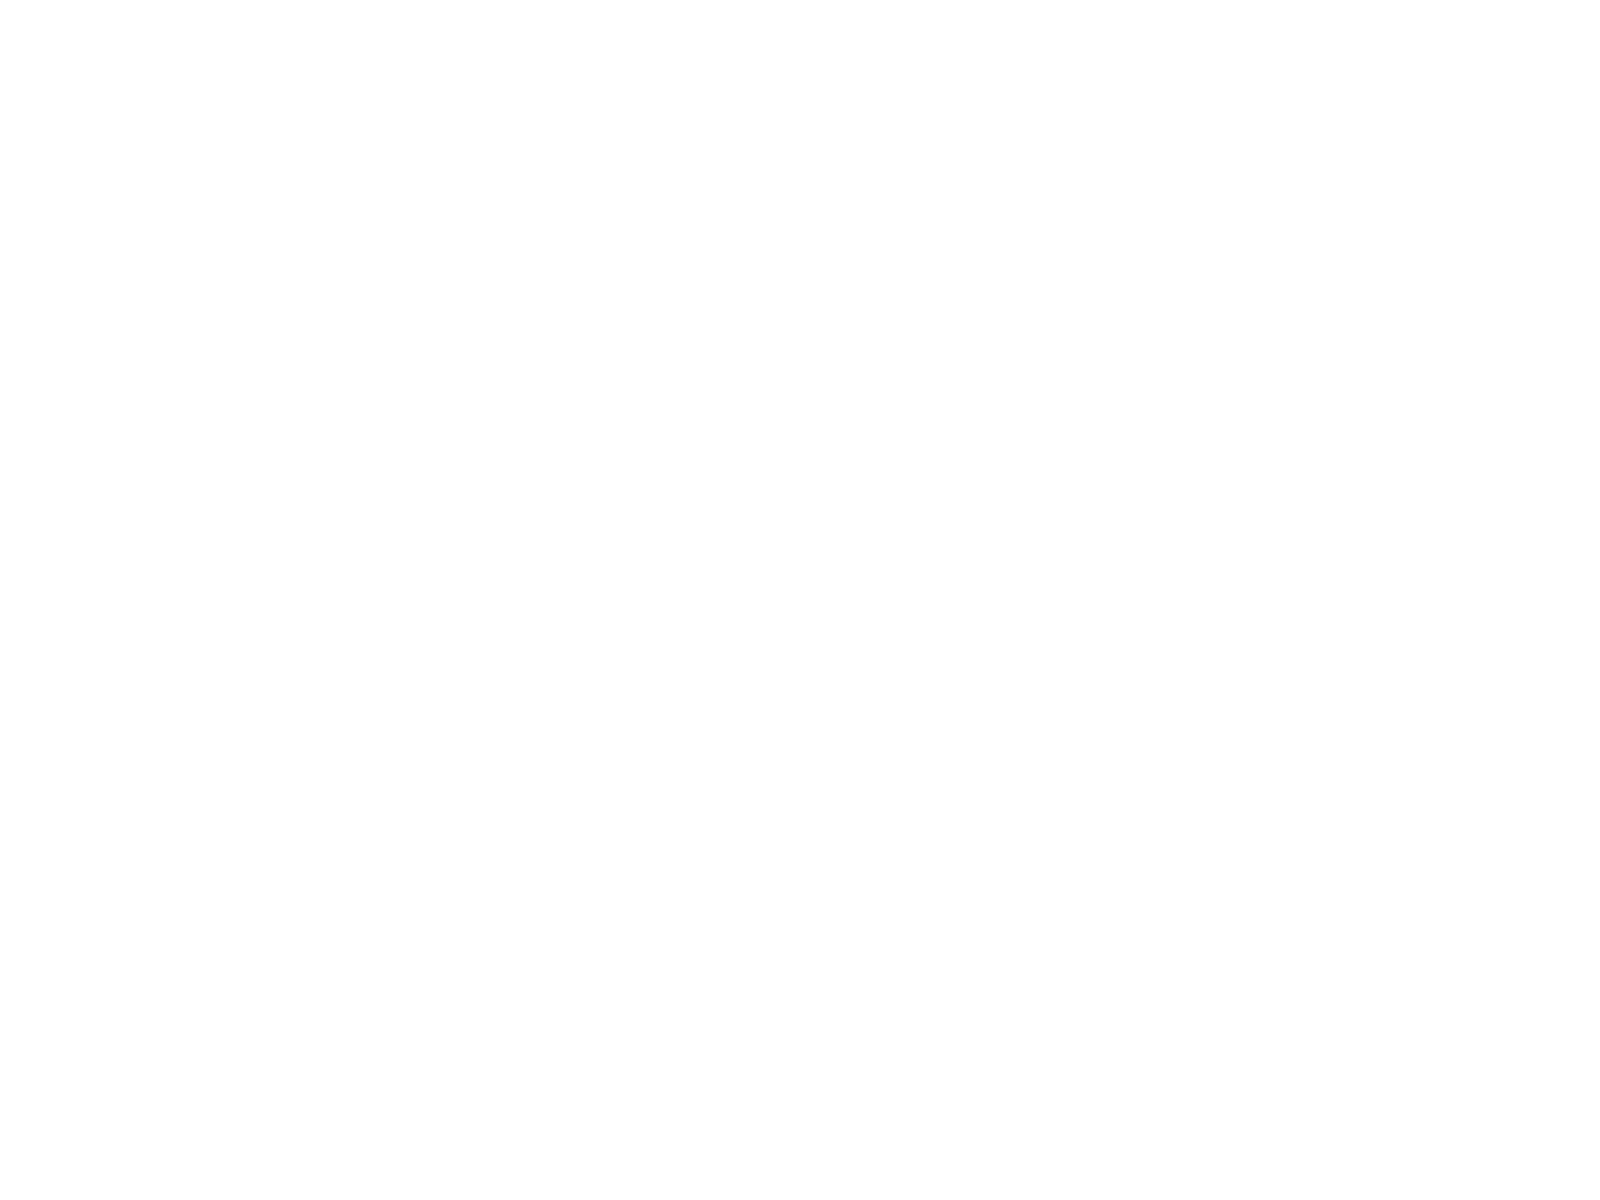

<IPython.core.display.Javascript object>


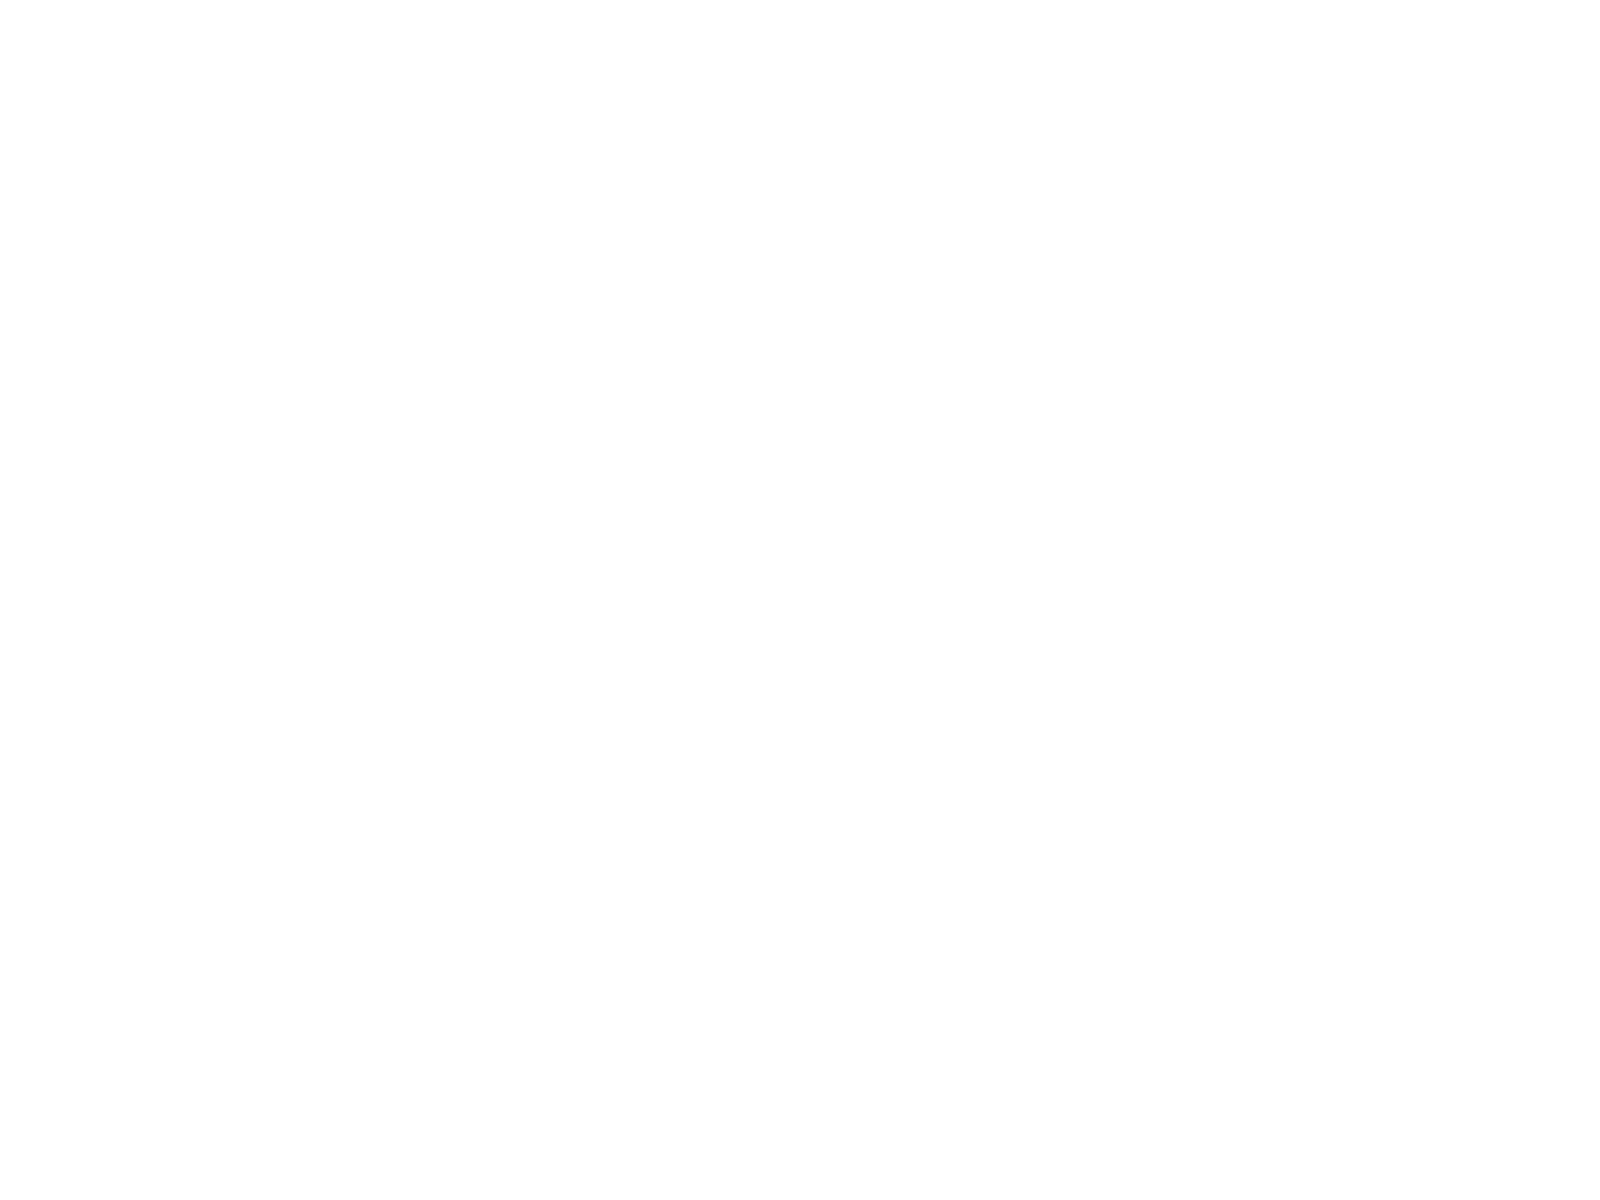

<IPython.core.display.Javascript object>


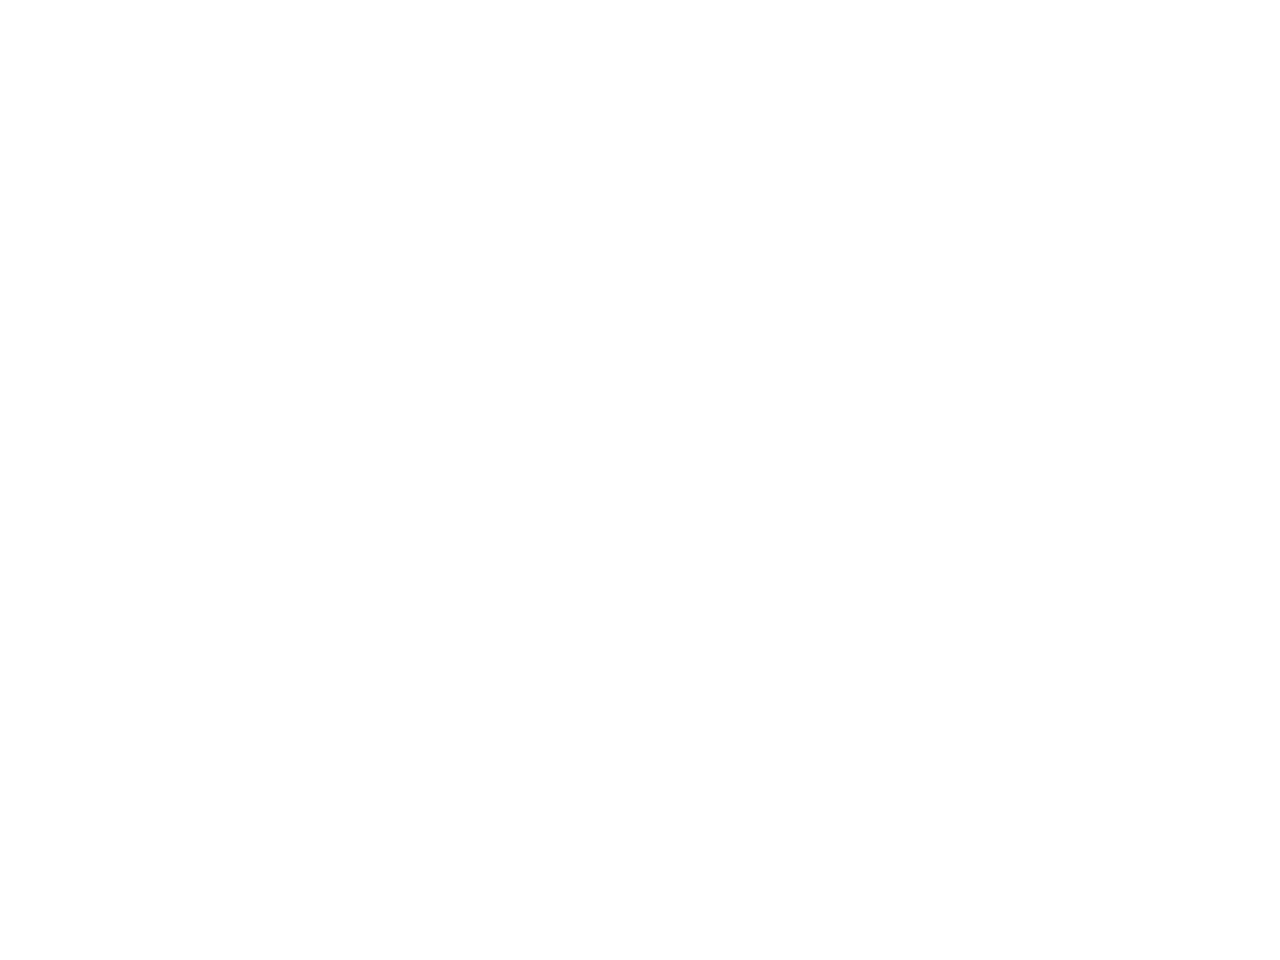

<ipython-input-11-1f8339a55e6e>:31: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  freq = f['0761']['0761_BaselineA']['Pre']['freq'].value


<IPython.core.display.Javascript object>


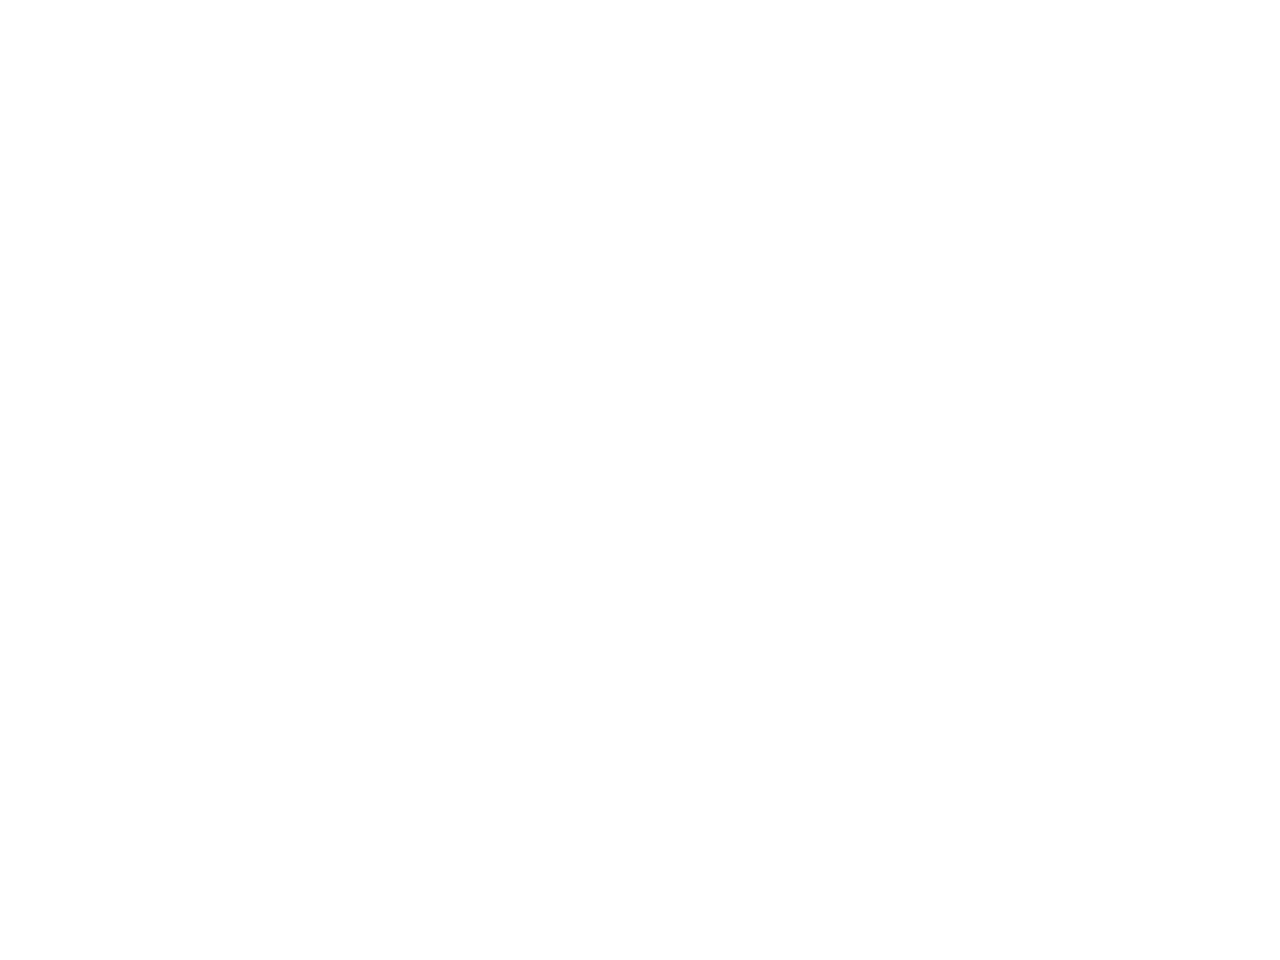

<IPython.core.display.Javascript object>


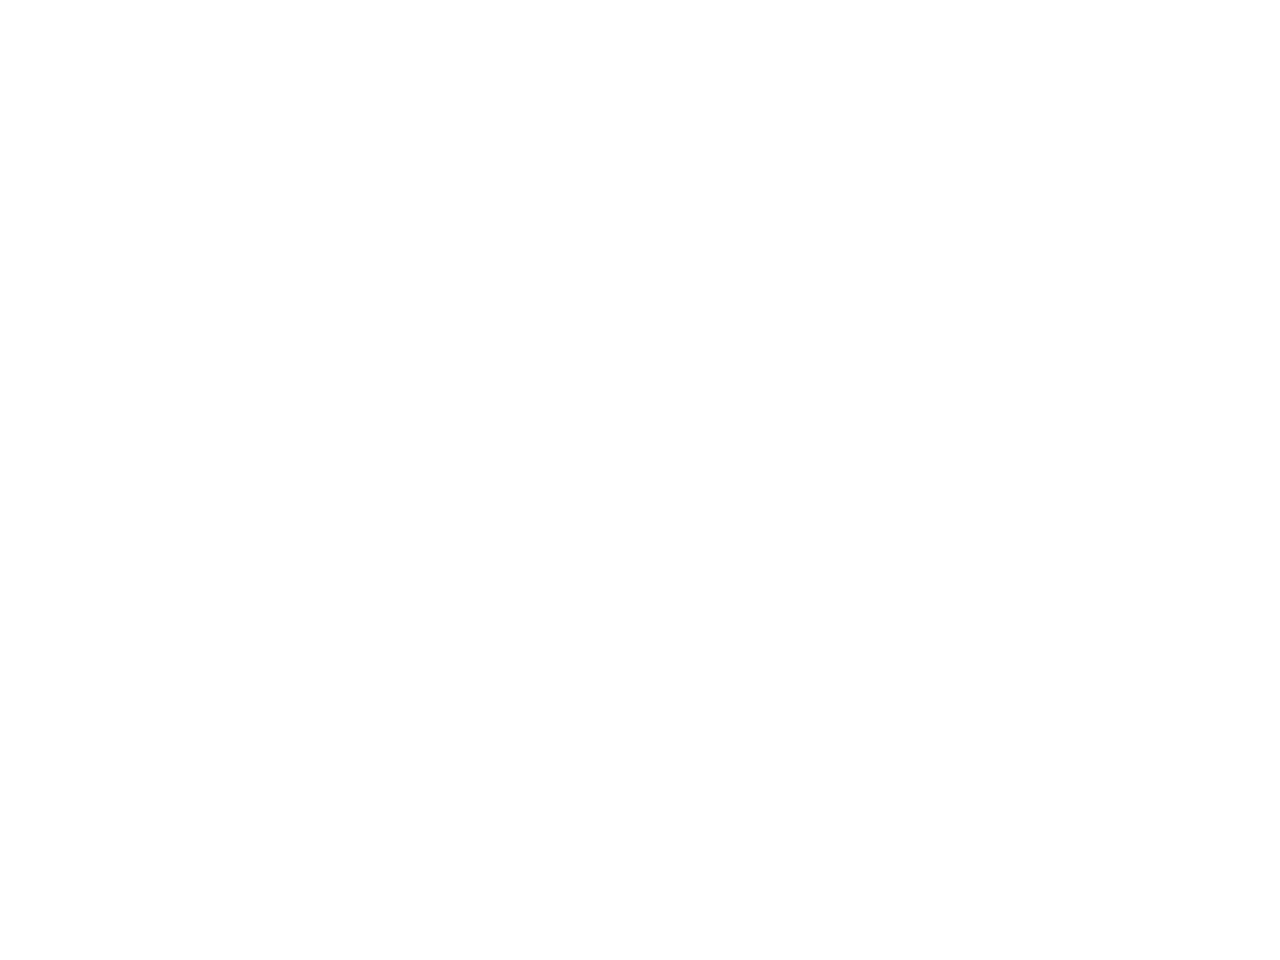

<IPython.core.display.Javascript object>


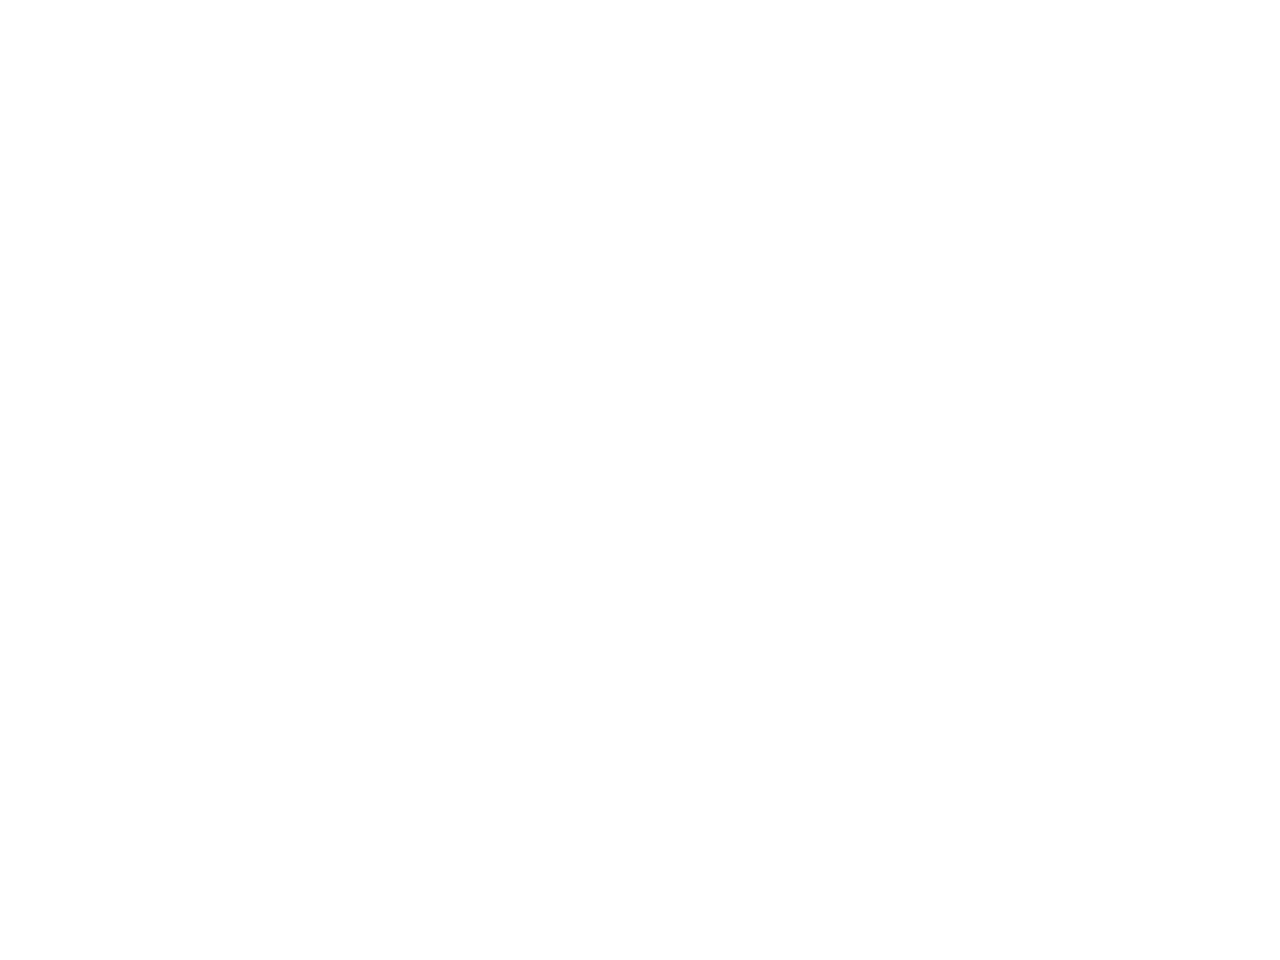

In [11]:
periods = {'Healthy': lambda day: day== 0,
           'Acute': lambda day: (day >0)&(day<13),
           'Chronic':lambda day: day >=13}

df = pd.read_csv('J:\\lfp2ca_notNormalize\\lowSpeed\\sessions')
sPath = 'J:\\lfp2ca_notNormalize\\lowSpeed\\'
cells = ['MSN']
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['0761_BaselineA']['Pre']['freq'].value
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
for per in periods.keys():
    cellType = 'MSN'
    cre = None
    A,df2 = getAlignedLFP3(sPath,cellType,cre = cre, day =periods[per])
    b = np.nanmean(A,axis=2)
    del A
    fig, ax = plt.subplots()
    CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmax =1.35,vmin=-0.5)
    fig.colorbar(CS)
    ax.set_title(per,fontsize=20)
#     fig.savefig(figFolder+'figure5_CHI'+per+'normalizedByNeuron.png',format='png')
    fig.savefig(figFolder+'figure5b_MSN_lowSpeed'+per+'.png',format='png',transparent=True)
    fig.clf()
    plt.close(fig)

df = pd.read_csv('J:\\lfp2ca_notNormalize\\highSpeed\\sessions')
sPath = 'J:\\lfp2ca_notNormalize\\highSpeed\\'
cells = ['MSN']
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['0761_BaselineA']['Pre']['freq'].value
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
for per in periods.keys():
    cellType = 'MSN'
    cre = None
    A,df2 = getAlignedLFP3(sPath,cellType,cre = cre, day =periods[per])
    b = np.nanmean(A,axis=2)
    del A
    fig, ax = plt.subplots()
    CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmax =1.35,vmin=-0.5)
    fig.colorbar(CS)
    ax.set_title(per,fontsize=20)
#     fig.savefig(figFolder+'figure5_CHI'+per+'normalizedByNeuron.png',format='png')
    fig.savefig(figFolder+'figure5b_MSN_highSpeed'+per+'.png',format='png',transparent=True)
    fig.clf()
    plt.close(fig)



In [31]:
periods = {'Healthy': lambda day: day== 0,
           'Acute': lambda day: (day >0)&(day<13),
           'Chronic':lambda day: day >=13}

Pdf = pd.DataFrame(columns = ['Mouse','Period','Sess','CellType'])
df = pd.read_csv('J:\\lfp2ca_notNormalize\\highSpeed\\sessions')
savePath = 'J:\\lfp2ca_notNormalize\\highSpeed\\'
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['0761_BaselineA']['Pre']['freq'].value
fr = {'high_Gamma':freq >= 60, 'low_Gamma':(freq >= 40) & (freq<60), 'high_Beta_15to20':(freq >= 15) & (freq<20),
         'Beta_10to15':(freq >= 10) & (freq<15),'theta':(freq >= 6) & (freq<8)}
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
t200 = (tPlot >0) & (tPlot<0.2)
for sess in df.sess.unique():
    m = sess[:4]
    period = periodCalc(df[df.sess==sess].day.values)
    cellType = 'highSpeed'
    try: 
        tDict = {'Mouse':m,'Period':period,'Sess':sess,'CellType':cellType}#     if per == 'One Month': 
#         # remove from figure only because too many outliers (Nan) makes the figure granular
#         # data was still used for analysis
#         l = getMiceList(Files[1])
#         l.remove('1236')
#         A,df2 =getAlignedLFP_mvmt(savePath, mice = l, period = per)
#     else:
        A = pickle.load(open(savePath+'MSN\\'+sess,'rb'))
        A[A==9999] = np.nan
        A[A==-9999] = np.nan
        
        if A.shape[2] > 1000:
            b = A[:,:,0:1000]
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nansum(b,axis=2)
            for ind in range(0,A.shape[2]//1000):
                c = A[:,:,1000*(ind+1):np.min([A.shape[2],1000*(ind+2)])]
                mu = np.mean(c[:int(c.shape[0]/2),:,:],axis=0)
                Std = np.std(c[:int(c.shape[0]/2),:,:],axis=0)
                c =(c-mu)/Std
                c = np.nansum(c,axis=2)
                b = b+c
            b= b/A.shape[2]
        else:
            b = A
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nanmean(b,axis=2)
        
        for k in fr.keys():
            highGamma = fr[k]
            tDict[k] = np.nanmean(b[t200,:][:,highGamma])
        Pdf = Pdf.append(tDict,ignore_index=True)
    except Exception as e:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        print(sess, " - MSN failed at line ",  exc_tb.tb_lineno)

df = pd.read_csv('J:\\lfp2ca_notNormalize\\lowSpeed\\sessions')
savePath = 'J:\\lfp2ca_notNormalize\\lowSpeed\\'
for sess in df.sess.unique():
    m = sess[:4]
    period = periodCalc(df[df.sess==sess].day.values)
    cellType = 'lowSpeed'
    try: 
        tDict = {'Mouse':m,'Period':period,'Sess':sess,'CellType':cellType}#     if per == 'One Month': 
#         # remove from figure only because too many outliers (Nan) makes the figure granular
#         # data was still used for analysis
#         l = getMiceList(Files[1])
#         l.remove('1236')
#         A,df2 =getAlignedLFP_mvmt(savePath, mice = l, period = per)
#     else:
        A = pickle.load(open(savePath+'MSN\\'+sess,'rb'))
        A[A==9999] = np.nan
        A[A==-9999] = np.nan
        
        if A.shape[2] > 1000:
            b = A[:,:,0:1000]
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nansum(b,axis=2)
            for ind in range(0,A.shape[2]//1000):
                c = A[:,:,1000*(ind+1):np.min([A.shape[2],1000*(ind+2)])]
                mu = np.mean(c[:int(c.shape[0]/2),:,:],axis=0)
                Std = np.std(c[:int(c.shape[0]/2),:,:],axis=0)
                c =(c-mu)/Std
                c = np.nansum(c,axis=2)
                b = b+c
            b= b/A.shape[2]
        else:
            b = A
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nanmean(b,axis=2)
        
        for k in fr.keys():
            highGamma = fr[k]
            tDict[k] = np.nanmean(b[t200,:][:,highGamma])
        Pdf = Pdf.append(tDict,ignore_index=True)
    except Exception as e:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        print(sess, " - MSN failed at line ",  exc_tb.tb_lineno)


        
Pdf.to_csv(figFolder+'statsForPowerMvmt.csv')

<ipython-input-31-667e445b8b91>:9: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  freq = f['0761']['0761_BaselineA']['Pre']['freq'].value


0761_day1  - MSN failed at line  27
0761_day35L  - MSN failed at line  27
1222_day2  - MSN failed at line  27
4539_day13  - MSN failed at line  27


<ipython-input-31-667e445b8b91>:50: RuntimeWarning: Mean of empty slice
  b = np.nanmean(b,axis=2)
<ipython-input-31-667e445b8b91>:54: RuntimeWarning: Mean of empty slice
  tDict[k] = np.nanmean(b[t200,:][:,highGamma])


7909_day11  - MSN failed at line  27
7909_day12  - MSN failed at line  27
7909_day13  - MSN failed at line  27
7909_day14  - MSN failed at line  27
7909_day5  - MSN failed at line  27
7909_day8  - MSN failed at line  27
7909_day9  - MSN failed at line  27
0761_day1  - MSN failed at line  74
1222_day5  - MSN failed at line  74
7909_day30A  - MSN failed at line  74


In [32]:
Pdf = pd.read_csv(figFolder+'statsForPowerMvmt.csv')
Pdf.head()
df2 = Pdf
df2 = df2.groupby(['Mouse','Period','CellType']).mean()
df2 = df2.reset_index()
df3 = df2
columns = ['high_Gamma','high_Beta_15to20','Beta_10to15','low_Gamma']

def nor(row,col):
    base = float(df2[(df2.Mouse == row.Mouse)&(df2.CellType == row.CellType)&(df2.Period == 'Healthy')][col].item())
    val = float(row[col])
    if base==0:
        return None
    else: #base <0 and val >0:
        return (val-base)/np.abs(base)
#     else:
#         return (val-base)/base

for ind in range(len(columns)):
#     df2[columns[ind]+'_normalized'] = df2.apply(lambda row: (row[columns[ind]]-df2[(df2.Mouse == row.Mouse)&(df2.CellType == row.CellType)&(df2.Period == 'Healthy')][columns[ind]].item())/df2[(df2.Mouse == row.Mouse)&(df2.CellType == row.CellType)&(df2.Period == 'Healthy')][columns[ind]].item() if df2[(df2.Mouse == row.Mouse)&(df2.CellType == row.CellType)&(df2.Period == 'Healthy')][columns[ind]].item() != 0 else None,axis=1)
    df3[columns[ind]] = df3.apply(lambda row: nor(row,columns[ind]) ,axis=1)


<IPython.core.display.Javascript object>


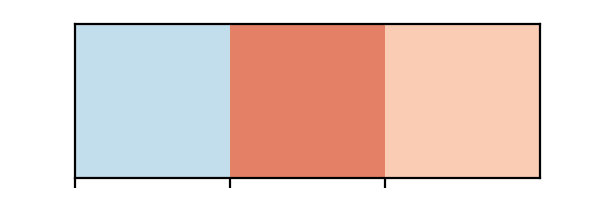

In [21]:
a3 = np.array(sns.color_palette("RdBu_r", n_colors=7))
# colorPallet3 =(a3[[2,6,5],:])
colorPallet3 =(a3[[2,5,4],:])
sns.palplot(sns.color_palette(colorPallet3))

In [27]:
dfP

Period   CellType  Mouse    variable     value
0     Acute  highSpeed    761  high_Gamma  0.059601
1     Acute   lowSpeed    761  high_Gamma -0.025270
2   Chronic  highSpeed    761  high_Gamma -1.520014
3   Chronic   lowSpeed    761  high_Gamma -0.022106
4   Healthy  highSpeed    761  high_Gamma  0.000000
..      ...        ...    ...         ...       ...
83    Acute   lowSpeed   8815  high_Gamma -0.155136
84  Chronic  highSpeed   8815  high_Gamma -0.736574
85  Chronic   lowSpeed   8815  high_Gamma -0.223237
86  Healthy  highSpeed   8815  high_Gamma  0.000000
87  Healthy   lowSpeed   8815  high_Gamma  0.000000

[88 rows x 5 columns]

<IPython.core.display.Javascript object>


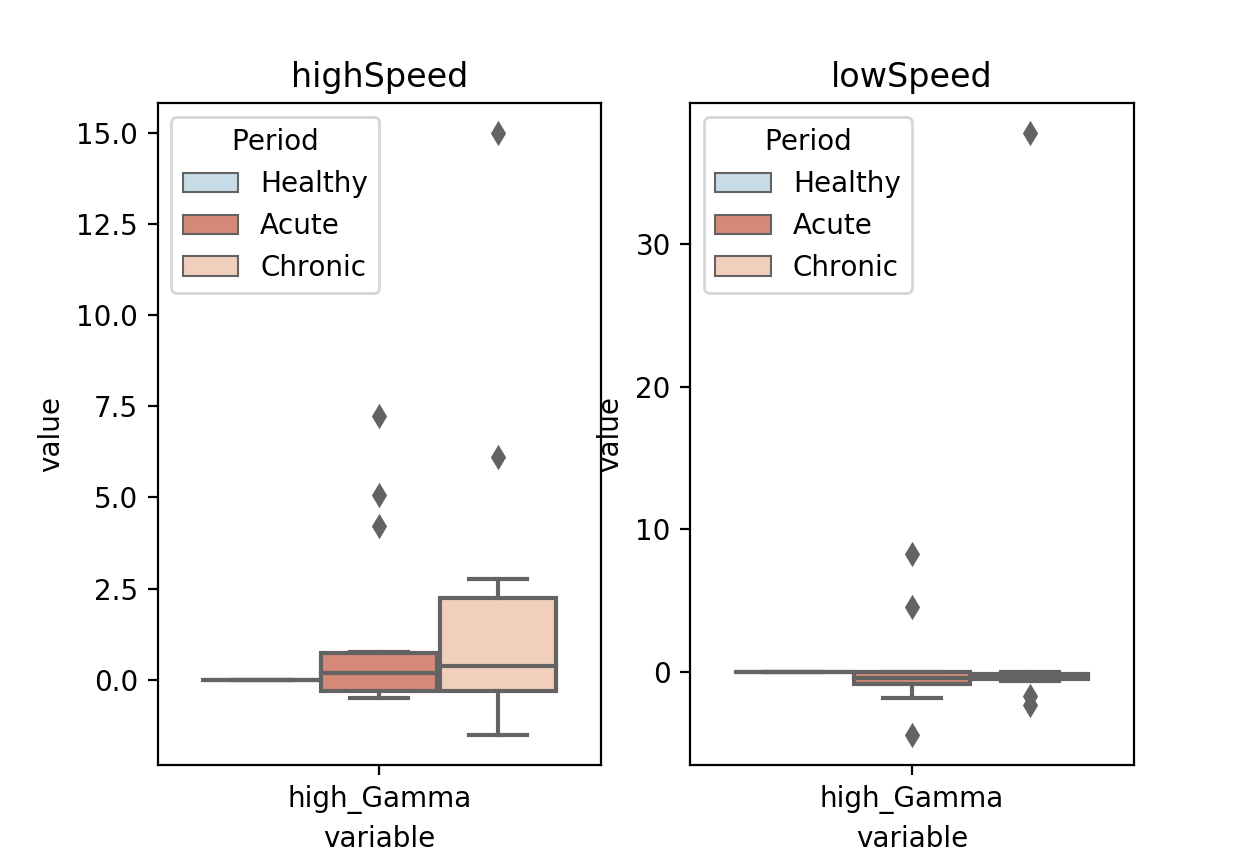

In [34]:
dfP = pd.melt(df3, id_vars = ['Period','CellType','Mouse'],value_vars = ['high_Gamma'])
fig, ax = plt.subplots(1,2,figsize=(6.3,4.3))#, sharey=True )
# dfP.CellType
# for indP, p in enumerate(['high_Gamma','high_Beta_15to20','low_Gamma']):
with sns.color_palette(colorPallet3):
    for indC,c in enumerate(["highSpeed","lowSpeed"]):
        sns.boxplot(x = 'variable',y ='value',hue = 'Period',ax = ax[indC],data= dfP[dfP.CellType ==c],
                    hue_order=['Healthy','Acute','Chronic'])#, showfliers = False)
#         sns.swarmplot(x = 'Period',y ='value',hue = 'Period',ax = ax[indC],data= dfP[dfP.CellType ==c],
#                     hue_order=['Healthy','Day 14-35'],order=['Healthy','Day 14-35'],color = 'black')
    #         sns.boxplot(x = 'Period',y =p,ax = ax[indC,indP],data= Pdf[Pdf.CellType ==c], showfliers = False)
    #         sns.pointplot(x = 'variable',y = 'value',hue = 'Period',ax = ax[indC],data= dfP[dfP.CellType ==c], showfliers = False)
        ax[indC].set_title(c)
# fig.savefig(figFolder+'figure6_statsBars_L-dopa_.svg',transparent=True)